# **Intro CVAE**
In this notebook I use a conditional variational autoencoder (CVAE) in order to determine the single-cell perturbation effect.
The VAE is conditioned on the sample ID and perturbation status.



The experimental set-up is as follows:
All data is from Kang dataset.
We generate pesudobulks from the original data, which contains 8 samples and 1 stimulated and one ctrl condition per sample.
We either perturb all cells, a single cell-type, or no cell types. 
This is done when we generate the pseudobulks by sampling from either perturbed or non-perturbed cells within each sample.
This is denoted in the parameter `exp_id`, it can be "all-kang", "mono-kang", "b-kang", "cd4Naive-kang", or "none-kang"
This is like a perturbation that would cause one cell type to change.
We use 2 samples as the "labeled" data (meaning each sample has a ground truth cell-type proportion and it is from the cell-type proportion) and 6 samples with unlabeled data (ground truth proportions are not used in training.)




A lot of the model code was taken from this tutorial: https://github.com/nnormandin/Conditional_VAE/blob/master/Conditional_VAE.ipynb


# **Imports**

In [216]:
# general imports
import warnings
import numpy as np
import scanpy as sc

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Softmax, ReLU, ELU, LeakyReLU
from tensorflow.keras.layers import concatenate as concat
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mean_absolute_error, mean_squared_error, KLDivergence
from tensorflow.keras.datasets import mnist
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.utils import to_categorical, normalize, plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.stats import spearmanr, pearsonr
from scipy.spatial.distance import euclidean
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from PIL import Image

from tqdm import tnrange, tqdm_notebook
import ipywidgets

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, MinMaxScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet

# programming stuff
import time
import os
import pickle
from pathlib import Path

# import the SC_preprocessing code
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from sc_preprocessing import sc_preprocess
from method_comparison import validation_plotting as vp


# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


In [217]:
## parameters
sc_aug_data_path = f"{os.getcwd()}/../data/single_cell_data/augmented_liver_data/"
bulk_aug_data_path = f"{os.getcwd()}/../data/bulk_data/liver_sex/"
reference_data_path = f"{os.getcwd()}/../data/reference_data/"
res_data_path = f"{os.getcwd()}/../results/single_cell_data/buddiM2_liver/"

de_genes_path = f"{os.getcwd()}/../data/single_cell_data/liver_sex/de_pseudobulk_results.pkl"
de_bulk_path = f"{os.getcwd()}/../data/bulk_data/liver_sex/de_real_bulk_results.pkl"


cibersort_path = f"{os.getcwd()}/../data/single_cell_data/cibersort_liver/"


cibersort_genes_path = (f"{os.getcwd()}/../results/single_cell_data/cibersort_liver/" +
                        "CIBERSORTx_Job20_all-liver_0_cybersort_sig_inferred_phenoclasses" +
                        ".CIBERSORTx_Job20_all-liver_0_cybersort_sig_inferred_refsample.bm.K999.txt")


num_genes = 7000

exp_id = "all-liver"

# Set-up experimental variables

In [218]:

##################################################
#####. set up experiment specific variables
##################################################

# number expected cell types
n_cell_types = 8

# number of patients/domains/samples expected
n_tot_samples = 51 # 3 "patients", old / young

# number of drugs (one-hot encoded)
n_drugs = 2

# number of types of sequencing (one-hot encoded)
n_bulk = 2

# experiment id
lab_file_name = exp_id


# **Load / Pre-process data**
Import pre-processed pseudobulks

In [219]:
in_name = "liver_bulk_processed"


# read in the real bulk data
processed_sc_file = f"{bulk_aug_data_path}/{in_name}.h5ad"
adata = sc.read_h5ad(processed_sc_file)


# now get the sc ref training data

# read in male first
sample_order = ['30-M-5']

X_concat = None
Y_concat = None
meta_concat = None
for curr_samp in sample_order:

    print(curr_samp)
    pseudobulks_df, prop_df, gene_df, sig_df, metadata_df = sc_preprocess.read_single_liver_pseudobulk_file(sc_aug_data_path, curr_samp, "CTRL", "Train", exp_id)
    pseudobulks_df.columns = gene_df

    if X_concat is None:
        X_concat, Y_concat, meta_concat = pseudobulks_df, prop_df, metadata_df
    else:
        X_concat = pd.concat([X_concat, pseudobulks_df])
        Y_concat = pd.concat([Y_concat, prop_df])
        meta_concat = pd.concat([meta_concat, metadata_df])

# now read in female
sample_order = ['18-F-51']
for curr_samp in sample_order:

    print(curr_samp)
    pseudobulks_df, prop_df, gene_df, sig_df, metadata_df = sc_preprocess.read_single_liver_pseudobulk_file(sc_aug_data_path, curr_samp, "STIM", "Test", exp_id)
    pseudobulks_df.columns = gene_df

    X_concat = pd.concat([X_concat, pseudobulks_df])
    Y_concat = pd.concat([Y_concat, prop_df])
    meta_concat = pd.concat([meta_concat, metadata_df])



# read in the bulk data
real_bulk_df = pd.DataFrame(adata.X, columns=adata.var_names, index=adata.obs.index)
real_bulk_meta_df = adata.obs

# select genes that are in both
intersect_genes = np.intersect1d(gene_df, real_bulk_df.columns)
X_concat = X_concat[intersect_genes]
real_bulk_df = real_bulk_df[intersect_genes]

# get the bulk metadata formatted
real_bulk_meta_df = real_bulk_meta_df[["sample_id", "stim"]]
real_bulk_meta_df["isTraining"] = "Train"
real_bulk_meta_df["cell_prop_type"] = "realistic"
real_bulk_meta_df["samp_type"] = "bulk"
real_bulk_meta_df['sample_id'] = real_bulk_meta_df['sample_id'].astype(str)


# put the reference singlecell and real bulk it all together
X_full = pd.concat([X_concat, real_bulk_df])
Y_full = pd.concat([Y_concat, Y_concat.iloc[range(15)]]) ## stop gap for now
meta_df = pd.concat([meta_concat, real_bulk_meta_df])


# format the bulk data
real_bulk_df = pd.DataFrame(adata.X, columns=adata.var_names, index=adata.obs.index)
real_bulk_meta_df = adata.obs

# select genes that are in both
intersect_genes = np.intersect1d(gene_df, real_bulk_df.columns)
X_concat = X_concat[intersect_genes]
real_bulk_df = real_bulk_df[intersect_genes]

# now we have a new gene_df
gene_df = pd.DataFrame(intersect_genes)
gene_df.columns = ["gene_ids"]
gene_df.set_index(gene_df["gene_ids"])
gene_df = gene_df.gene_ids

# get the bulk metadata formatted
real_bulk_meta_df = real_bulk_meta_df[["sample_id", "stim"]]
real_bulk_meta_df["isTraining"] = "Train"
real_bulk_meta_df["cell_prop_type"] = "realistic"
real_bulk_meta_df["samp_type"] = "bulk"
real_bulk_meta_df['sample_id'] = real_bulk_meta_df['sample_id'].astype(str)

# put the reference singlecell and real bulk it all together
X_full = pd.concat([X_concat, real_bulk_df])
Y_full = pd.concat([Y_concat, Y_concat.iloc[range(real_bulk_df.shape[0])]]) ## stop gap for now
meta_df = pd.concat([meta_concat, real_bulk_meta_df])



30-M-5
18-F-51


<ipython-input-219-87ecae84aa3b>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_bulk_meta_df["isTraining"] = "Train"
<ipython-input-219-87ecae84aa3b>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_bulk_meta_df["cell_prop_type"] = "realistic"
<ipython-input-219-87ecae84aa3b>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

In [220]:

##################################################
#####. Design the experiment
##################################################


X_orig = np.copy(X_full)

# set up the metadata arrays and indices
samp_label = np.asarray(meta_df.sample_id)
index_label, numeric_label = np.unique(samp_label, return_inverse=True)
Label_full = numeric_label
label_full = to_categorical(numeric_label)

samp_drug = np.asarray(meta_df.stim)
index_drug, numeric_drug = np.unique(samp_drug, return_inverse=True)
Drug_full = numeric_drug
drug_full = to_categorical(numeric_drug)

samp_bulk = np.asarray(meta_df.samp_type)
index_bulk, numeric_bulk = np.unique(samp_bulk, return_inverse=True)
Bulk_full = numeric_bulk
bulk_full = to_categorical(numeric_bulk)


idx_train = np.where(meta_df.isTraining=="Train")[0] 
idx_test = np.where(meta_df.isTraining!="Train")[0] 
idx_bulk = np.where(meta_df.samp_type == "bulk")[0]
idx_sc = np.where(meta_df.samp_type != "bulk")[0]
idx_drug = np.where(meta_df.stim == "STIM")[0]

Y_max = np.copy(Y_full)
Y_max = np.argmax(Y_max, axis=1)
Y_max = Y_full.columns[Y_max]
meta_df["Y_max"] = Y_max

# now seperate out the training and testing data
X_train_df = X_full.iloc[idx_train]
Y_train_df = Y_full.iloc[idx_train]


# try using the cibersort genes
cibersort_df = pd.read_csv(cibersort_genes_path, sep="\t" )
cibersort_genes = cibersort_df["NAME"].values.tolist()

# only keep cibersort genes that are in common genes
cibersort_genes = np.intersect1d(gene_df, cibersort_genes)



# convert to data matrices
X_train = X_train_df.to_numpy()
Y_train = Y_train_df.to_numpy()

## get the top variable genes
X_colmean = X_train.mean(axis=0)
X_colvar = X_train.var(axis=0)
X_CoV = np.array(np.divide(X_colvar, X_colmean+0.001))
idx_top = np.argpartition(X_CoV, -6680)[-6680:] # num_genes # 6679
gene_df = gene_df.iloc[idx_top]


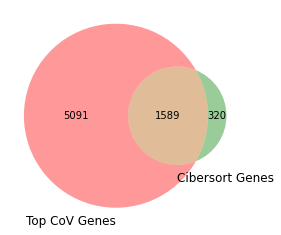

In [221]:

venn2([set(gene_df), set(cibersort_genes)], set_labels = ('Top CoV Genes', 'Cibersort Genes'))
plt.show()

In [222]:
union_genes = np.union1d(gene_df, cibersort_genes)
len(union_genes)

7000

In [223]:
def pearsonr_2D(x, y):
    """computes pearson correlation coefficient
       where x is a 1D and y a 2D array"""

    upper = np.sum((x - np.mean(x)) * (y - np.mean(y, axis=1)[:,None]), axis=1)
    lower = np.sqrt(np.sum(np.power(x - np.mean(x), 2)) * np.sum(np.power(y - np.mean(y, axis=1)[:,None], 2), axis=1))
    
    rho = upper / lower
    
    return rho

In [224]:
X_full = X_full.loc[:,union_genes]

## normalize within sample
clip_upper = np.quantile(X_full, 0.9)
X_full = np.clip(X_full, 0, clip_upper)
scaler = MinMaxScaler()
scaler.fit(X_full)

# now normalize with the scaler trained on the 
# training data
X_full = np.clip(X_full, 0, clip_upper)
X_full = scaler.transform(X_full)


# for unknown proportions; 
# this is bulks used in training
idx_bulk_train = np.intersect1d(idx_bulk, idx_train) 
X_unkp = X_full[idx_bulk_train,]
label_unkp = label_full[idx_bulk_train,]
drug_unkp = drug_full[idx_bulk_train,]
y_unkp = Y_full.iloc[idx_bulk_train]
y_unkp = y_unkp.to_numpy()

# for known proportions
idx_sc_train = np.intersect1d(idx_sc, idx_train) 
X_kp = X_full[idx_sc_train,]
label_kp = label_full[idx_sc_train,]
drug_kp = drug_full[idx_sc_train,]
y_kp = Y_full.iloc[idx_sc_train]
y_kp = y_kp.to_numpy()


X_cvae = X_full[idx_train,]
label_cvae = label_full[idx_train,]
bulk_cvae = bulk_full[idx_train,]
drug_cvae = drug_full[idx_train,]
y_cvae = Y_full.iloc[idx_train,]




In [225]:
X_train

array([[6.04790753e+03, 4.13491679e+03, 3.72671291e+02, ...,
        1.31632535e+03, 2.06216943e+03, 1.76635544e+02],
       [1.29872810e+04, 6.51578699e+03, 1.76391206e+01, ...,
        2.26274923e+03, 1.77538685e+03, 1.00000000e+01],
       [2.70810459e+02, 2.20964577e+03, 2.41347443e+02, ...,
        2.90765409e+03, 2.83329645e+03, 6.61815872e+01],
       ...,
       [0.00000000e+00, 4.00000000e+00, 0.00000000e+00, ...,
        6.40000000e+01, 6.20000000e+01, 0.00000000e+00],
       [6.00000000e+00, 5.20000000e+01, 7.00000000e+00, ...,
        9.70000000e+01, 7.70000000e+01, 0.00000000e+00],
       [3.24600000e+03, 3.13000000e+02, 2.20000000e+01, ...,
        5.65000000e+02, 4.04000000e+02, 1.00000000e+00]])

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 3649 samples in 0.014s...
[t-SNE] Computed neighbors for 3649 samples in 0.887s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3649
[t-SNE] Computed conditional probabilities for sample 2000 / 3649
[t-SNE] Computed conditional probabilities for sample 3000 / 3649
[t-SNE] Computed conditional probabilities for sample 3649 / 3649
[t-SNE] Mean sigma: 1.161060
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.599091
[t-SNE] KL divergence after 500 iterations: 0.948376
(3649, 2)
(3649, 2)


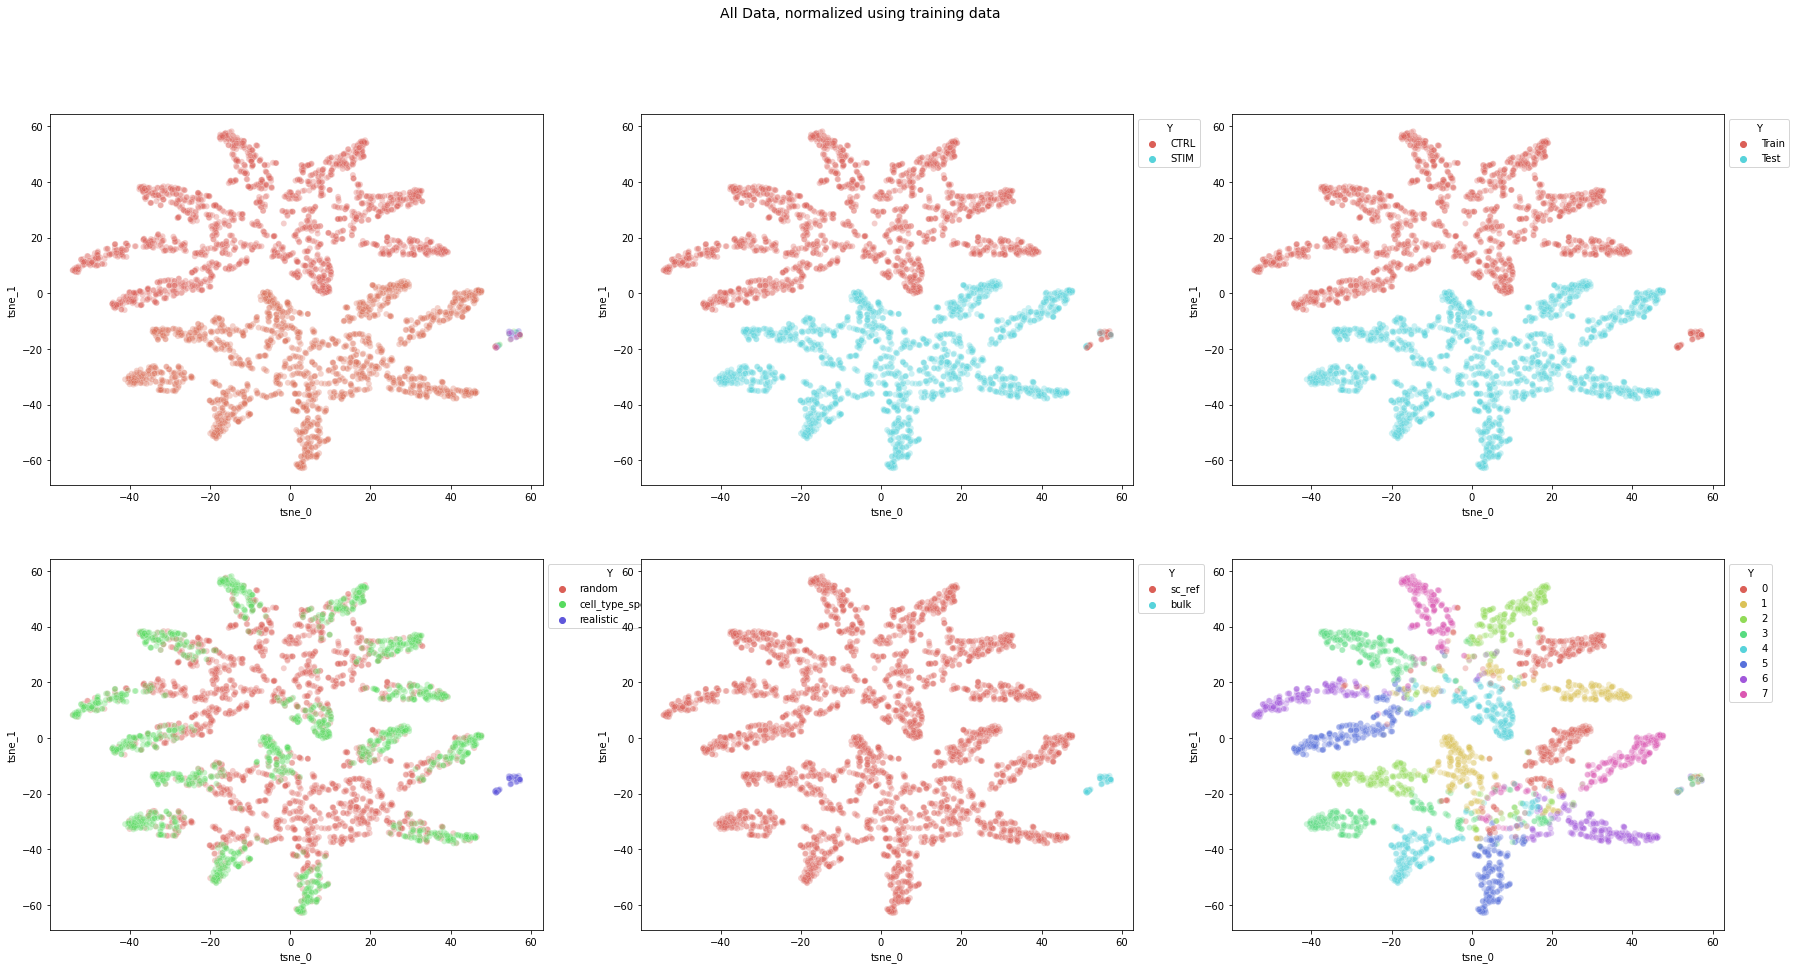

In [226]:
## plot samples
plot_df = vp.get_tsne_for_plotting(X_full)

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_tsne(plot_df, meta_df.sample_id.to_numpy(), axs[0,0], title=f"")
vp.plot_tsne(plot_df, meta_df.stim.to_numpy(), axs[0,1], title=f"")
vp.plot_tsne(plot_df, meta_df.isTraining.to_numpy(), axs[0,2], title=f"")
vp.plot_tsne(plot_df, meta_df.cell_prop_type.to_numpy(), axs[1,0], title=f"")
vp.plot_tsne(plot_df, meta_df.samp_type.to_numpy(), axs[1,1], title=f"")
vp.plot_tsne(plot_df, Y_temp, axs[1,2], title=f"")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


# **M2 Model Definition**

## Hyperparameters

In [227]:

##################################################
#####. Hyperparameters
##################################################

batch_size = 500
n_epoch = 100 # 500 

beta_kl =  0.01 ###

n_x = X_full.shape[1]
n_drug = drug_full.shape[1]
n_label = label_full.shape[1]
n_bulk = bulk_full.shape[1]
n_z = 266  # 64+64+64+64+10 same as BuDDI


# the network dimensions are 784 > 512 > proportion_dim < 512 < 784
encoder_dim1 = 784 # dim of encoder hidden layer 1
encoder_dim2 = 512 # dim of encoder hidden layer 512 
decoder_dim1 = 512 # dim of encoder hidden layer 512 
decoder_dim2 = 784 # dim of encoder hidden layer 512 
decoder_out_dim = n_x # dim of decoder output layer

activ = 'relu'
optim = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005) #0.001
print(f"length of X {n_x} and length of drug {n_label} ")



length of X 7000 and length of drug 51 


## Encoder + Y classifier

In [228]:
# declare the Keras tensor we will use as input to the encoder
X = Input(shape=(n_x,))
Drug = Input(shape=(n_drug,))
Label = Input(shape=(n_label,))
Bulk = Input(shape=(n_bulk,))

inputs = concat([X, Label, Bulk, Drug])

# set up encoder network
# this is an encoder with 512 hidden layer
# Dense is a functor, with given initializations (activation and hidden layer dimension)
# After initialization, the functor is returned and inputs is used as an arguement
encoder_1 = Dense(encoder_dim1, activation=activ, name="encoder_1")(inputs)
encoder_2 = Dense(encoder_dim2, activation=activ, name="encoder_2")(encoder_1)


# now from the hidden layer, you get the mu and sigma for 
# the latent space

mu_slack = Dense(n_z, activation='linear', name = "mu_slack")(encoder_2)
l_sigma_slack = Dense(n_z, activation='linear', name = "sigma_slack")(encoder_2)



## Latent Space

In [229]:
# now we need the sampler from mu and sigma
def sample_z(args):
    mu, l_sigma, n_z = args
    eps = K.random_normal(shape=(batch_size, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps


# Sampling latent space
z_slack = Lambda(sample_z, output_shape = (n_z, ), name="z_samp_slack")([mu_slack, l_sigma_slack, n_z])

z_concat = concat([z_slack, Label, Bulk, Drug])


## Decoder + Classifiers

In [230]:
def null_f(args):
    return args

###### DECODER
# set up decoder network
# this is a decoder with 512 hidden layer
decoder_hidden1 = Dense(decoder_dim1, activation=activ, name = "decoder_h1")
decoder_hidden2 = Dense(decoder_dim2, activation=activ, name = "decoder_h2")


# final reconstruction
decoder_out = Dense(decoder_out_dim, activation='sigmoid', name = "decoder_out")

dh_p1 = decoder_hidden1(z_concat)
dh_p2 = decoder_hidden2(dh_p1)
outputs = decoder_out(dh_p2)


d_in = Input(shape=(n_z+n_label+n_bulk+n_drug,))
d_h1 = decoder_hidden1(d_in)
d_h2 = decoder_hidden2(d_h1)
d_out = decoder_out(d_h2)



## Loss

In [231]:

def vae_loss(y_true, y_pred):
    recon = K.sum(mean_squared_error(y_true, y_pred), axis=-1)
    kl_slack = beta_kl * K.sum(K.exp(l_sigma_slack) + K.square(mu_slack) - 1. - l_sigma_slack, axis=-1)
    return recon + kl_slack


def recon_loss(y_true, y_pred):
	return K.sum(mean_squared_error(y_true, y_pred), axis=-1)



## Make the computational graph

In [232]:
cvae = Model([X, Label, Bulk, Drug], outputs)
encoder = Model([X, Label, Bulk, Drug], z_slack)


decoder = Model(d_in, d_out)


print(cvae.summary())
print(encoder.summary())
print(decoder.summary())


Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_34 (InputLayer)          [(None, 7000)]       0           []                               
                                                                                                  
 input_36 (InputLayer)          [(None, 51)]         0           []                               
                                                                                                  
 input_37 (InputLayer)          [(None, 2)]          0           []                               
                                                                                                  
 input_35 (InputLayer)          [(None, 2)]          0           []                               
                                                                                           

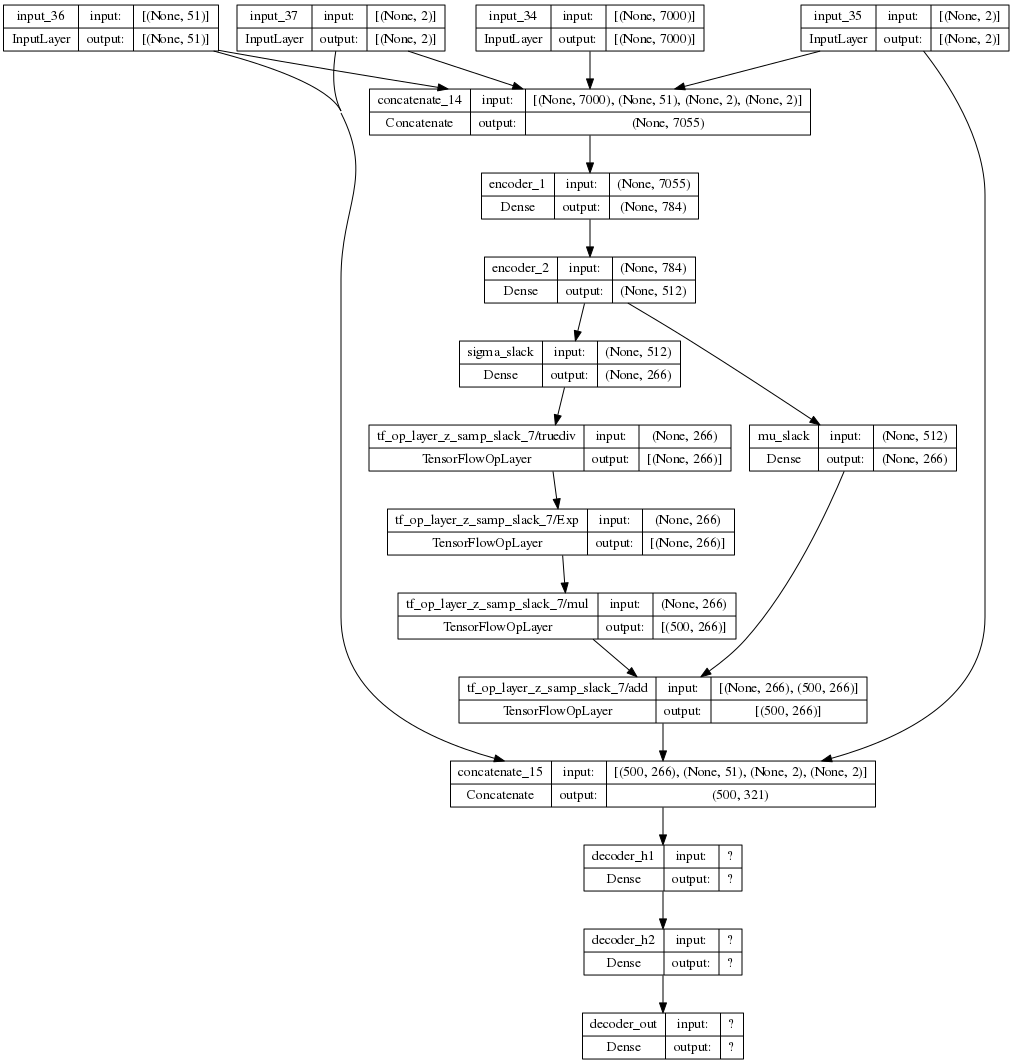

In [233]:
display(plot_model(cvae, show_layer_names=True, show_shapes=True, dpi=72))

# **Training**

Here we train using both the known and unknown cell-type proportions.
The labeled data is repeated in order to match the dimension of the unlabeled data so that they have the same batch size.
This code is taken from https://github.com/bjlkeng/sandbox/blob/master/notebooks/vae-semi_supervised_learning/vae-m2-fit-mnist.ipynb

In [234]:
cvae.compile(optimizer=optim, loss=vae_loss, metrics = [recon_loss])

In [235]:
X_cvae.shape

(1849, 7000)

In [236]:
samp_idx = np.random.choice(X_unkp.shape[0], 10000, replace=True)

cvae_hist = cvae.fit([X_cvae[samp_idx], 
                      label_cvae[samp_idx], 
                      bulk_cvae[samp_idx], 
                      drug_cvae[samp_idx]], 
                      X_cvae[samp_idx], verbose = 1, batch_size=batch_size, epochs=n_epoch)

Train on 10000 samples
Epoch 1/100
10000/10000 [==============================] - 4s 387us/sample - loss: 29.8312 - recon_loss: 29.0377
Epoch 2/100
10000/10000 [==============================] - 4s 386us/sample - loss: 17.4877 - recon_loss: 16.9054
Epoch 3/100
10000/10000 [==============================] - 4s 378us/sample - loss: 10.2004 - recon_loss: 9.4871
Epoch 4/100
10000/10000 [==============================] - 4s 379us/sample - loss: 5.7249 - recon_loss: 4.9111
Epoch 5/100
10000/10000 [==============================] - 4s 375us/sample - loss: 4.0582 - recon_loss: 3.2350
Epoch 6/100
10000/10000 [==============================] - 4s 384us/sample - loss: 3.2923 - recon_loss: 2.4149
Epoch 7/100
10000/10000 [==============================] - 4s 374us/sample - loss: 2.7494 - recon_loss: 1.8529
Epoch 8/100
10000/10000 [==============================] - 4s 381us/sample - loss: 2.4190 - recon_loss: 1.5232
Epoch 9/100
10000/10000 [==============================] - 4s 373us/sample - loss: 2

Now train

In [237]:
cvae_hist.history.keys()

dict_keys(['loss', 'recon_loss'])

# Plot Loss Curves

In [238]:
# write out the loss for later plotting
# unpack the loss values
total_loss = cvae_hist.history['loss']
recon_loss = cvae_hist.history['recon_loss']



# make into a dataframe
loss_df = pd.DataFrame(data=total_loss, columns=['total_loss'])
loss_df['batch'] = [*range(len(total_loss))]
loss_df['recon_loss'] = recon_loss



In [239]:
loss_df

total_loss  batch  recon_loss
0    29.831152      0   29.037708
1    17.487730      1   16.905447
2    10.200418      2    9.487052
3     5.724937      3    4.911140
4     4.058239      4    3.235046
..         ...    ...         ...
95    0.418365     95    0.111631
96    0.417611     96    0.112285
97    0.414393     97    0.110246
98    0.408295     98    0.105248
99    0.404239     99    0.103368

[100 rows x 3 columns]

In [240]:
def read_loss_file(res_path, exp_id, unlab_id):
    loss_file = os.path.join(res_path, f"train-{exp_id}-{unlab_id}-DIVA_loss.pkl")
    loss_path = Path(loss_file)
    loss_df = pickle.load( open( loss_path, "rb" ) )
    return loss_df

def make_loss_fig(loss_df, ax, title, loss_to_plot):
    ## plot loss
    g = sns.lineplot(
        x="batch", y=loss_to_plot,
        data=loss_df,
        legend="full",
        alpha=0.3, ax= ax
    )
    ax.set_title(title)
    return g

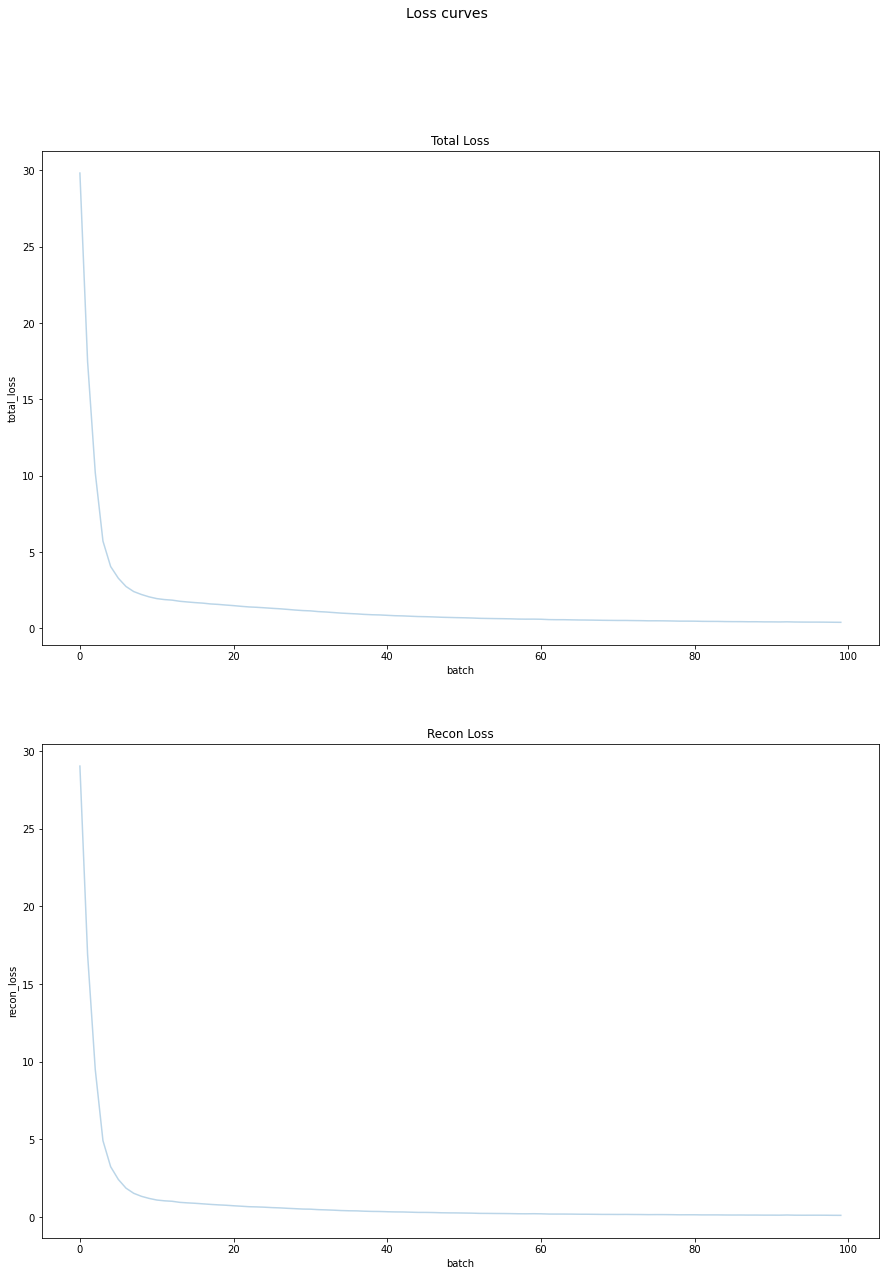

In [241]:

# add the log to make it easier to plot
loss_df["log_total_loss"] = np.log10(loss_df["total_loss"]+1)
loss_df["log_recon_loss"] = np.log10(loss_df["recon_loss"]+1)


fig, axs = plt.subplots(2, figsize=(15,20))

make_loss_fig(loss_df, ax=axs[0], title=f"Total Loss", loss_to_plot="total_loss")
make_loss_fig(loss_df, ax=axs[1], title=f"Recon Loss", loss_to_plot="recon_loss")


fig.suptitle("Loss curves", fontsize=14)

fig.show()

In [242]:
def plot_cell_specific_corr(xval, yval, ax, title, xlab, ylab, class_id):

    plot_df = pd.DataFrame(list(zip(xval, yval)))
    plot_df.columns = [xlab, ylab]

    g = sns.scatterplot(
        x=xlab, y=ylab,
        data=plot_df,ax=ax,
        hue=class_id
    )
    g.set(ylim=(0, 1))
    g.set(xlim=(0, 1))
    g.plot([0, 1], [0, 1], transform=g.transAxes)

    ax.set_title(title)
    return g


def read_bp_result_file(res_path, train_id, test_id, num_samp=1000):
    res_file = os.path.join(res_path, f"train-{train_id}-test-{test_id}-bp_{num_samp}_init.tsv")
    res_df = pd.read_csv(res_file, sep="\t")
    return res_df

def read_bp_init_file(res_path, train_id, test_id, num_samp=1000):
    res_file = os.path.join(res_path, f"train-{train_id}-test-{test_id}-bp_{num_samp}_init.tsv")
    res_df = pd.read_csv(res_file, sep="\t")
    return res_df


# **Inspect the output**

## TSNE training data

Now that we know what is expected, let's see what we get from the model. We find that out of our encoder, after applying ReLU, we get pretty close to the expected proportions.

## Plot Reconstruction

In [243]:
Label_full.shape

(3649,)

In [244]:

X_temp = np.copy(X_full)


label_temp = np.copy(label_full)
perturb_temp = drug_full
bulk_temp = bulk_full

recon_idx = np.where(meta_df.isTraining == "Train")[0]
recon_idx = np.random.choice(recon_idx, 5000, replace=True)


Y_temp = np.copy(Y_full.iloc[recon_idx])
Y_temp = np.argmax(Y_temp, axis=1)

label_temp = label_temp[recon_idx]
perturb_temp = perturb_temp[recon_idx]
bulk_temp = bulk_temp[recon_idx]
label_num = np.copy(Label_full)
label_num = label_num[recon_idx]

# now use the encoder to get the latent spaces
X_temp = X_temp[recon_idx]

# now use the encoder to get the latent spaces
mu_slack = encoder.predict([X_temp, label_temp, bulk_temp, perturb_temp], batch_size=batch_size)

# now concatenate together
z_concat = np.hstack([mu_slack, label_temp, bulk_temp, perturb_temp])

# and decode
decoded_outputs = decoder.predict(z_concat, batch_size=batch_size)




/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(10000, 2)
(10000, 2)


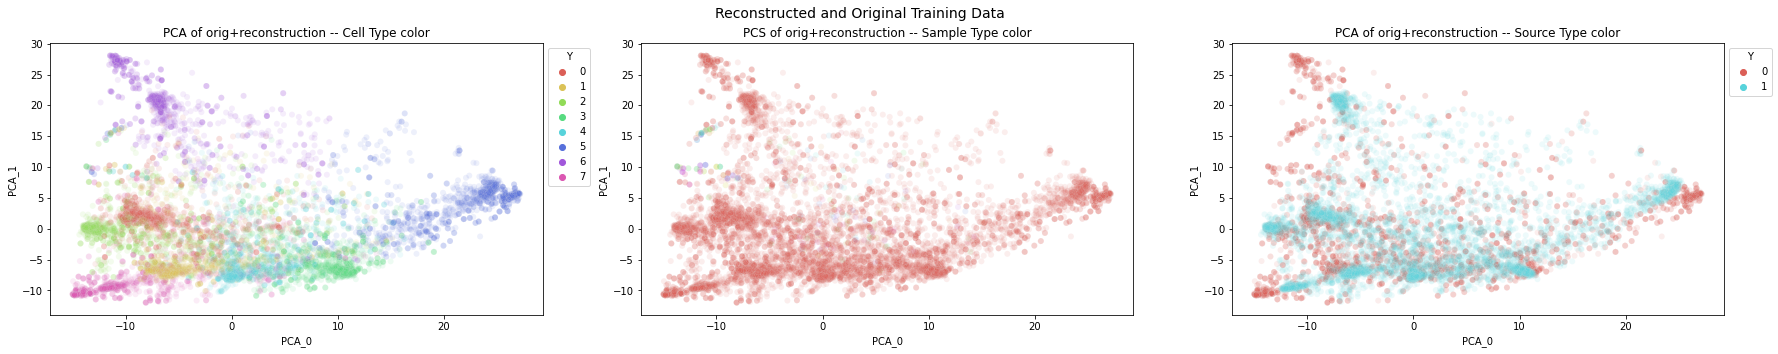

In [245]:
# make duplicated
X_dup = np.vstack([X_temp, decoded_outputs])



Y_dup = np.append(Y_temp, Y_temp)


label_dup = np.append(label_num, label_num)
perturb_dup = np.append(perturb_temp, perturb_temp)
source_dup = np.asarray(np.append([0]*len(perturb_temp), [1]*len(perturb_temp)))

fig, axs = plt.subplots(1, 3, figsize=(30,5))

plot_df = vp.get_pca_for_plotting(np.asarray(X_dup))
vp.plot_pca(plot_df, color_vec=Y_dup, ax=axs[0], title="PCA of orig+reconstruction -- Cell Type color")
vp.plot_pca(plot_df, color_vec=label_dup, ax=axs[1], title="PCS of orig+reconstruction -- Sample Type color")
vp.plot_pca(plot_df, color_vec=source_dup, ax=axs[2], title="PCA of orig+reconstruction -- Source Type color")



fig.suptitle("Reconstructed and Original Training Data", fontsize=14)
axs[1].legend([],[], frameon=False)

fig.show()

In [246]:

X_temp = np.copy(X_full)


label_temp = np.copy(label_full)
perturb_temp = drug_full
bulk_temp = bulk_full

recon_idx = np.where(meta_df.isTraining == "Test")[0]
recon_idx = np.random.choice(recon_idx, 5000, replace=True)


Y_temp = np.copy(Y_full.iloc[recon_idx])
Y_temp = np.argmax(Y_temp, axis=1)

label_temp = label_temp[recon_idx]
perturb_temp = perturb_temp[recon_idx]
bulk_temp = bulk_temp[recon_idx]
label_num = np.copy(Label_full)
label_num = label_num[recon_idx]

# now use the encoder to get the latent spaces
X_temp = X_temp[recon_idx]

# now use the encoder to get the latent spaces
mu_slack = encoder.predict([X_temp, label_temp, bulk_temp, perturb_temp], batch_size=batch_size)

# now concatenate together
z_concat = np.hstack([mu_slack, label_temp, bulk_temp, perturb_temp])

# and decode
decoded_outputs = decoder.predict(z_concat, batch_size=batch_size)




(10000, 2)
(10000, 2)


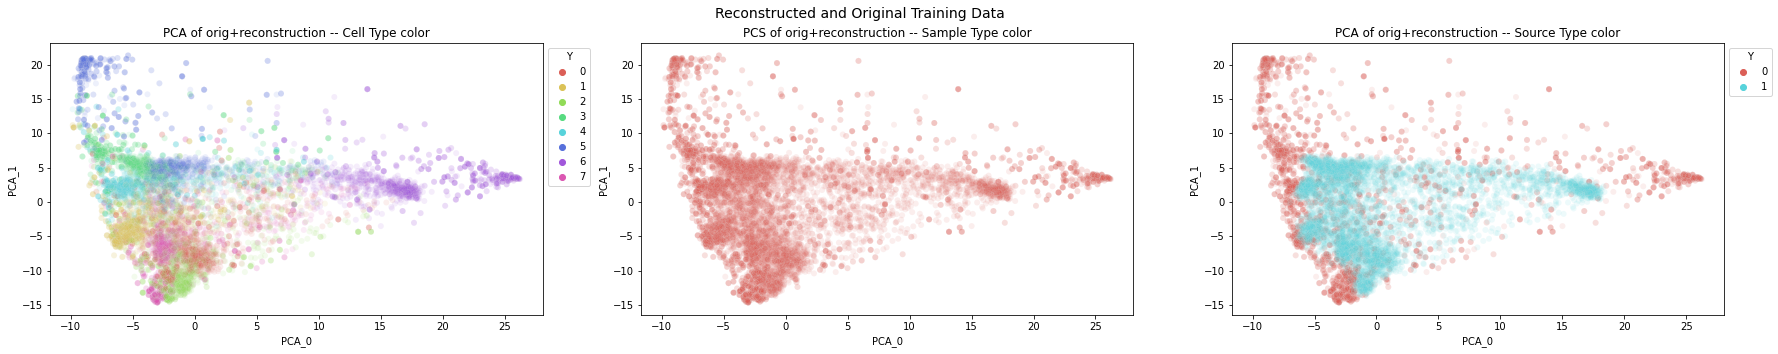

In [247]:
# make duplicated
X_dup = np.vstack([X_temp, decoded_outputs])



Y_dup = np.append(Y_temp, Y_temp)


label_dup = np.append(label_num, label_num)
perturb_dup = np.append(perturb_temp, perturb_temp)
source_dup = np.asarray(np.append([0]*len(perturb_temp), [1]*len(perturb_temp)))

fig, axs = plt.subplots(1, 3, figsize=(30,5))

plot_df = vp.get_pca_for_plotting(np.asarray(X_dup))
vp.plot_pca(plot_df, color_vec=Y_dup, ax=axs[0], title="PCA of orig+reconstruction -- Cell Type color")
vp.plot_pca(plot_df, color_vec=label_dup, ax=axs[1], title="PCS of orig+reconstruction -- Sample Type color")
vp.plot_pca(plot_df, color_vec=source_dup, ax=axs[2], title="PCA of orig+reconstruction -- Source Type color")



fig.suptitle("Reconstructed and Original Training Data", fontsize=14)
axs[1].legend([],[], frameon=False)

fig.show()

## Do latent space projectsions

### drug perturbation

In [32]:
from importlib import reload  # Python 3.4+
reload(sc_preprocess)
reload(vp)


<module 'method_comparison.validation_plotting' from '/beevol/home/davidson/checkouts/sc_bulk_ood/exploratory_experiments/../method_comparison/validation_plotting.py'>

In [283]:
def calc_CVAE_perturbation(X_full, meta_df, encoder, decoder, 
                           scaler, batch_size, 
                           label_1hot_full, bulk_1hot_full, drug_1hot_full):

    label_1hot_temp = np.copy(label_1hot_full)
    bulk_1hot_temp = np.copy(bulk_1hot_full)
    perturb_1hot_temp = np.copy(drug_1hot_full)


    # get the single cell data 
    idx_sc_ref = np.logical_and(meta_df.isTraining == "Train", meta_df.stim == "STIM")
    idx_sc_ref = np.where(meta_df.isTraining == "Train")[0]

    ## this is to match up sample amounts across comparators
    idx_sc_ref = np.random.choice(idx_sc_ref, 8000, replace=True) 


    X_sc_ref = np.copy(X_full)
    X_sc_ref = X_sc_ref[idx_sc_ref,]

    # get the sample_ids we will perturb
    sample_code = label_1hot_temp[idx_sc_ref]

    # make the metadata file
    ctrl_test_meta_df = meta_df.copy()
    ctrl_test_meta_df = ctrl_test_meta_df.iloc[idx_sc_ref]
    ctrl_test_meta_df.isTraining = "Test"
    ctrl_test_meta_df.stim = "CTRL"

    # get the bulk code
    bulk_code = bulk_1hot_full[idx_sc_ref]

    # get the perturb code
    idx_stim = np.where(meta_df.stim == "STIM")[0]
    idx_stim = np.random.choice(idx_stim, 8000, replace=True) 
    perturbed_code = perturb_1hot_temp[idx_stim]

    idx_ctrl = np.where(meta_df.stim == "CTRL")[0]
    idx_ctrl = np.random.choice(idx_stim, 8000, replace=True) 
    unperturbed_code = perturb_1hot_temp[idx_ctrl]


    mu_slack = encoder.predict([X_sc_ref, sample_code, bulk_code, perturbed_code], batch_size=batch_size)
    z_concat = np.hstack([mu_slack, sample_code, bulk_code, perturbed_code])
    decoded_0_1 = decoder.predict(z_concat, batch_size=batch_size)
    decoded_0_1 = scaler.inverse_transform(decoded_0_1)


    mu_slack = encoder.predict([X_sc_ref, sample_code, bulk_code, unperturbed_code], batch_size=batch_size)
    z_concat = np.hstack([mu_slack, sample_code, bulk_code, unperturbed_code])
    decoded_0_0 = decoder.predict(z_concat, batch_size=batch_size)
    decoded_0_0 = scaler.inverse_transform(decoded_0_0)

    return (ctrl_test_meta_df, decoded_0_0, decoded_0_1)


In [285]:

ctrl_test_meta_df, decoded_0_0, decoded_0_1 = calc_CVAE_perturbation(X_full, meta_df, encoder, decoder, 
                                                                        scaler, batch_size, 
                                                                        label_full, bulk_full, drug_full)

In [286]:
ctrl_test_meta_df

sample_id  stim isTraining      cell_prop_type samp_type  \
1014    30-M-5  CTRL       Test  cell_type_specific    sc_ref   
493     30-M-5  CTRL       Test              random    sc_ref   
867     30-M-5  CTRL       Test              random    sc_ref   
639     30-M-5  CTRL       Test              random    sc_ref   
527     30-M-5  CTRL       Test              random    sc_ref   
...        ...   ...        ...                 ...       ...   
55      30-M-5  CTRL       Test              random    sc_ref   
1754    30-M-5  CTRL       Test  cell_type_specific    sc_ref   
293     30-M-5  CTRL       Test              random    sc_ref   
408     30-M-5  CTRL       Test              random    sc_ref   
1413    30-M-5  CTRL       Test  cell_type_specific    sc_ref   

                  Y_max  
1014         hepatocyte  
493    hepatic_sinusoid  
867              b_cell  
639              b_cell  
527              b_cell  
...                 ...  
55     hepatic_stellate  
1754  myeloid_leukocyte  
293          hepatocyte  
408                  NK  
1413                 NK  

[8000 rows x 6 columns]

(16000, 2)
(16000, 2)


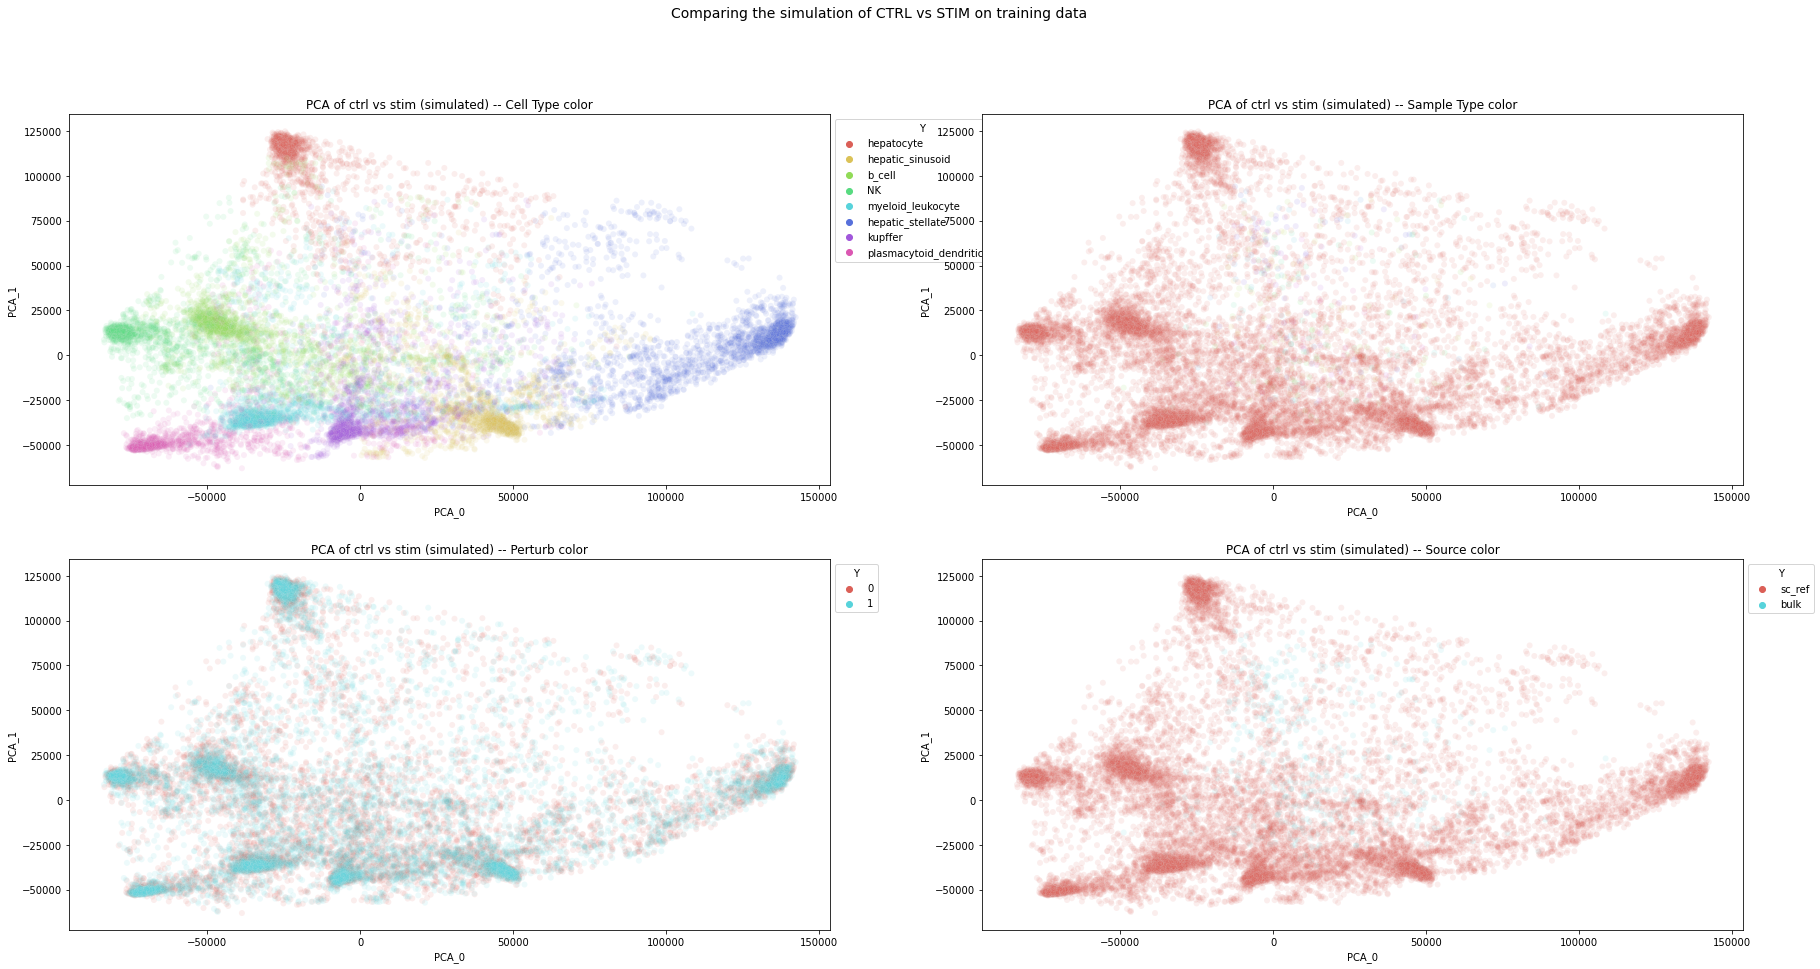

In [288]:
# make duplicated
X_dup = np.vstack([decoded_0_0, decoded_0_1])


Y_dup = np.append(ctrl_test_meta_df.Y_max, ctrl_test_meta_df.Y_max)


label_dup = np.append(ctrl_test_meta_df.sample_id, ctrl_test_meta_df.sample_id)

n_row_temp = ctrl_test_meta_df.shape[0]
perturb_dup = np.asarray(np.append([0]*n_row_temp, [1]*n_row_temp))
source_dup = np.append(ctrl_test_meta_df.samp_type, ctrl_test_meta_df.samp_type)

fig, axs = plt.subplots(2, 2, figsize=(30,15))

plot_df = vp.get_pca_for_plotting(np.asarray(X_dup))
vp.plot_pca(plot_df, color_vec=Y_dup, ax=axs[0,0], title="PCA of ctrl vs stim (simulated) -- Cell Type color")
vp.plot_pca(plot_df, color_vec=label_dup, ax=axs[0,1], title="PCA of ctrl vs stim (simulated) -- Sample Type color")
vp.plot_pca(plot_df, color_vec=perturb_dup, ax=axs[1,0], title="PCA of ctrl vs stim (simulated) -- Perturb color")
vp.plot_pca(plot_df, color_vec=source_dup, ax=axs[1,1], title="PCA of ctrl vs stim (simulated) -- SC/Bulk color")



fig.suptitle("Comparing the simulation of CTRL vs STIM on training data", fontsize=14)
axs[0,1].legend([],[], frameon=False)

fig.show()

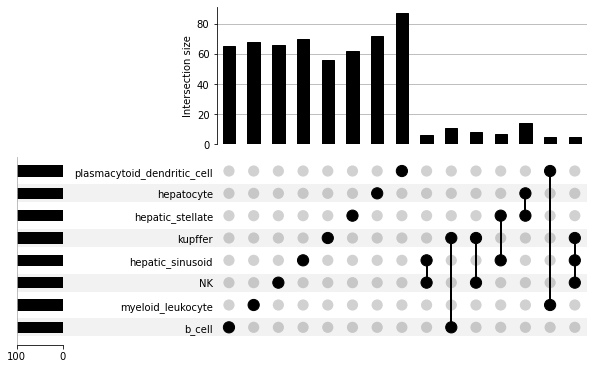

In [252]:
from scipy.stats import rankdata


top_lim = 100

top_genes = {}
de_genes_all = None
for curr_cell_type in Y_full.columns:


    # this is for the "projected" expression
    curr_idx = np.where(ctrl_test_meta_df.Y_max == curr_cell_type)[0]
    proj_ctrl = decoded_0_0[curr_idx]
    proj_stim = decoded_0_1[curr_idx]

    # take the median for nomalization

    proj_ctrl = np.median(rankdata(proj_ctrl, axis=1), axis=0)
    proj_stim = np.median(rankdata(proj_stim, axis=1), axis=0)
    #proj_ctrl = np.median(proj_ctrl, axis=0)
    #proj_stim = np.median(proj_stim, axis=0)
    proj_log2FC = np.abs(proj_stim-proj_ctrl)

    # make into DF
    proj_log2FC_df = pd.DataFrame(proj_log2FC, index=union_genes)

    intersect_proj = proj_log2FC_df.loc[union_genes][0]
    top_proj_genes = intersect_proj.index[np.argsort(np.abs(intersect_proj))].tolist()[::-1][0:top_lim]

    top_genes[curr_cell_type] = top_proj_genes


cell_diff = from_contents(top_genes)
ax_dict = UpSet(cell_diff, subset_size='count', orientation='horizontal', min_subset_size=5).plot()

#venn2([set(top_pub_genes), set(top_proj_genes)], set_labels = ('Top Pub Genes', 'Top Proj Genes'))
#plt.show()


In [265]:
top_genes["hepatocyte"]

['Srgap1',
 'Clstn3',
 'Hhip',
 'Lamb1',
 'Dagla',
 'Pde4c',
 'Pdgfrb',
 'Igsf10',
 'Mill2',
 'Ano1',
 'Srpx2',
 'Cadm3',
 'Rbms3',
 'Ngf',
 'Fam174b',
 'Rgs5',
 'Mlph',
 'Ggt5',
 'Fabp4',
 '9530026P05Rik',
 'Cyyr1',
 'Gdf6',
 'Adcy5',
 'Dcn',
 'Sema3f',
 'Hoxa5',
 'Abcg3',
 'Tmem88',
 'Ltc4s',
 'Dchs1',
 'Mansc1',
 'Tln2',
 'Cldn5',
 'Klrb1c',
 'Cyp4b1',
 'Nlrp1a',
 'Tspan18',
 'Cx3cl1',
 'Pamr1',
 'Clec1a',
 'Naalad2',
 'Pcdh17',
 'Ddr2',
 'Iglon5',
 'Plekhh2',
 'Slc26a10',
 'Klra17',
 'Fam180a',
 'Rasip1',
 'Acer2',
 'Ispd',
 'Siglech',
 'Podnl1',
 'Pth1r',
 'Ephb2',
 'Tbx2',
 'Ccdc136',
 'Ntm',
 'Tmem132e',
 'Rtn1',
 'Klrb1b',
 'Eps8',
 'Ctxn1',
 'Zfpm2',
 'Arhgap28',
 'Runx2',
 'Gdf10',
 'Sik2',
 'Ccl19',
 'Arhgef15',
 'Ms4a4d',
 'Zmynd15',
 'Ppfia2',
 'Lrrn3',
 'Cd93',
 'Flywch1',
 'Fgd5',
 'Ppp1r12b',
 'Lhfp',
 'Khdrbs3',
 'Frzb',
 'Plekha6',
 'Grid1',
 'Pgm5',
 'Cpz',
 'Cd40lg',
 'Cytip',
 'Gjc2',
 'Rgs9',
 'Myct1',
 'Col5a1',
 'Bace2',
 'Cdk14',
 'Arhgef10l',
 'Lpar1',
 'Ushbp

In [253]:
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error

def plot_effect_size_corr(xval, yval, ax, title, xlab, ylab, class_id, style_id, alpha=0.5):

    plot_df = pd.DataFrame(list(zip(xval, yval)))
    plot_df.columns = [xlab, ylab]

    g = sns.scatterplot(
        x=xlab, y=ylab,
        data=plot_df,ax=ax,
        hue=class_id,
        alpha= alpha,
        style=style_id
    )
    #g.set(ylim=(min_val, max_val))
    #g.set(xlim=(min_val, max_val))
    #g.plot([min_val, max_val], [min_val, max_val], transform=g.transAxes)
    sns.set_palette("Set2")

    ax.set_title(title)
    return g


In [255]:

union_genes_cap = [x.upper() for x in union_genes]

Pub_male_DE = ["CSMD1", "GALNT15", "NC_INTER_C14_25214", "NC_INTER_C19_31822", "NC_INTER_C6_41991", "NC_INTRA_C4_39314", "TRPC3", "APOE", "CLEC4A3", "HSD17B13", "ITIH4", "PIM3", "2310040G07RIK", "5330417C22RIK", "ACYP1", "ADAM11", "ADAMTS7", "AK4", "AMDHD2", "ANKRD31", "ARRDC3", "ASNS", "ATG16L2", "ATP8B4", "BMP7", "CAPN8", "CCDC146", "CDH2", "CIDEC", "CLN6", "CLSTN3", "CNNM1", "CRIM1", "CTSZ", "CYP1A2", "CYP2A5", "CYP2C55", "CYP2D12", "CYP2F2", "CYP2J9", "CYP3A59", "DDIT3", "DMAC2", "EPHB4", "ESCO2", "ESRRA", "ETNPPL", "EVA1A", "EXTL1", "F2RL2", "FBXO31", "FKBP11", "FST", "FTCD", "GAS2", "GBE1", "GDF15", "GM13238", "GM17090", "GM17276", "GM28172", "GM29650", "GM32250", "GM39325", "GM44623", "GM45051", "GM5930", "GSE1", "GSTA3", "GUCY2C", "GYS2", "HMOX1", "HNMT", "KCNK5", "KLHDC7A", "LMOD2", "LRP4", "MAB21L3", "MARCKSL1-PS4", "MEIG1", "MTNR1A", "MUP10", "MUP14", "MUP2", "MUP7", "NAT8", "NAT8F5", "NAT8F6", "NC_AS_C10_19571", "NC_AS_C10_8460", "NC_AS_C10_8856", "NC_AS_C10_9138", "NC_AS_C11_10136", "NC_AS_C11_21133", "NC_AS_C11_9866", "NC_AS_C12_10529", "NC_AS_C12_10778", "NC_AS_C13_11022", "NC_AS_C13_11425", "NC_AS_C13_23293", "NC_AS_C14_25013", "NC_AS_C15_12697", "NC_AS_C15_12848", "NC_AS_C15_12874", "NC_AS_C16_28194", "NC_AS_C17_13820", "NC_AS_C17_14024", "NC_AS_C17_29673", "NC_AS_C19_14844", "NC_AS_C19_15130", "NC_AS_C2_1233", "NC_AS_C2_1543", "NC_AS_C2_1778", "NC_AS_C2_1965", "NC_AS_C2_35105", "NC_AS_C3_2800", "NC_AS_C4_3532", "NC_AS_C4_3897", "NC_AS_C5_4051", "NC_AS_C5_41104", "NC_AS_C5_41479", "NC_AS_C5_41482", "NC_AS_C5_41483", "NC_AS_C5_4237", "NC_AS_C5_4257", "NC_AS_C5_4613", "NC_AS_C5_4719", "NC_AS_C6_43055", "NC_AS_C6_43544", "NC_AS_C6_4824", "NC_AS_C6_5604", "NC_AS_C6_5718", "NC_AS_C7_44087", "NC_AS_C7_45051", "NC_AS_C7_5921", "NC_AS_C7_5965", "NC_AS_C7_6065", "NC_AS_C7_6204", "NC_AS_C7_6377", "NC_AS_C8_46875", "NC_AS_C8_47354", "NC_AS_C8_7337", "NC_INTER_C1_1001", "NC_INTER_C1_166", "NC_INTER_C1_17618", "NC_INTER_C1_196", "NC_INTER_C1_274", "NC_INTER_C1_366", "NC_INTER_C1_406", "NC_INTER_C1_526", "NC_INTER_C1_588", "NC_INTER_C1_924", "NC_INTER_C1_931", "NC_INTER_C1_976", "NC_INTER_C10_17923", "NC_INTER_C10_19012", "NC_INTER_C10_19427", "NC_INTER_C10_19433", "NC_INTER_C10_19436", "NC_INTER_C10_19600", "NC_INTER_C10_8690", "NC_INTER_C10_8881", "NC_INTER_C10_9302", "NC_INTER_C10_9350", "NC_INTER_C11_10078", "NC_INTER_C11_10159", "NC_INTER_C11_10162", "NC_INTER_C11_10218", "NC_INTER_C11_19811", "NC_INTER_C11_20045", "NC_INTER_C11_20750", "NC_INTER_C11_20754", "NC_INTER_C11_21059", "NC_INTER_C11_21271", "NC_INTER_C11_21634", "NC_INTER_C12_10243", "NC_INTER_C12_10273", "NC_INTER_C12_10276", "NC_INTER_C12_10445", "NC_INTER_C12_10644", "NC_INTER_C12_10925", "NC_INTER_C12_21741", "NC_INTER_C12_21747", "NC_INTER_C12_21907", "NC_INTER_C12_22126", "NC_INTER_C13_11141", "NC_INTER_C13_11226", "NC_INTER_C13_11236", "NC_INTER_C13_11562", "NC_INTER_C13_23241", "NC_INTER_C13_23567", "NC_INTER_C14_12201", "NC_INTER_C14_25326", "NC_INTER_C14_25422", "NC_INTER_C14_25970", "NC_INTER_C15_12341", "NC_INTER_C15_26385", "NC_INTER_C15_26545", "NC_INTER_C15_26737", "NC_INTER_C15_27072", "NC_INTER_C15_27197", "NC_INTER_C15_27246", "NC_INTER_C15_27604", "NC_INTER_C15_27605", "NC_INTER_C16_13168", "NC_INTER_C16_13481", "NC_INTER_C16_28109", "NC_INTER_C16_28214", "NC_INTER_C16_28305", "NC_INTER_C16_28503", "NC_INTER_C17_13938", "NC_INTER_C17_14087", "NC_INTER_C17_14113", "NC_INTER_C17_29151", "NC_INTER_C17_29437", "NC_INTER_C17_29461", "NC_INTER_C18_30929", "NC_INTER_C18_31338", "NC_INTER_C18_31396", "NC_INTER_C19_14758", "NC_INTER_C19_14967", "NC_INTER_C19_15004", "NC_INTER_C19_15182", "NC_INTER_C19_31671", "NC_INTER_C19_32377", "NC_INTER_C19_32381", "NC_INTER_C19_32383", "NC_INTER_C19_32539", "NC_INTER_C2_1121", "NC_INTER_C2_1161", "NC_INTER_C2_2000", "NC_INTER_C2_33152", "NC_INTER_C2_33876", "NC_INTER_C3_2168", "NC_INTER_C3_2630", "NC_INTER_C3_2797", "NC_INTER_C3_2922", "NC_INTER_C3_2942", "NC_INTER_C3_35342", "NC_INTER_C3_35348", "NC_INTER_C3_35349", "NC_INTER_C3_35359", "NC_INTER_C3_35556", "NC_INTER_C3_36231", "NC_INTER_C3_36265", "NC_INTER_C3_37079", "NC_INTER_C3_37178", "NC_INTER_C4_3086", "NC_INTER_C4_3533", "NC_INTER_C4_3549", "NC_INTER_C4_3579", "NC_INTER_C4_3775", "NC_INTER_C4_37854", "NC_INTER_C4_38023", "NC_INTER_C4_38403", "NC_INTER_C4_38427", "NC_INTER_C4_38509", "NC_INTER_C4_39163", "NC_INTER_C5_39934", "NC_INTER_C5_40222", "NC_INTER_C5_4048", "NC_INTER_C5_4055", "NC_INTER_C5_40800", "NC_INTER_C5_41123", "NC_INTER_C5_41259", "NC_INTER_C5_41621", "NC_INTER_C5_4379", "NC_INTER_C5_4474", "NC_INTER_C5_4651", "NC_INTER_C5_4788", "NC_INTER_C5_4819", "NC_INTER_C6_41969", "NC_INTER_C6_41970", "NC_INTER_C6_5193", "NC_INTER_C6_5309", "NC_INTER_C6_5310", "NC_INTER_C6_5316", "NC_INTER_C6_5846", "NC_INTER_C6_5862", "NC_INTER_C7_43801", "NC_INTER_C7_43842", "NC_INTER_C7_43873", "NC_INTER_C7_44280", "NC_INTER_C7_45606", "NC_INTER_C7_45613", "NC_INTER_C7_45614", "NC_INTER_C7_6068", "NC_INTER_C7_6094", "NC_INTER_C7_6294", "NC_INTER_C7_6392", "NC_INTER_C7_6508", "NC_INTER_C7_6509", "NC_INTER_C7_6595", "NC_INTER_C8_45937", "NC_INTER_C8_47239", "NC_INTER_C8_47251", "NC_INTER_C8_6944", "NC_INTER_C8_7176", "NC_INTER_C8_7350", "NC_INTER_C8_7605", "NC_INTER_C8_7610", "NC_INTER_C9_48130", "NC_INTER_C9_48783", "NC_INTER_C9_49383", "NC_INTER_C9_7885", "NC_INTER_C9_7892", "NC_INTER_C9_8122", "NC_INTER_CX_49514", "NC_INTER_CX_50093", "NC_INTER_CX_50188", "NC_INTER_CY_50499", "NC_INTRA_C1_16454", "NC_INTRA_C16_28090", "NC_INTRA_C4_38600", "NHEJ1", "NRG4", "PAK6", "PAX8", "PCGF2", "PDGFA", "PELI3", "PFKFB3", "PKDREJ", "PKNOX2", "PLD6", "PPARGC1B", "PREX2", "PROCA1", "PTCH2", "PXYLP1", "R3HDML", "RAB3D", "RANBP17", "Ranbp3l", "RAP2A", "RBMS2", "RENBP", "RIBC1", "RIPOR2", "RPS6KA1", "RUNDC3B", "SCARB1", "SCN1B", "SEC22C", "SERPINA12", "SERPINE2", "SH3BGRL2", "SH3RF1", "SIPA1L2", "SLC18A2", "SLC22A22", "SLC22A4", "SLC24A5", "SLC2A5", "SLC35E3", "SPAG16", "SULT2A8", "SUSD4", "TAFA2", "TC2N", "THRSP", "TIMM9", "TOMM40L", "TRIB3", "TXNDC5", "VCL", "VEGFD", "WNK4", "ZBTB12", "ZFR2", "ABCB1B", "ANK1", "APBA2", "BDH2", "BDNF", "BID", "BIRC5", "BMP4", "BRINP3", "CCDC151", "CCDC152", "CCDC158", "CERS5", "COL4A2", "CRYM", "DAB1", "DNAH8", "ENPP3", "EPB41L1", "EPHB6", "EZR", "GAL3ST1", "GM10701", "GM14146", "GRM7", "GTSE1", "HS1BP3", "HSD3B2", "IHH", "KEG1", "LRRC14B", "METTL7A1", "MUP1", "MUP11", "NC_AS_C1_16117", "NC_AS_C1_221", "NC_AS_C10_9290", "NC_AS_C10_9351", "NC_AS_C11_10168", "NC_AS_C11_10193", "NC_AS_C11_10227", "NC_AS_C13_11185", "NC_AS_C14_11991", "NC_AS_C14_12074", "NC_AS_C14_12111", "NC_AS_C2_33533", "NC_AS_C4_3824", "NC_AS_C7_6162", "NC_INTER_C1_1038", "NC_INTER_C1_15751", "NC_INTER_C1_17121", "NC_INTER_C10_18779", "NC_INTER_C10_8745", "NC_INTER_C10_8846", "NC_INTER_C11_10211", "NC_INTER_C11_10213", "NC_INTER_C11_19797", "NC_INTER_C11_9434", "NC_INTER_C12_10431", "NC_INTER_C13_11090", "NC_INTER_C13_23303", "NC_INTER_C13_24436", "NC_INTER_C14_11858", "NC_INTER_C14_11989", "NC_INTER_C14_24999", "NC_INTER_C15_12954", "NC_INTER_C15_27082", "NC_INTER_C16_13185", "NC_INTER_C16_13421", "NC_INTER_C16_28146", "NC_INTER_C17_13568", "NC_INTER_C17_14025", "NC_INTER_C18_14330", "NC_INTER_C19_14874", "NC_INTER_C3_2413", "NC_INTER_C3_2733", "NC_INTER_C3_2895", "NC_INTER_C3_35370", "NC_INTER_C3_35424", "NC_INTER_C4_3471", "NC_INTER_C4_3794", "NC_INTER_C4_38029", "NC_INTER_C4_38331", "NC_INTER_C4_38853", "NC_INTER_C5_39709", "NC_INTER_C5_41620", "NC_INTER_C6_42157", "NC_INTER_C6_42580", "NC_INTER_C6_43331", "NC_INTER_C6_43700", "NC_INTER_C6_4868", "NC_INTER_C7_43894", "NC_INTER_C7_43994", "NC_INTER_C7_44119", "NC_INTER_C7_44889", "NC_INTER_C7_5922", "NC_INTER_C7_6558", "NC_INTER_C8_46126", "NC_INTER_C8_47237", "NC_INTER_C8_47241", "NC_INTER_C8_7259", "NC_INTER_C8_7273", "NC_INTER_C9_47875", "NC_INTER_C9_49372", "NC_INTER_CX_50211", "NC_INTRA_C12_22588", "NC_INTRA_C3_2640", "NC_INTRA_C3_35408", "NC_INTRA_C5_4750", "NCAM2", "P2RX4", "PDE6A", "PER3", "PGP", "PIP5K1B", "PLCB4", "PLEKHF1", "POGK", "PPFIA3", "PPP1R42", "PRDM16", "RNF227", "SEL1L3", "SELENBP2", "SLC12A3", "SLC39A11", "SLC8A3", "SPACA6", "STEAP4", "TLE3", "TMEM19", "TNFSF15", "TRHDE", "TTC7B", "UGT2B36", "UNC119", "VMN2R22", "XLR3A", "ZFP37", "ZYG11A", "ADAMTSL2", "NC_INTER_C2_33847", "OLFR39", "OLFR872", "PLXDC2", "MYO5A", "NC_INTER_C11_10188", "1600014C10RIK", "1810064F22RIK", "2610507I01RIK", "A930033H14RIK", "AA986860", "ABCG2", "ABCG8", "ADGRV1", "ADORA1", "AKR1C19", "ALAS2", "ALPL", "ANG4", "AOX1", "AOX3", "ARL3", "ARSA", "BCL6", "BHLHE41", "C6", "C8A", "C8B", "C9", "CABYR", "CAMK2B", "CAR3", "CDC42EP1", "CES1F", "CFAP53", "CHPT1", "CHRM3", "CIART", "CIB3", "CLEC2H", "COL27A1", "COL5A3", "CREG1", "CRYL1", "CSAD", "CSPG5", "CTSE", "CXCL1", "CYP2C23", "CYP2D9", "CYP2U1", "CYP3A25", "CYP4A12A", "CYP4A12B", "DBP", "DDX3Y", "DIO1", "DSG1C", "EIF2S3Y", "ELOVL3", "ENPP6", "EPHX1", "FAM171B", "FHITOS", "FITM1", "FMO5", "FTL1", "GCK", "GCLC", "GM11967", "GM19951", "Gm21064", "GM34408", "GM38102", "GM39469", "GM47551", "GNA14", "GPR155", "GSTA2", "GSTM1", "GSTP1", "HAMP", "HERPUD1", "HES6", "HSD3B5", "IL1R1", "IL1RAP", "KDM5D", "KLF13", "LAMA3", "LNC-LFAR1", "LOC102631993", "LPL", "MAP2K6", "MAPK4", "MBD1", "MBNL2", "MCM10", "MN1", "MT1", "MTHFD1L", "MUP12", "MUP13", "MUP16", "MUP17", "MUP20", "MUP21", "Mup22", "MUP3", "MUP9", "NAT8F2", "NC_AS_C1_103", "NC_AS_C1_16455", "NC_AS_C1_222", "NC_AS_C1_252", "NC_AS_C1_367", "NC_AS_C1_419", "NC_AS_C1_645", "NC_AS_C10_18831", "NC_AS_C11_10090", "NC_AS_C11_20789", "NC_AS_C12_10800", "NC_AS_C13_23641", "NC_AS_C15_12340", "NC_AS_C15_12817", "NC_AS_C15_12818", "NC_AS_C17_13708", "NC_AS_C17_13924", "NC_AS_C17_29511", "NC_AS_C18_14287", "NC_AS_C18_14596", "NC_AS_C19_14823", "NC_AS_C2_1101", "NC_AS_C2_1339", "NC_AS_C3_2474", "NC_AS_C3_2633", "NC_AS_C3_2894", "NC_AS_C4_3288", "NC_AS_C4_3297", "NC_AS_C4_3300", "NC_AS_C4_3559", "NC_AS_C4_38502", "NC_AS_C5_41477", "NC_AS_C5_41478", "NC_AS_C5_41480", "NC_AS_C6_5601", "NC_AS_C7_6100", "NC_AS_C7_6302", "NC_AS_C8_7331", "NC_AS_C8_7359", "NC_AS_C9_48159", "NC_AS_CX_15436", "NC_INTER_C1_15752", "NC_INTER_C1_17117", "NC_INTER_C1_17119", "NC_INTER_C1_365", "NC_INTER_C1_630", "NC_INTER_C1_636", "NC_INTER_C10_18780", "NC_INTER_C10_18890", "NC_INTER_C10_19650", "NC_INTER_C10_8999", "NC_INTER_C10_9000", "NC_INTER_C10_9349", "NC_INTER_C11_10109", "NC_INTER_C11_10215", "NC_INTER_C11_20471", "NC_INTER_C11_21358", "NC_INTER_C11_21411", "NC_INTER_C11_9924", "NC_INTER_C11_9926", "NC_INTER_C12_10419", "NC_INTER_C12_10423", "NC_INTER_C12_10462", "NC_INTER_C12_10973", "NC_INTER_C13_11221", "NC_INTER_C13_11665", "NC_INTER_C13_11669", "NC_INTER_C13_11670", "NC_INTER_C13_11769", "NC_INTER_C13_23227", "NC_INTER_C13_24759", "NC_INTER_C14_11820", "NC_INTER_C14_12199", "NC_INTER_C14_25003", "NC_INTER_C14_25517", "NC_INTER_C15_12324", "NC_INTER_C15_12436", "NC_INTER_C15_26512", "NC_INTER_C15_27100", "NC_INTER_C15_27619", "NC_INTER_C16_13211", "NC_INTER_C16_27915", "NC_INTER_C17_13939", "NC_INTER_C17_13983", "NC_INTER_C17_13987", "NC_INTER_C17_14010", "NC_INTER_C17_30317", "NC_INTER_C17_30318", "NC_INTER_C18_14328", "NC_INTER_C18_14341", "NC_INTER_C18_30753", "NC_INTER_C18_30760", "NC_INTER_C18_30872", "NC_INTER_C18_31487", "NC_INTER_C19_14746", "NC_INTER_C19_14822", "NC_INTER_C19_14873", "NC_INTER_C19_31686", "NC_INTER_C19_31755", "NC_INTER_C2_33077", "NC_INTER_C2_33519", "NC_INTER_C2_33955", "NC_INTER_C2_34787", "NC_INTER_C2_35077", "NC_INTER_C3_2156", "NC_INTER_C3_2410", "NC_INTER_C3_2411", "NC_INTER_C3_2504", "NC_INTER_C3_2988", "NC_INTER_C3_35415", "NC_INTER_C3_36176", "NC_INTER_C3_36400", "NC_INTER_C3_36463", "NC_INTER_C3_36914", "NC_INTER_C3_37077", "NC_INTER_C3_37078", "NC_INTER_C4_3468", "NC_INTER_C4_37486", "NC_INTER_C4_38016", "NC_INTER_C4_38021", "NC_INTER_C4_38024", "NC_INTER_C4_38026", "NC_INTER_C4_38027", "NC_INTER_C4_38028", "NC_INTER_C4_38488", "NC_INTER_C4_38503", "NC_INTER_C4_38506", "NC_INTER_C4_39237", "NC_INTER_C5_40535", "NC_INTER_C5_40777", "NC_INTER_C5_40778", "NC_INTER_C5_41212", "NC_INTER_C5_41624", "NC_INTER_C5_4376", "NC_INTER_C5_4405", "NC_INTER_C5_4464", "NC_INTER_C5_4467", "NC_INTER_C5_4616", "NC_INTER_C5_4639", "NC_INTER_C6_41966", "NC_INTER_C6_43708", "NC_INTER_C6_4887", "NC_INTER_C6_5025", "NC_INTER_C6_5277", "NC_INTER_C6_5551", "NC_INTER_C6_5711", "NC_INTER_C6_5864", "NC_INTER_C7_43892", "NC_INTER_C7_44316", "NC_INTER_C7_44356", "NC_INTER_C7_44357", "NC_INTER_C7_45335", "NC_INTER_C7_6073", "NC_INTER_C7_6074", "NC_INTER_C7_6076", "NC_INTER_C8_46989", "NC_INTER_C8_46996", "NC_INTER_C8_47253", "NC_INTER_C8_6876", "NC_INTER_C8_6981", "NC_INTER_C8_6984", "NC_INTER_C8_6985", "NC_INTER_C8_6990", "NC_INTER_C8_7178", "NC_INTER_C8_7179", "NC_INTER_C8_7180", "NC_INTER_C8_7423", "NC_INTER_C9_48844", "NC_INTER_C9_49223", "NC_INTER_CX_15266", "NC_INTER_CX_15297", "NC_INTER_CX_15444", "NC_INTER_CX_15445", "NC_INTER_CX_15448", "NC_INTER_CX_15450", "NC_INTER_CX_50094", "NC_INTER_CX_50215", "NC_INTER_CX_50216", "NC_INTER_CX_50217", "NC_INTER_CY_15553", "NC_INTER_CY_50477", "NC_INTER_CY_50479", "NC_INTER_CY_50484", "NC_INTER_CY_50485", "NC_INTRA_C15_27471", "NC_INTRA_C17_13875", "NC_INTRA_C18_30761", "NC_INTRA_C2_34452", "NC_INTRA_C3_2638", "NC_INTRA_C4_37977", "NC_INTRA_CX_15428", "NC_INTRA_CX_15430", "NOX4", "NR1D1", "NUDT7", "NUGGC", "NYAP2", "OLFM2", "OSBPL3", "OSBPL5", "PARD3B", "PARD3BOS1", "PDGFRL", "PER1", "PIM1", "POLR3H", "PRSS22", "RABAC1", "RASSF3", "RGS16", "SAA4", "SCARA5", "SCP2", "SGIP1", "SLC15A5", "SLC17A8", "SLC22A28", "SNHG3", "SNTB2", "SORBS2OS", "SPATC1L", "SRD5A1", "STBD1", "STON2", "SYCP3", "TDO2", "TMC7", "TMEM181A", "TRAF5", "TRPM3", "TSKU", "TTC39C", "UGDH", "UGT1A9", "UGT2B35", "UGT2B38", "UGT2B5", "UPP2", "USP2", "UTY", "WDR86", "WEE1", "XDH", "XLR3B", "ZFP951", "NC_INTER_C12_22790"]

Pub_female_DE = ["CYP26B1", "KITL", "LSAMP", "NC_INTER_C10_19273", "NC_INTER_C10_8794", "NC_INTER_C5_4220", "2510009E07RIK", "9330182L06RIK", "ACAT2", "ACLY", "ACSL3", "ACSL5", "ADAMTS12", "ADAMTS14", "ADGRF1", "AIG1", "ALB", "ALPK1", "ANKRD55", "ARAP2", "ARHGAP24", "ASB2", "ATP2B2", "BTBD19", "CAMKK2", "CAMKMT", "CAPRIN2", "CCND1", "CD83", "CERKL", "CISH", "CLCN6", "COBL", "CYP39A1", "CYP3A57", "DDX59", "DDX60", "DHCR7", "DIPK1C", "DLGAP1", "DNMT3B", "DOCK10", "E130311K13RIK", "ECT2", "EGR1", "EHHADH", "EIF2S3X", "ENTPD8", "EVC2", "FABP5", "FAM110B", "FAM126A", "FAM3C", "FAP", "FDFT1", "FHL3", "GABRG3", "GM15611", "GM15818", "Gm32856", "GM41225", "GM4952", "GM609", "GNGT1", "H2-K1", "HSPA4L", "HSPH1", "IGSF23", "ILDR2", "INHBA", "INSIG1", "IRF5", "KLHL13", "LIPC", "LMO3", "MFSD2A", "MLLT3", "MMAB", "MSMO1", "MTMR11", "MVK", "NAIP2", "NC_AS_C1_92", "NC_AS_C11_19879", "NC_AS_C12_10697", "NC_AS_C13_11784", "NC_AS_C16_13515", "NC_AS_C17_29799", "NC_AS_C19_14977", "NC_AS_C19_31812", "NC_AS_C2_1343", "NC_AS_C2_1899", "NC_AS_C2_32850", "NC_AS_C5_40250", "NC_AS_C7_43867", "NC_AS_C8_47096", "NC_AS_C9_48148", "NC_AS_C9_7776", "NC_AS_C9_8100", "NC_INTER_C1_17338", "NC_INTER_C1_17496", "NC_INTER_C1_17500", "NC_INTER_C1_325", "NC_INTER_C1_444", "NC_INTER_C1_454", "NC_INTER_C1_48", "NC_INTER_C1_53", "NC_INTER_C1_591", "NC_INTER_C10_18315", "NC_INTER_C10_18327", "NC_INTER_C10_19387", "NC_INTER_C10_8711", "NC_INTER_C10_8776", "NC_INTER_C10_9199", "NC_INTER_C10_9202", "NC_INTER_C10_9203", "NC_INTER_C10_9224", "NC_INTER_C10_9422", "NC_INTER_C11_9555", "NC_INTER_C11_9734", "NC_INTER_C11_9999", "NC_INTER_C12_10312", "NC_INTER_C12_10335", "NC_INTER_C12_10347", "NC_INTER_C12_10367", "NC_INTER_C12_10931", "NC_INTER_C12_22068", "NC_INTER_C13_11030", "NC_INTER_C13_11070", "NC_INTER_C13_11074", "NC_INTER_C13_23471", "NC_INTER_C13_23472", "NC_INTER_C13_23473", "NC_INTER_C13_23474", "NC_INTER_C13_24552", "NC_INTER_C13_24647", "NC_INTER_C14_11945", "NC_INTER_C14_12281", "NC_INTER_C14_25241", "NC_INTER_C15_12564", "NC_INTER_C15_12565", "NC_INTER_C15_12589", "NC_INTER_C15_12609", "NC_INTER_C15_12630", "NC_INTER_C15_12632", "NC_INTER_C15_12956", "NC_INTER_C15_26283", "NC_INTER_C15_27540", "NC_INTER_C16_27879", "NC_INTER_C17_29578", "NC_INTER_C18_14398", "NC_INTER_C18_30857", "NC_INTER_C19_15067", "NC_INTER_C19_31735", "NC_INTER_C2_1421", "NC_INTER_C2_1422", "NC_INTER_C2_1423", "NC_INTER_C2_1426", "NC_INTER_C2_1502", "NC_INTER_C2_1781", "NC_INTER_C2_1933", "NC_INTER_C2_1938", "NC_INTER_C2_1958", "NC_INTER_C2_33603", "NC_INTER_C2_34512", "NC_INTER_C3_2140", "NC_INTER_C3_2161", "NC_INTER_C3_2162", "NC_INTER_C3_2165", "NC_INTER_C3_2166", "NC_INTER_C3_35361", "NC_INTER_C4_3119", "NC_INTER_C4_3120", "NC_INTER_C4_3138", "NC_INTER_C4_3291", "NC_INTER_C4_3651", "NC_INTER_C4_37561", "NC_INTER_C4_38003", "NC_INTER_C4_3935", "NC_INTER_C4_3936", "NC_INTER_C5_39578", "NC_INTER_C5_4008", "NC_INTER_C5_4065", "NC_INTER_C5_41475", "NC_INTER_C5_4336", "NC_INTER_C5_4367", "NC_INTER_C5_4681", "NC_INTER_C6_41674", "NC_INTER_C6_43593", "NC_INTER_C6_43599", "NC_INTER_C6_5023", "NC_INTER_C6_5626", "NC_INTER_C6_5687", "NC_INTER_C6_5744", "NC_INTER_C6_5751", "NC_INTER_C6_5782", "NC_INTER_C6_5794", "NC_INTER_C6_5799", "NC_INTER_C6_5803", "NC_INTER_C6_5805", "NC_INTER_C6_5808", "NC_INTER_C6_5810", "NC_INTER_C7_43881", "NC_INTER_C7_43883", "NC_INTER_C7_43999", "NC_INTER_C7_6011", "NC_INTER_C7_6118", "NC_INTER_C7_6269", "NC_INTER_C8_46098", "NC_INTER_C8_6826", "NC_INTER_C8_7286", "NC_INTER_C9_48997", "NC_INTER_C9_7992", "NC_INTER_C9_8044", "NC_INTER_C9_8104", "NC_INTER_C9_8147", "NC_INTER_CX_15245", "NC_INTER_CX_49475", "NC_INTER_CX_49493", "NC_INTER_CX_50203", "NC_INTRA_C10_18641", "NC_INTRA_C11_21509", "NC_INTRA_C17_13887", "NC_INTRA_C17_14049", "NC_INTRA_C17_14052", "NC_INTRA_C17_14059", "NC_INTRA_C8_7686", "NC_INTRA_C9_48616", "NEB", "NHS", "NODAL", "NREP", "NXN", "OPHN1", "P2RY4", "PAK7", "PCK1", "PIGR", "PLCE1", "PLD1", "PLPP1", "PPARGC1A", "PTPRM", "PYGB", "RASSF4", "RBP1", "RECK", "REEP1", "RRAGB", "RTN4", "SC5D", "SCAP", "SHANK2", "SKI", "SLC22A7", "SLC24A3", "SLC25A27", "SLC9A9", "SPRED1", "SRL", "ST6GALNAC3", "SULT2A6", "TEAD1", "TET2", "TGM1", "TGTP1", "TM7SF2", "Tmem267", "TOB1", "TRPM6", "TSC22D4", "TSPAN15", "Ulbp1", "USH2A", "XAF1", "ZBTB7C", "ZFP292", "ZFP583", "ZFP641", "ZFP933", "ZFP982", "ABLIM3", "ADAMTS17", "ADAMTSL1", "ALDH3A2", "AOC1", "AR", "ARRB1", "AVPR1A", "BHMT", "BTG2", "CC2D2A", "CENPH", "CTH", "CYP17A1", "CYP2A22", "CYP2B10", "CYP7A1", "DCDC2A", "DCT", "DUSP1", "EGFL7", "ENOX1", "FBXL7", "GM15622", "GPCPD1", "GPX7", "GSTT3", "HEXB", "HSD3B1", "IGFBP2", "IGFBP3", "IQCG", "KCNB2", "KLB", "LDB2", "LECT2", "LGALS9", "LGR5", "LPIN1", "LRATD2", "MAS1", "MKX", "NC_AS_C1_18", "NC_AS_C11_21353", "NC_AS_C12_10922", "NC_AS_C14_26179", "NC_AS_C17_30442", "NC_AS_C19_32266", "NC_AS_C4_3033", "NC_AS_C4_3841", "NC_AS_C5_4370", "NC_AS_C6_5340", "NC_AS_C7_44810", "NC_AS_C7_6288", "NC_AS_C9_7752", "NC_INTER_C1_15603", "NC_INTER_C1_16178", "NC_INTER_C1_16243", "NC_INTER_C10_19563", "NC_INTER_C10_9362", "NC_INTER_C11_19823", "NC_INTER_C11_19975", "NC_INTER_C11_19981", "NC_INTER_C11_20507", "NC_INTER_C11_20981", "NC_INTER_C11_21019", "NC_INTER_C11_9624", "NC_INTER_C11_9778", "NC_INTER_C12_10621", "NC_INTER_C12_22906", "NC_INTER_C13_11189", "NC_INTER_C13_11200", "NC_INTER_C13_23469", "NC_INTER_C13_23766", "NC_INTER_C13_24734", "NC_INTER_C14_12181", "NC_INTER_C14_26121", "NC_INTER_C15_12600", "NC_INTER_C15_12685", "NC_INTER_C15_26840", "NC_INTER_C15_26848", "NC_INTER_C15_27404", "NC_INTER_C16_13232", "NC_INTER_C16_13329", "NC_INTER_C16_27725", "NC_INTER_C18_14356", "NC_INTER_C18_14373", "NC_INTER_C18_31434", "NC_INTER_C19_14947", "NC_INTER_C19_15023", "NC_INTER_C19_32418", "NC_INTER_C19_32427", "NC_INTER_C2_1042", "NC_INTER_C2_1099", "NC_INTER_C2_1316", "NC_INTER_C2_1430", "NC_INTER_C2_1522", "NC_INTER_C2_2089", "NC_INTER_C2_34674", "NC_INTER_C4_3294", "NC_INTER_C4_3344", "NC_INTER_C4_3641", "NC_INTER_C4_37571", "NC_INTER_C4_37971", "NC_INTER_C4_38130", "NC_INTER_C4_38548", "NC_INTER_C4_38720", "NC_INTER_C5_3986", "NC_INTER_C5_40867", "NC_INTER_C6_43596", "NC_INTER_C6_4853", "NC_INTER_C6_5736", "NC_INTER_C6_5774", "NC_INTER_C6_5798", "NC_INTER_C7_43803", "NC_INTER_C7_44065", "NC_INTER_C7_44068", "NC_INTER_C7_44514", "NC_INTER_C7_6044", "NC_INTER_C8_6946", "NC_INTER_C8_7685", "NC_INTER_C9_7878", "NC_INTER_C9_8301", "NC_INTER_C9_8371", "NC_INTER_CX_50068", "NC_INTRA_C17_14048", "NC_INTRA_C18_14434", "NC_INTRA_C4_3293", "NEDD9", "NR1I3", "NRP2", "NRXN1", "PAQR9", "PDGFC", "PKLR", "PLS1", "PPARG", "PTGDS", "RAB27A", "RAP1GAP2", "RAPGEF4", "SLC16A11", "SLC16A5", "SLC22A15", "SLC25A47", "SLC38A2", "SLC45A3", "SORT1", "SRC", "STK32A", "TAGAP1", "TBC1D1", "TBX3", "TCIM", "TENM3", "TGFBR3", "TKFC", "TRP53INP1", "UBE4BOS1", "ZGRF1", "CCN1", "CDH12", "NC_AS_C3_2968", "NPR3", "TPM1", "CIT", "MIS18BP1", "NC_INTRA_C4_3825", "A1BG", "A930002C04RIK", "AACS", "ABCD2", "ABHD2", "ACACB", "ACNAT2", "ACOT3", "ACSS2", "ACSS3", "ACTG1", "ADAMTS6", "ADCY1", "ADRB3", "ALDH3B3", "ANGPT1", "ARHGAP6", "ARNTL", "ARRDC4", "ASAP2", "ATP6V0D2", "BMPER", "CABLES1", "CAP2", "CATSPERE1", "CATSPERE2", "CCDC68", "CD274", "CDCP1", "CDH4", "CENPM", "CES3B", "CHIC1", "CLPX", "COL4A5", "CORIN", "CROT", "CTSC", "CUX2", "CYP2A4", "CYP2B13", "CYP2B9", "CYP2C37", "CYP2C38", "CYP2C39", "CYP2C40", "CYP2C50", "CYP2C54", "CYP2C68", "CYP2C69", "CYP3A16", "CYP3A41A", "CYP3A44", "CYP4A10", "CYP4A14", "CYP51", "DAPK1", "DMBT1", "DNAH7A", "DNTT", "DPF3", "ECI3", "EDNRB", "EGFR", "EGFROS", "ELMO1", "ELOVL5", "ELOVL6", "Erdr1", "ESR1", "ESRRG", "FABP12", "FASN", "FBXO44", "FDPS", "FGL1", "FMN1", "FMO1", "FMO2", "FMO3", "FMO4", "FUT8", "G6PC", "GASK1A", "GBP11", "GBP7", "GM11541", "GM32036", "GM48342", "GOT1", "GPC6", "GRB10", "GREB1L", "GRID1", "GSTP3", "H2-Q1", "H2-Q4", "H2-Q6", "H2-T22", "H2-T23", "HACL1", "HAMP2", "HAO2", "HMGCR", "HMGCS1", "HMGCS2", "HNF4G", "HORMAD2", "HSD17B7", "HSP90AA1", "HSPA8", "IDI1", "IGFBP1", "IL7", "IRS2", "ITGA6", "ITIH5", "JAZF1", "KCNIP3", "KCNT2", "LEKR1", "LEPR", "LIFR", "LNX1", "LRMDA", "LRP2BP", "LRTM1", "LSS", "MAMDC2", "MEIOB", "MIIP", "MROH9", "MVD", "NC_AS_C1_746", "NC_AS_C1_752", "NC_AS_C1_757", "NC_AS_C1_782", "NC_AS_C11_10075", "NC_AS_C11_9512", "NC_AS_C17_13865", "NC_AS_C18_14297", "NC_AS_C19_14740", "NC_AS_C19_14882", "NC_AS_C19_14883", "NC_AS_C19_14976", "NC_AS_C19_15007", "NC_AS_C19_32392", "NC_AS_C19_32393", "NC_AS_C2_1457", "NC_AS_C2_34310", "NC_AS_C3_2128", "NC_AS_C4_3281", "NC_AS_C4_3292", "NC_AS_C5_40248", "NC_AS_C5_4727", "NC_AS_C7_43865", "NC_AS_C7_43866", "NC_AS_C7_5999", "NC_AS_C7_6007", "NC_AS_C7_6192", "NC_AS_C7_6194", "NC_AS_C8_46905", "NC_AS_C9_47947", "NC_AS_CX_49461", "NC_INTER_C1_15689", "NC_INTER_C1_15897", "NC_INTER_C1_17289", "NC_INTER_C1_17811", "NC_INTER_C1_290", "NC_INTER_C1_292", "NC_INTER_C1_47", "NC_INTER_C1_51", "NC_INTER_C1_55", "NC_INTER_C1_595", "NC_INTER_C1_848", "NC_INTER_C1_852", "NC_INTER_C1_853", "NC_INTER_C1_983", "NC_INTER_C1_987", "NC_INTER_C10_17890", "NC_INTER_C10_18051", "NC_INTER_C10_18326", "NC_INTER_C10_18328", "NC_INTER_C10_19192", "NC_INTER_C10_8468", "NC_INTER_C10_8696", "NC_INTER_C10_9178", "NC_INTER_C10_9181", "NC_INTER_C10_9183", "NC_INTER_C10_9288", "NC_INTER_C10_9418", "NC_INTER_C11_19982", "NC_INTER_C11_20837", "NC_INTER_C11_20839", "NC_INTER_C11_21076", "NC_INTER_C11_21077", "NC_INTER_C11_21246", "NC_INTER_C11_9631", "NC_INTER_C11_9967", "NC_INTER_C11_9995", "NC_INTER_C11_9998", "NC_INTER_C12_10421", "NC_INTER_C12_10476", "NC_INTER_C12_10699", "NC_INTER_C12_22352", "NC_INTER_C13_11028", "NC_INTER_C13_11031", "NC_INTER_C13_11437", "NC_INTER_C13_11438", "NC_INTER_C13_11602", "NC_INTER_C13_23278", "NC_INTER_C13_23280", "NC_INTER_C13_23281", "NC_INTER_C13_23664", "NC_INTER_C13_24247", "NC_INTER_C13_24603", "NC_INTER_C14_11847", "NC_INTER_C14_11911", "NC_INTER_C14_12191", "NC_INTER_C14_12192", "NC_INTER_C14_12193", "NC_INTER_C14_25235", "NC_INTER_C14_25263", "NC_INTER_C14_25943", "NC_INTER_C14_25944", "NC_INTER_C14_26126", "NC_INTER_C15_12560", "NC_INTER_C15_12562", "NC_INTER_C15_12563", "NC_INTER_C15_12566", "NC_INTER_C15_12585", "NC_INTER_C15_12588", "NC_INTER_C15_12590", "NC_INTER_C15_12591", "NC_INTER_C15_12592", "NC_INTER_C15_12595", "NC_INTER_C15_12633", "NC_INTER_C15_12824", "NC_INTER_C15_26305", "NC_INTER_C15_26833", "NC_INTER_C15_26835", "NC_INTER_C15_26838", "NC_INTER_C15_26844", "NC_INTER_C16_12998", "NC_INTER_C16_13407", "NC_INTER_C16_28664", "NC_INTER_C17_13692", "NC_INTER_C17_13743", "NC_INTER_C17_13843", "NC_INTER_C17_13857", "NC_INTER_C17_29278", "NC_INTER_C19_14769", "NC_INTER_C19_14770", "NC_INTER_C19_14771", "NC_INTER_C19_32041", "NC_INTER_C19_32421", "NC_INTER_C2_1077", "NC_INTER_C2_1097", "NC_INTER_C2_1156", "NC_INTER_C2_1451", "NC_INTER_C2_1827", "NC_INTER_C2_1936", "NC_INTER_C2_2084", "NC_INTER_C2_33443", "NC_INTER_C2_33444", "NC_INTER_C2_33606", "NC_INTER_C2_35083", "NC_INTER_C3_2351", "NC_INTER_C3_2369", "NC_INTER_C3_2736", "NC_INTER_C3_2915", "NC_INTER_C3_2937", "NC_INTER_C3_36953", "NC_INTER_C4_37582", "NC_INTER_C4_37970", "NC_INTER_C4_37972", "NC_INTER_C4_37973", "NC_INTER_C4_38000", "NC_INTER_C4_38002", "NC_INTER_C4_3819", "NC_INTER_C4_38269", "NC_INTER_C4_38547", "NC_INTER_C5_39581", "NC_INTER_C5_3972", "NC_INTER_C5_40676", "NC_INTER_C5_4114", "NC_INTER_C5_4115", "NC_INTER_C5_4335", "NC_INTER_C5_4421", "NC_INTER_C5_4593", "NC_INTER_C5_4763", "NC_INTER_C6_42004", "NC_INTER_C6_42056", "NC_INTER_C6_43600", "NC_INTER_C6_43602", "NC_INTER_C6_43604", "NC_INTER_C6_43605", "NC_INTER_C6_5137", "NC_INTER_C6_5138", "NC_INTER_C6_5253", "NC_INTER_C6_5651", "NC_INTER_C6_5738", "NC_INTER_C6_5746", "NC_INTER_C6_5748", "NC_INTER_C6_5750", "NC_INTER_C6_5753", "NC_INTER_C6_5754", "NC_INTER_C6_5755", "NC_INTER_C6_5756", "NC_INTER_C6_5757", "NC_INTER_C6_5759", "NC_INTER_C6_5762", "NC_INTER_C6_5763", "NC_INTER_C6_5764", "NC_INTER_C6_5765", "NC_INTER_C6_5766", "NC_INTER_C6_5768", "NC_INTER_C6_5769", "NC_INTER_C6_5770", "NC_INTER_C6_5771", "NC_INTER_C6_5772", "NC_INTER_C6_5775", "NC_INTER_C6_5778", "NC_INTER_C6_5779", "NC_INTER_C6_5783", "NC_INTER_C6_5784", "NC_INTER_C6_5785", "NC_INTER_C6_5792", "NC_INTER_C6_5817", "NC_INTER_C7_43869", "NC_INTER_C7_44067", "NC_INTER_C7_44507", "NC_INTER_C7_6110", "NC_INTER_C7_6114", "NC_INTER_C7_6117", "NC_INTER_C7_6189", "NC_INTER_C7_6190", "NC_INTER_C7_6708", "NC_INTER_C8_7105", "NC_INTER_C8_7512", "NC_INTER_C8_7682", "NC_INTER_C9_48147", "NC_INTER_C9_48872", "NC_INTER_C9_7989", "NC_INTER_C9_8097", "NC_INTER_C9_8249", "NC_INTER_CX_15240", "NC_INTER_CX_15242", "NC_INTER_CX_15243", "NC_INTER_CX_15244", "NC_INTER_CX_15246", "NC_INTER_CX_15247", "NC_INTER_CX_15248", "NC_INTER_CX_15249", "NC_INTER_CX_15256", "NC_INTER_CX_15394", "NC_INTER_CX_15547", "NC_INTER_CX_15550", "NC_INTER_CX_49470", "NC_INTER_CX_49472", "NC_INTER_CX_49474", "NC_INTER_CX_49477", "NC_INTER_CX_49549", "NC_INTER_CX_50075", "NC_INTER_CX_50183", "NC_INTRA_C1_397", "NC_INTRA_C10_8970", "NC_INTRA_C11_19880", "NC_INTRA_C11_19881", "NC_INTRA_C11_19882", "NC_INTRA_C11_19883", "NC_INTRA_C11_19884", "NC_INTRA_C13_23971", "NC_INTRA_C15_12684", "NC_INTRA_C19_15006", "NC_INTRA_C19_15011", "NC_INTRA_C19_15012", "NC_INTRA_C4_38721", "NC_INTRA_C5_4726", "NC_INTRA_C7_5919", "NC_INTRA_C7_5920", "NC_INTRA_C7_6001", "NCALD", "NCEH1", "NCKAP5", "NCMAP", "NDRG1", "NIPAL1", "NNMT", "NPAS2", "NRP1", "NSDHL", "NT5E", "NTM", "ONECUT1", "ORM3", "PADI4", "PBX1", "PCLO", "PDE4B", "PDK4", "PDZRN3", "PEG3", "PKHD1", "PLEKHM3", "PLPPR1", "PLTP", "PMVK", "PNP2", "PNPLA3", "PRKG1", "PRLR", "PROK1", "PROM1", "PROM2", "PTGER3", "PYGO1", "RAB30", "RAPGEF5", "RARB", "RBFOX1", "RCAN2", "RCAN3", "RDH11", "RDH16F2", "RFX4", "RNF144B", "RSPH4A", "SALL1", "SAMD9L", "SETBP1", "SGSM1", "SH2D4A", "SIK1", "SLC22A26", "SLC22A27", "SLC25A25", "SLC34A2", "SLCO1A4", "SOCS2", "SORL1", "SQLE", "STAMBPL1", "STK39", "SULT1D1", "SULT2A1", "SULT2A2", "SULT2A3", "SULT2A4", "SULT2A5", "SULT3A1", "SULT3A2", "SYBU", "SYTL5", "TAT", "TNIK", "TOX", "TRIM24", "TRIM68", "TTC28", "TTLL10", "UBE2E2", "UBE2U", "UGT2B37", "VEPH1", "VNN1", "WDR63", "ZBP1", "ZC2HC1A"]



Pub_DE = ["CSMD1", "CYP26B1", "GALNT15", "KITL", "LSAMP", "NC_INTER_C10_19273", "NC_INTER_C10_8794", "NC_INTER_C14_25214", "NC_INTER_C19_31822", "NC_INTER_C5_4220", "NC_INTER_C6_41991", "NC_INTRA_C4_39314", "TRPC3", "APOE", "CLEC4A3", "HSD17B13", "ITIH4", "PIM3", "2310040G07RIK", "2510009E07RIK", "5330417C22RIK", "9330182L06RIK", "ACAT2", "ACLY", "ACSL3", "ACSL5", "ACYP1", "ADAM11", "ADAMTS12", "ADAMTS14", "ADAMTS7", "ADGRF1", "AIG1", "AK4", "ALB", "ALPK1", "AMDHD2", "ANKRD31", "ANKRD55", "ARAP2", "ARHGAP24", "ARRDC3", "ASB2", "ASNS", "ATG16L2", "ATP2B2", "ATP8B4", "BMP7", "BTBD19", "CAMKK2", "CAMKMT", "CAPN8", "CAPRIN2", "CCDC146", "CCND1", "CD83", "CDH2", "CERKL", "CIDEC", "CISH", "CLCN6", "CLN6", "CLSTN3", "CNNM1", "COBL", "CRIM1", "CTSZ", "CYP1A2", "CYP2A5", "CYP2C55", "CYP2D12", "CYP2F2", "CYP2J9", "CYP39A1", "CYP3A57", "CYP3A59", "DDIT3", "DDX59", "DDX60", "DHCR7", "DIPK1C", "DLGAP1", "DMAC2", "DNMT3B", "DOCK10", "E130311K13RIK", "ECT2", "EGR1", "EHHADH", "EIF2S3X", "ENTPD8", "EPHB4", "ESCO2", "ESRRA", "ETNPPL", "EVA1A", "EVC2", "EXTL1", "F2RL2", "FABP5", "FAM110B", "FAM126A", "FAM3C", "FAP", "FBXO31", "FDFT1", "FHL3", "FKBP11", "FST", "FTCD", "GABRG3", "GAS2", "GBE1", "GDF15", "GM13238", "GM15611", "GM15818", "GM17090", "GM17276", "GM28172", "GM29650", "GM32250", "Gm32856", "GM39325", "GM41225", "GM44623", "GM45051", "GM4952", "GM5930", "GM609", "GNGT1", "GSE1", "GSTA3", "GUCY2C", "GYS2", "H2-K1", "HMOX1", "HNMT", "HSPA4L", "HSPH1", "IGSF23", "ILDR2", "INHBA", "INSIG1", "IRF5", "KCNK5", "KLHDC7A", "KLHL13", "LIPC", "LMO3", "LMOD2", "LRP4", "MAB21L3", "MARCKSL1-PS4", "MEIG1", "MFSD2A", "MLLT3", "MMAB", "MSMO1", "MTMR11", "MTNR1A", "MUP10", "MUP14", "MUP2", "MUP7", "MVK", "NAIP2", "NAT8", "NAT8F5", "NAT8F6", "NC_AS_C1_92", "NC_AS_C10_19571", "NC_AS_C10_8460", "NC_AS_C10_8856", "NC_AS_C10_9138", "NC_AS_C11_10136", "NC_AS_C11_19879", "NC_AS_C11_21133", "NC_AS_C11_9866", "NC_AS_C12_10529", "NC_AS_C12_10697", "NC_AS_C12_10778", "NC_AS_C13_11022", "NC_AS_C13_11425", "NC_AS_C13_11784", "NC_AS_C13_23293", "NC_AS_C14_25013", "NC_AS_C15_12697", "NC_AS_C15_12848", "NC_AS_C15_12874", "NC_AS_C16_13515", "NC_AS_C16_28194", "NC_AS_C17_13820", "NC_AS_C17_14024", "NC_AS_C17_29673", "NC_AS_C17_29799", "NC_AS_C19_14844", "NC_AS_C19_14977", "NC_AS_C19_15130", "NC_AS_C19_31812", "NC_AS_C2_1233", "NC_AS_C2_1343", "NC_AS_C2_1543", "NC_AS_C2_1778", "NC_AS_C2_1899", "NC_AS_C2_1965", "NC_AS_C2_32850", "NC_AS_C2_35105", "NC_AS_C3_2800", "NC_AS_C4_3532", "NC_AS_C4_3897", "NC_AS_C5_40250", "NC_AS_C5_4051", "NC_AS_C5_41104", "NC_AS_C5_41479", "NC_AS_C5_41482", "NC_AS_C5_41483", "NC_AS_C5_4237", "NC_AS_C5_4257", "NC_AS_C5_4613", "NC_AS_C5_4719", "NC_AS_C6_43055", "NC_AS_C6_43544", "NC_AS_C6_4824", "NC_AS_C6_5604", "NC_AS_C6_5718", "NC_AS_C7_43867", "NC_AS_C7_44087", "NC_AS_C7_45051", "NC_AS_C7_5921", "NC_AS_C7_5965", "NC_AS_C7_6065", "NC_AS_C7_6204", "NC_AS_C7_6377", "NC_AS_C8_46875", "NC_AS_C8_47096", "NC_AS_C8_47354", "NC_AS_C8_7337", "NC_AS_C9_48148", "NC_AS_C9_7776", "NC_AS_C9_8100", "NC_INTER_C1_1001", "NC_INTER_C1_166", "NC_INTER_C1_17338", "NC_INTER_C1_17496", "NC_INTER_C1_17500", "NC_INTER_C1_17618", "NC_INTER_C1_196", "NC_INTER_C1_274", "NC_INTER_C1_325", "NC_INTER_C1_366", "NC_INTER_C1_406", "NC_INTER_C1_444", "NC_INTER_C1_454", "NC_INTER_C1_48", "NC_INTER_C1_526", "NC_INTER_C1_53", "NC_INTER_C1_588", "NC_INTER_C1_591", "NC_INTER_C1_924", "NC_INTER_C1_931", "NC_INTER_C1_976", "NC_INTER_C10_17923", "NC_INTER_C10_18315", "NC_INTER_C10_18327", "NC_INTER_C10_19012", "NC_INTER_C10_19387", "NC_INTER_C10_19427", "NC_INTER_C10_19433", "NC_INTER_C10_19436", "NC_INTER_C10_19600", "NC_INTER_C10_8690", "NC_INTER_C10_8711", "NC_INTER_C10_8776", "NC_INTER_C10_8881", "NC_INTER_C10_9199", "NC_INTER_C10_9202", "NC_INTER_C10_9203", "NC_INTER_C10_9224", "NC_INTER_C10_9302", "NC_INTER_C10_9350", "NC_INTER_C10_9422", "NC_INTER_C11_10078", "NC_INTER_C11_10159", "NC_INTER_C11_10162", "NC_INTER_C11_10218", "NC_INTER_C11_19811", "NC_INTER_C11_20045", "NC_INTER_C11_20750", "NC_INTER_C11_20754", "NC_INTER_C11_21059", "NC_INTER_C11_21271", "NC_INTER_C11_21634", "NC_INTER_C11_9555", "NC_INTER_C11_9734", "NC_INTER_C11_9999", "NC_INTER_C12_10243", "NC_INTER_C12_10273", "NC_INTER_C12_10276", "NC_INTER_C12_10312", "NC_INTER_C12_10335", "NC_INTER_C12_10347", "NC_INTER_C12_10367", "NC_INTER_C12_10445", "NC_INTER_C12_10644", "NC_INTER_C12_10925", "NC_INTER_C12_10931", "NC_INTER_C12_21741", "NC_INTER_C12_21747", "NC_INTER_C12_21907", "NC_INTER_C12_22068", "NC_INTER_C12_22126", "NC_INTER_C13_11030", "NC_INTER_C13_11070", "NC_INTER_C13_11074", "NC_INTER_C13_11141", "NC_INTER_C13_11226", "NC_INTER_C13_11236", "NC_INTER_C13_11562", "NC_INTER_C13_23241", "NC_INTER_C13_23471", "NC_INTER_C13_23472", "NC_INTER_C13_23473", "NC_INTER_C13_23474", "NC_INTER_C13_23567", "NC_INTER_C13_24552", "NC_INTER_C13_24647", "NC_INTER_C14_11945", "NC_INTER_C14_12201", "NC_INTER_C14_12281", "NC_INTER_C14_25241", "NC_INTER_C14_25326", "NC_INTER_C14_25422", "NC_INTER_C14_25970", "NC_INTER_C15_12341", "NC_INTER_C15_12564", "NC_INTER_C15_12565", "NC_INTER_C15_12589", "NC_INTER_C15_12609", "NC_INTER_C15_12630", "NC_INTER_C15_12632", "NC_INTER_C15_12956", "NC_INTER_C15_26283", "NC_INTER_C15_26385", "NC_INTER_C15_26545", "NC_INTER_C15_26737", "NC_INTER_C15_27072", "NC_INTER_C15_27197", "NC_INTER_C15_27246", "NC_INTER_C15_27540", "NC_INTER_C15_27604", "NC_INTER_C15_27605", "NC_INTER_C16_13168", "NC_INTER_C16_13481", "NC_INTER_C16_27879", "NC_INTER_C16_28109", "NC_INTER_C16_28214", "NC_INTER_C16_28305", "NC_INTER_C16_28503", "NC_INTER_C17_13938", "NC_INTER_C17_14087", "NC_INTER_C17_14113", "NC_INTER_C17_29151", "NC_INTER_C17_29437", "NC_INTER_C17_29461", "NC_INTER_C17_29578", "NC_INTER_C18_14398", "NC_INTER_C18_30857", "NC_INTER_C18_30929", "NC_INTER_C18_31338", "NC_INTER_C18_31396", "NC_INTER_C19_14758", "NC_INTER_C19_14967", "NC_INTER_C19_15004", "NC_INTER_C19_15067", "NC_INTER_C19_15182", "NC_INTER_C19_31671", "NC_INTER_C19_31735", "NC_INTER_C19_32377", "NC_INTER_C19_32381", "NC_INTER_C19_32383", "NC_INTER_C19_32539", "NC_INTER_C2_1121", "NC_INTER_C2_1161", "NC_INTER_C2_1421", "NC_INTER_C2_1422", "NC_INTER_C2_1423", "NC_INTER_C2_1426", "NC_INTER_C2_1502", "NC_INTER_C2_1781", "NC_INTER_C2_1933", "NC_INTER_C2_1938", "NC_INTER_C2_1958", "NC_INTER_C2_2000", "NC_INTER_C2_33152", "NC_INTER_C2_33603", "NC_INTER_C2_33876", "NC_INTER_C2_34512", "NC_INTER_C3_2140", "NC_INTER_C3_2161", "NC_INTER_C3_2162", "NC_INTER_C3_2165", "NC_INTER_C3_2166", "NC_INTER_C3_2168", "NC_INTER_C3_2630", "NC_INTER_C3_2797", "NC_INTER_C3_2922", "NC_INTER_C3_2942", "NC_INTER_C3_35342", "NC_INTER_C3_35348", "NC_INTER_C3_35349", "NC_INTER_C3_35359", "NC_INTER_C3_35361", "NC_INTER_C3_35556", "NC_INTER_C3_36231", "NC_INTER_C3_36265", "NC_INTER_C3_37079", "NC_INTER_C3_37178", "NC_INTER_C4_3086", "NC_INTER_C4_3119", "NC_INTER_C4_3120", "NC_INTER_C4_3138", "NC_INTER_C4_3291", "NC_INTER_C4_3533", "NC_INTER_C4_3549", "NC_INTER_C4_3579", "NC_INTER_C4_3651", "NC_INTER_C4_37561", "NC_INTER_C4_3775", "NC_INTER_C4_37854", "NC_INTER_C4_38003", "NC_INTER_C4_38023", "NC_INTER_C4_38403", "NC_INTER_C4_38427", "NC_INTER_C4_38509", "NC_INTER_C4_39163", "NC_INTER_C4_3935", "NC_INTER_C4_3936", "NC_INTER_C5_39578", "NC_INTER_C5_39934", "NC_INTER_C5_4008", "NC_INTER_C5_40222", "NC_INTER_C5_4048", "NC_INTER_C5_4055", "NC_INTER_C5_4065", "NC_INTER_C5_40800", "NC_INTER_C5_41123", "NC_INTER_C5_41259", "NC_INTER_C5_41475", "NC_INTER_C5_41621", "NC_INTER_C5_4336", "NC_INTER_C5_4367", "NC_INTER_C5_4379", "NC_INTER_C5_4474", "NC_INTER_C5_4651", "NC_INTER_C5_4681", "NC_INTER_C5_4788", "NC_INTER_C5_4819", "NC_INTER_C6_41674", "NC_INTER_C6_41969", "NC_INTER_C6_41970", "NC_INTER_C6_43593", "NC_INTER_C6_43599", "NC_INTER_C6_5023", "NC_INTER_C6_5193", "NC_INTER_C6_5309", "NC_INTER_C6_5310", "NC_INTER_C6_5316", "NC_INTER_C6_5626", "NC_INTER_C6_5687", "NC_INTER_C6_5744", "NC_INTER_C6_5751", "NC_INTER_C6_5782", "NC_INTER_C6_5794", "NC_INTER_C6_5799", "NC_INTER_C6_5803", "NC_INTER_C6_5805", "NC_INTER_C6_5808", "NC_INTER_C6_5810", "NC_INTER_C6_5846", "NC_INTER_C6_5862", "NC_INTER_C7_43801", "NC_INTER_C7_43842", "NC_INTER_C7_43873", "NC_INTER_C7_43881", "NC_INTER_C7_43883", "NC_INTER_C7_43999", "NC_INTER_C7_44280", "NC_INTER_C7_45606", "NC_INTER_C7_45613", "NC_INTER_C7_45614", "NC_INTER_C7_6011", "NC_INTER_C7_6068", "NC_INTER_C7_6094", "NC_INTER_C7_6118", "NC_INTER_C7_6269", "NC_INTER_C7_6294", "NC_INTER_C7_6392", "NC_INTER_C7_6508", "NC_INTER_C7_6509", "NC_INTER_C7_6595", "NC_INTER_C8_45937", "NC_INTER_C8_46098", "NC_INTER_C8_47239", "NC_INTER_C8_47251", "NC_INTER_C8_6826", "NC_INTER_C8_6944", "NC_INTER_C8_7176", "NC_INTER_C8_7286", "NC_INTER_C8_7350", "NC_INTER_C8_7605", "NC_INTER_C8_7610", "NC_INTER_C9_48130", "NC_INTER_C9_48783", "NC_INTER_C9_48997", "NC_INTER_C9_49383", "NC_INTER_C9_7885", "NC_INTER_C9_7892", "NC_INTER_C9_7992", "NC_INTER_C9_8044", "NC_INTER_C9_8104", "NC_INTER_C9_8122", "NC_INTER_C9_8147", "NC_INTER_CX_15245", "NC_INTER_CX_49475", "NC_INTER_CX_49493", "NC_INTER_CX_49514", "NC_INTER_CX_50093", "NC_INTER_CX_50188", "NC_INTER_CX_50203", "NC_INTER_CY_50499", "NC_INTRA_C1_16454", "NC_INTRA_C10_18641", "NC_INTRA_C11_21509", "NC_INTRA_C16_28090", "NC_INTRA_C17_13887", "NC_INTRA_C17_14049", "NC_INTRA_C17_14052", "NC_INTRA_C17_14059", "NC_INTRA_C4_38600", "NC_INTRA_C8_7686", "NC_INTRA_C9_48616", "NEB", "NHEJ1", "NHS", "NODAL", "NREP", "NRG4", "NXN", "OPHN1", "P2RY4", "PAK6", "PAK7", "PAX8", "PCGF2", "PCK1", "PDGFA", "PELI3", "PFKFB3", "PIGR", "PKDREJ", "PKNOX2", "PLCE1", "PLD1", "PLD6", "PLPP1", "PPARGC1A", "PPARGC1B", "PREX2", "PROCA1", "PTCH2", "PTPRM", "PXYLP1", "PYGB", "R3HDML", "RAB3D", "RANBP17", "Ranbp3l", "RAP2A", "RASSF4", "RBMS2", "RBP1", "RECK", "REEP1", "RENBP", "RIBC1", "RIPOR2", "RPS6KA1", "RRAGB", "RTN4", "RUNDC3B", "SC5D", "SCAP", "SCARB1", "SCN1B", "SEC22C", "SERPINA12", "SERPINE2", "SH3BGRL2", "SH3RF1", "SHANK2", "SIPA1L2", "SKI", "SLC18A2", "SLC22A22", "SLC22A4", "SLC22A7", "SLC24A3", "SLC24A5", "SLC25A27", "SLC2A5", "SLC35E3", "SLC9A9", "SPAG16", "SPRED1", "SRL", "ST6GALNAC3", "SULT2A6", "SULT2A8", "SUSD4", "TAFA2", "TC2N", "TEAD1", "TET2", "TGM1", "TGTP1", "THRSP", "TIMM9", "TM7SF2", "Tmem267", "TOB1", "TOMM40L", "TRIB3", "TRPM6", "TSC22D4", "TSPAN15", "TXNDC5", "Ulbp1", "USH2A", "VCL", "VEGFD", "WNK4", "XAF1", "ZBTB12", "ZBTB7C", "ZFP292", "ZFP583", "ZFP641", "ZFP933", "ZFP982", "ZFR2", "ABCB1B", "ABLIM3", "ADAMTS17", "ADAMTSL1", "ALDH3A2", "ANK1", "AOC1", "APBA2", "AR", "ARRB1", "AVPR1A", "BDH2", "BDNF", "BHMT", "BID", "BIRC5", "BMP4", "BRINP3", "BTG2", "CC2D2A", "CCDC151", "CCDC152", "CCDC158", "CENPH", "CERS5", "COL4A2", "CRYM", "CTH", "CYP17A1", "CYP2A22", "CYP2B10", "CYP7A1", "DAB1", "DCDC2A", "DCT", "DNAH8", "DUSP1", "EGFL7", "ENOX1", "ENPP3", "EPB41L1", "EPHB6", "EZR", "FBXL7", "GAL3ST1", "GM10701", "GM14146", "GM15622", "GPCPD1", "GPX7", "GRM7", "GSTT3", "GTSE1", "HEXB", "HS1BP3", "HSD3B1", "HSD3B2", "IGFBP2", "IGFBP3", "IHH", "IQCG", "KCNB2", "KEG1", "KLB", "LDB2", "LECT2", "LGALS9", "LGR5", "LPIN1", "LRATD2", "LRRC14B", "MAS1", "METTL7A1", "MKX", "MUP1", "MUP11", "NC_AS_C1_16117", "NC_AS_C1_18", "NC_AS_C1_221", "NC_AS_C10_9290", "NC_AS_C10_9351", "NC_AS_C11_10168", "NC_AS_C11_10193", "NC_AS_C11_10227", "NC_AS_C11_21353", "NC_AS_C12_10922", "NC_AS_C13_11185", "NC_AS_C14_11991", "NC_AS_C14_12074", "NC_AS_C14_12111", "NC_AS_C14_26179", "NC_AS_C17_30442", "NC_AS_C19_32266", "NC_AS_C2_33533", "NC_AS_C4_3033", "NC_AS_C4_3824", "NC_AS_C4_3841", "NC_AS_C5_4370", "NC_AS_C6_5340", "NC_AS_C7_44810", "NC_AS_C7_6162", "NC_AS_C7_6288", "NC_AS_C9_7752", "NC_INTER_C1_1038", "NC_INTER_C1_15603", "NC_INTER_C1_15751", "NC_INTER_C1_16178", "NC_INTER_C1_16243", "NC_INTER_C1_17121", "NC_INTER_C10_18779", "NC_INTER_C10_19563", "NC_INTER_C10_8745", "NC_INTER_C10_8846", "NC_INTER_C10_9362", "NC_INTER_C11_10211", "NC_INTER_C11_10213", "NC_INTER_C11_19797", "NC_INTER_C11_19823", "NC_INTER_C11_19975", "NC_INTER_C11_19981", "NC_INTER_C11_20507", "NC_INTER_C11_20981", "NC_INTER_C11_21019", "NC_INTER_C11_9434", "NC_INTER_C11_9624", "NC_INTER_C11_9778", "NC_INTER_C12_10431", "NC_INTER_C12_10621", "NC_INTER_C12_22906", "NC_INTER_C13_11090", "NC_INTER_C13_11189", "NC_INTER_C13_11200", "NC_INTER_C13_23303", "NC_INTER_C13_23469", "NC_INTER_C13_23766", "NC_INTER_C13_24436", "NC_INTER_C13_24734", "NC_INTER_C14_11858", "NC_INTER_C14_11989", "NC_INTER_C14_12181", "NC_INTER_C14_24999", "NC_INTER_C14_26121", "NC_INTER_C15_12600", "NC_INTER_C15_12685", "NC_INTER_C15_12954", "NC_INTER_C15_26840", "NC_INTER_C15_26848", "NC_INTER_C15_27082", "NC_INTER_C15_27404", "NC_INTER_C16_13185", "NC_INTER_C16_13232", "NC_INTER_C16_13329", "NC_INTER_C16_13421", "NC_INTER_C16_27725", "NC_INTER_C16_28146", "NC_INTER_C17_13568", "NC_INTER_C17_14025", "NC_INTER_C18_14330", "NC_INTER_C18_14356", "NC_INTER_C18_14373", "NC_INTER_C18_31434", "NC_INTER_C19_14874", "NC_INTER_C19_14947", "NC_INTER_C19_15023", "NC_INTER_C19_32418", "NC_INTER_C19_32427", "NC_INTER_C2_1042", "NC_INTER_C2_1099", "NC_INTER_C2_1316", "NC_INTER_C2_1430", "NC_INTER_C2_1522", "NC_INTER_C2_2089", "NC_INTER_C2_34674", "NC_INTER_C3_2413", "NC_INTER_C3_2733", "NC_INTER_C3_2895", "NC_INTER_C3_35370", "NC_INTER_C3_35424", "NC_INTER_C4_3294", "NC_INTER_C4_3344", "NC_INTER_C4_3471", "NC_INTER_C4_3641", "NC_INTER_C4_37571", "NC_INTER_C4_3794", "NC_INTER_C4_37971", "NC_INTER_C4_38029", "NC_INTER_C4_38130", "NC_INTER_C4_38331", "NC_INTER_C4_38548", "NC_INTER_C4_38720", "NC_INTER_C4_38853", "NC_INTER_C5_39709", "NC_INTER_C5_3986", "NC_INTER_C5_40867", "NC_INTER_C5_41620", "NC_INTER_C6_42157", "NC_INTER_C6_42580", "NC_INTER_C6_43331", "NC_INTER_C6_43596", "NC_INTER_C6_43700", "NC_INTER_C6_4853", "NC_INTER_C6_4868", "NC_INTER_C6_5736", "NC_INTER_C6_5774", "NC_INTER_C6_5798", "NC_INTER_C7_43803", "NC_INTER_C7_43894", "NC_INTER_C7_43994", "NC_INTER_C7_44065", "NC_INTER_C7_44068", "NC_INTER_C7_44119", "NC_INTER_C7_44514", "NC_INTER_C7_44889", "NC_INTER_C7_5922", "NC_INTER_C7_6044", "NC_INTER_C7_6558", "NC_INTER_C8_46126", "NC_INTER_C8_47237", "NC_INTER_C8_47241", "NC_INTER_C8_6946", "NC_INTER_C8_7259", "NC_INTER_C8_7273", "NC_INTER_C8_7685", "NC_INTER_C9_47875", "NC_INTER_C9_49372", "NC_INTER_C9_7878", "NC_INTER_C9_8301", "NC_INTER_C9_8371", "NC_INTER_CX_50068", "NC_INTER_CX_50211", "NC_INTRA_C12_22588", "NC_INTRA_C17_14048", "NC_INTRA_C18_14434", "NC_INTRA_C3_2640", "NC_INTRA_C3_35408", "NC_INTRA_C4_3293", "NC_INTRA_C5_4750", "NCAM2", "NEDD9", "NR1I3", "NRP2", "NRXN1", "P2RX4", "PAQR9", "PDE6A", "PDGFC", "PER3", "PGP", "PIP5K1B", "PKLR", "PLCB4", "PLEKHF1", "PLS1", "POGK", "PPARG", "PPFIA3", "PPP1R42", "PRDM16", "PTGDS", "RAB27A", "RAP1GAP2", "RAPGEF4", "RNF227", "SEL1L3", "SELENBP2", "SLC12A3", "SLC16A11", "SLC16A5", "SLC22A15", "SLC25A47", "SLC38A2", "SLC39A11", "SLC45A3", "SLC8A3", "SORT1", "SPACA6", "SRC", "STEAP4", "STK32A", "TAGAP1", "TBC1D1", "TBX3", "TCIM", "TENM3", "TGFBR3", "TKFC", "TLE3", "TMEM19", "TNFSF15", "TRHDE", "TRP53INP1", "TTC7B", "UBE4BOS1", "UGT2B36", "UNC119", "VMN2R22", "XLR3A", "ZFP37", "ZGRF1", "ZYG11A", "ADAMTSL2", "CCN1", "CDH12", "NC_AS_C3_2968", "NC_INTER_C2_33847", "NPR3", "OLFR39", "OLFR872", "PLXDC2", "TPM1", "CIT", "MIS18BP1", "MYO5A", "NC_INTER_C11_10188", "NC_INTRA_C4_3825", "1600014C10RIK", "1810064F22RIK", "2610507I01RIK", "A1BG", "A930002C04RIK", "A930033H14RIK", "AA986860", "AACS", "ABCD2", "ABCG2", "ABCG8", "ABHD2", "ACACB", "ACNAT2", "ACOT3", "ACSS2", "ACSS3", "ACTG1", "ADAMTS6", "ADCY1", "ADGRV1", "ADORA1", "ADRB3", "AKR1C19", "ALAS2", "ALDH3B3", "ALPL", "ANG4", "ANGPT1", "AOX1", "AOX3", "ARHGAP6", "ARL3", "ARNTL", "ARRDC4", "ARSA", "ASAP2", "ATP6V0D2", "BCL6", "BHLHE41", "BMPER", "C6", "C8A", "C8B", "C9", "CABLES1", "CABYR", "CAMK2B", "CAP2", "CAR3", "CATSPERE1", "CATSPERE2", "CCDC68", "CD274", "CDC42EP1", "CDCP1", "CDH4", "CENPM", "CES1F", "CES3B", "CFAP53", "CHIC1", "CHPT1", "CHRM3", "CIART", "CIB3", "CLEC2H", "CLPX", "COL27A1", "COL4A5", "COL5A3", "CORIN", "CREG1", "CROT", "CRYL1", "CSAD", "CSPG5", "CTSC", "CTSE", "CUX2", "CXCL1", "CYP2A4", "CYP2B13", "CYP2B9", "CYP2C23", "CYP2C29", "CYP2C37", "CYP2C38", "CYP2C39", "CYP2C40", "CYP2C50", "CYP2C54", "CYP2C68", "CYP2C69", "CYP2D9", "CYP2U1", "CYP3A16", "CYP3A25", "CYP3A41A", "CYP3A44", "CYP4A10", "CYP4A12A", "CYP4A12B", "CYP4A14", "CYP51", "DAPK1", "DBP", "DDX3Y", "DIO1", "DMBT1", "DNAH7A", "DNTT", "DPF3", "DSG1C", "ECI3", "EDNRB", "EGFR", "EGFROS", "EIF2S3Y", "ELMO1", "ELOVL3", "ELOVL5", "ELOVL6", "ENPP6", "EPHX1", "Erdr1", "ESR1", "ESRRG", "FABP12", "FAM171B", "FASN", "FBXO44", "FDPS", "FGL1", "FHITOS", "FITM1", "FMN1", "FMO1", "FMO2", "FMO3", "FMO4", "FMO5", "FTL1", "FUT8", "G6PC", "GASK1A", "GBP11", "GBP7", "GCK", "GCLC", "GM11541", "GM11967", "GM19951", "Gm21064", "GM32036", "GM34408", "GM38102", "GM39469", "GM47551", "GM48342", "GNA14", "GOT1", "GPC6", "GPR155", "GRB10", "GREB1L", "GRID1", "GSTA2", "GSTM1", "GSTP1", "GSTP3", "H2-Q1", "H2-Q4", "H2-Q6", "H2-T22", "H2-T23", "HACL1", "HAMP", "HAMP2", "HAO2", "HERPUD1", "HES6", "HMGCR", "HMGCS1", "HMGCS2", "HNF4G", "HORMAD2", "HSD17B7", "HSD3B5", "HSP90AA1", "HSPA8", "IDI1", "IGFBP1", "IL1R1", "IL1RAP", "IL7", "IRS2", "ITGA6", "ITIH5", "JAZF1", "KCNIP3", "KCNT2", "KDM5D", "KLF13", "LAMA3", "LEKR1", "LEPR", "LIFR", "LNC-LFAR1", "LNX1", "LOC102631993", "LPL", "LRMDA", "LRP2BP", "LRTM1", "LSS", "MAMDC2", "MAP2K6", "MAPK4", "MBD1", "MBNL2", "MCM10", "MEIOB", "MIIP", "MN1", "MROH9", "MT1", "MTHFD1L", "MUP12", "MUP13", "MUP16", "MUP17", "MUP20", "MUP21", "Mup22", "MUP3", "MUP9", "MVD", "NAT8F2", "NC_AS_C1_103", "NC_AS_C1_16455", "NC_AS_C1_222", "NC_AS_C1_252", "NC_AS_C1_367", "NC_AS_C1_419", "NC_AS_C1_645", "NC_AS_C1_746", "NC_AS_C1_752", "NC_AS_C1_757", "NC_AS_C1_782", "NC_AS_C10_18831", "NC_AS_C11_10075", "NC_AS_C11_10090", "NC_AS_C11_20789", "NC_AS_C11_9512", "NC_AS_C12_10800", "NC_AS_C13_23641", "NC_AS_C15_12340", "NC_AS_C15_12817", "NC_AS_C15_12818", "NC_AS_C17_13708", "NC_AS_C17_13865", "NC_AS_C17_13924", "NC_AS_C17_29511", "NC_AS_C18_14287", "NC_AS_C18_14297", "NC_AS_C18_14596", "NC_AS_C19_14740", "NC_AS_C19_14823", "NC_AS_C19_14882", "NC_AS_C19_14883", "NC_AS_C19_14976", "NC_AS_C19_15007", "NC_AS_C19_32392", "NC_AS_C19_32393", "NC_AS_C2_1101", "NC_AS_C2_1339", "NC_AS_C2_1457", "NC_AS_C2_34310", "NC_AS_C3_2128", "NC_AS_C3_2474", "NC_AS_C3_2633", "NC_AS_C3_2894", "NC_AS_C4_3281", "NC_AS_C4_3288", "NC_AS_C4_3292", "NC_AS_C4_3297", "NC_AS_C4_3300", "NC_AS_C4_3559", "NC_AS_C4_38502", "NC_AS_C5_40248", "NC_AS_C5_41477", "NC_AS_C5_41478", "NC_AS_C5_41480", "NC_AS_C5_4727", "NC_AS_C6_5601", "NC_AS_C7_43865", "NC_AS_C7_43866", "NC_AS_C7_5999", "NC_AS_C7_6007", "NC_AS_C7_6100", "NC_AS_C7_6192", "NC_AS_C7_6194", "NC_AS_C7_6302", "NC_AS_C8_46905", "NC_AS_C8_7331", "NC_AS_C8_7359", "NC_AS_C9_47947", "NC_AS_C9_48159", "NC_AS_CX_15436", "NC_AS_CX_49461", "NC_INTER_C1_15689", "NC_INTER_C1_15752", "NC_INTER_C1_15897", "NC_INTER_C1_17117", "NC_INTER_C1_17119", "NC_INTER_C1_17289", "NC_INTER_C1_17811", "NC_INTER_C1_290", "NC_INTER_C1_292", "NC_INTER_C1_365", "NC_INTER_C1_47", "NC_INTER_C1_51", "NC_INTER_C1_55", "NC_INTER_C1_595", "NC_INTER_C1_630", "NC_INTER_C1_636", "NC_INTER_C1_848", "NC_INTER_C1_852", "NC_INTER_C1_853", "NC_INTER_C1_983", "NC_INTER_C1_987", "NC_INTER_C10_17890", "NC_INTER_C10_18051", "NC_INTER_C10_18326", "NC_INTER_C10_18328", "NC_INTER_C10_18780", "NC_INTER_C10_18890", "NC_INTER_C10_19192", "NC_INTER_C10_19650", "NC_INTER_C10_8468", "NC_INTER_C10_8696", "NC_INTER_C10_8999", "NC_INTER_C10_9000", "NC_INTER_C10_9178", "NC_INTER_C10_9181", "NC_INTER_C10_9183", "NC_INTER_C10_9288", "NC_INTER_C10_9349", "NC_INTER_C10_9418", "NC_INTER_C11_10109", "NC_INTER_C11_10215", "NC_INTER_C11_19982", "NC_INTER_C11_20471", "NC_INTER_C11_20837", "NC_INTER_C11_20839", "NC_INTER_C11_21076", "NC_INTER_C11_21077", "NC_INTER_C11_21246", "NC_INTER_C11_21358", "NC_INTER_C11_21411", "NC_INTER_C11_9631", "NC_INTER_C11_9924", "NC_INTER_C11_9926", "NC_INTER_C11_9967", "NC_INTER_C11_9995", "NC_INTER_C11_9998", "NC_INTER_C12_10419", "NC_INTER_C12_10421", "NC_INTER_C12_10423", "NC_INTER_C12_10462", "NC_INTER_C12_10476", "NC_INTER_C12_10699", "NC_INTER_C12_10973", "NC_INTER_C12_22352", "NC_INTER_C13_11028", "NC_INTER_C13_11031", "NC_INTER_C13_11221", "NC_INTER_C13_11437", "NC_INTER_C13_11438", "NC_INTER_C13_11602", "NC_INTER_C13_11665", "NC_INTER_C13_11669", "NC_INTER_C13_11670", "NC_INTER_C13_11769", "NC_INTER_C13_23227", "NC_INTER_C13_23278", "NC_INTER_C13_23280", "NC_INTER_C13_23281", "NC_INTER_C13_23664", "NC_INTER_C13_24247", "NC_INTER_C13_24603", "NC_INTER_C13_24759", "NC_INTER_C14_11820", "NC_INTER_C14_11847", "NC_INTER_C14_11911", "NC_INTER_C14_12191", "NC_INTER_C14_12192", "NC_INTER_C14_12193", "NC_INTER_C14_12199", "NC_INTER_C14_25003", "NC_INTER_C14_25235", "NC_INTER_C14_25263", "NC_INTER_C14_25517", "NC_INTER_C14_25943", "NC_INTER_C14_25944", "NC_INTER_C14_26126", "NC_INTER_C15_12324", "NC_INTER_C15_12436", "NC_INTER_C15_12560", "NC_INTER_C15_12562", "NC_INTER_C15_12563", "NC_INTER_C15_12566", "NC_INTER_C15_12585", "NC_INTER_C15_12588", "NC_INTER_C15_12590", "NC_INTER_C15_12591", "NC_INTER_C15_12592", "NC_INTER_C15_12595", "NC_INTER_C15_12633", "NC_INTER_C15_12824", "NC_INTER_C15_26305", "NC_INTER_C15_26512", "NC_INTER_C15_26833", "NC_INTER_C15_26835", "NC_INTER_C15_26838", "NC_INTER_C15_26844", "NC_INTER_C15_27100", "NC_INTER_C15_27619", "NC_INTER_C16_12998", "NC_INTER_C16_13211", "NC_INTER_C16_13407", "NC_INTER_C16_27915", "NC_INTER_C16_28664", "NC_INTER_C17_13692", "NC_INTER_C17_13743", "NC_INTER_C17_13843", "NC_INTER_C17_13857", "NC_INTER_C17_13939", "NC_INTER_C17_13983", "NC_INTER_C17_13987", "NC_INTER_C17_14010", "NC_INTER_C17_29278", "NC_INTER_C17_30317", "NC_INTER_C17_30318", "NC_INTER_C18_14328", "NC_INTER_C18_14341", "NC_INTER_C18_30753", "NC_INTER_C18_30760", "NC_INTER_C18_30872", "NC_INTER_C18_31487", "NC_INTER_C19_14746", "NC_INTER_C19_14769", "NC_INTER_C19_14770", "NC_INTER_C19_14771", "NC_INTER_C19_14822", "NC_INTER_C19_14873", "NC_INTER_C19_31686", "NC_INTER_C19_31755", "NC_INTER_C19_32041", "NC_INTER_C19_32421", "NC_INTER_C2_1077", "NC_INTER_C2_1097", "NC_INTER_C2_1156", "NC_INTER_C2_1451", "NC_INTER_C2_1827", "NC_INTER_C2_1936", "NC_INTER_C2_2084", "NC_INTER_C2_33077", "NC_INTER_C2_33443", "NC_INTER_C2_33444", "NC_INTER_C2_33519", "NC_INTER_C2_33606", "NC_INTER_C2_33955", "NC_INTER_C2_34787", "NC_INTER_C2_35077", "NC_INTER_C2_35083", "NC_INTER_C3_2156", "NC_INTER_C3_2351", "NC_INTER_C3_2369", "NC_INTER_C3_2410", "NC_INTER_C3_2411", "NC_INTER_C3_2504", "NC_INTER_C3_2736", "NC_INTER_C3_2915", "NC_INTER_C3_2937", "NC_INTER_C3_2988", "NC_INTER_C3_35415", "NC_INTER_C3_36176", "NC_INTER_C3_36400", "NC_INTER_C3_36463", "NC_INTER_C3_36914", "NC_INTER_C3_36953", "NC_INTER_C3_37077", "NC_INTER_C3_37078", "NC_INTER_C4_3468", "NC_INTER_C4_37486", "NC_INTER_C4_37582", "NC_INTER_C4_37970", "NC_INTER_C4_37972", "NC_INTER_C4_37973", "NC_INTER_C4_38000", "NC_INTER_C4_38002", "NC_INTER_C4_38016", "NC_INTER_C4_38021", "NC_INTER_C4_38024", "NC_INTER_C4_38026", "NC_INTER_C4_38027", "NC_INTER_C4_38028", "NC_INTER_C4_3819", "NC_INTER_C4_38269", "NC_INTER_C4_38488", "NC_INTER_C4_38503", "NC_INTER_C4_38506", "NC_INTER_C4_38547", "NC_INTER_C4_39237", "NC_INTER_C5_39581", "NC_INTER_C5_3972", "NC_INTER_C5_40535", "NC_INTER_C5_40676", "NC_INTER_C5_40777", "NC_INTER_C5_40778", "NC_INTER_C5_4114", "NC_INTER_C5_4115", "NC_INTER_C5_41212", "NC_INTER_C5_41624", "NC_INTER_C5_4335", "NC_INTER_C5_4376", "NC_INTER_C5_4405", "NC_INTER_C5_4421", "NC_INTER_C5_4464", "NC_INTER_C5_4467", "NC_INTER_C5_4593", "NC_INTER_C5_4616", "NC_INTER_C5_4639", "NC_INTER_C5_4763", "NC_INTER_C6_41966", "NC_INTER_C6_42004", "NC_INTER_C6_42056", "NC_INTER_C6_43600", "NC_INTER_C6_43602", "NC_INTER_C6_43604", "NC_INTER_C6_43605", "NC_INTER_C6_43708", "NC_INTER_C6_4887", "NC_INTER_C6_5025", "NC_INTER_C6_5137", "NC_INTER_C6_5138", "NC_INTER_C6_5253", "NC_INTER_C6_5277", "NC_INTER_C6_5551", "NC_INTER_C6_5651", "NC_INTER_C6_5711", "NC_INTER_C6_5738", "NC_INTER_C6_5746", "NC_INTER_C6_5748", "NC_INTER_C6_5750", "NC_INTER_C6_5753", "NC_INTER_C6_5754", "NC_INTER_C6_5755", "NC_INTER_C6_5756", "NC_INTER_C6_5757", "NC_INTER_C6_5759", "NC_INTER_C6_5762", "NC_INTER_C6_5763", "NC_INTER_C6_5764", "NC_INTER_C6_5765", "NC_INTER_C6_5766", "NC_INTER_C6_5768", "NC_INTER_C6_5769", "NC_INTER_C6_5770", "NC_INTER_C6_5771", "NC_INTER_C6_5772", "NC_INTER_C6_5775", "NC_INTER_C6_5778", "NC_INTER_C6_5779", "NC_INTER_C6_5783", "NC_INTER_C6_5784", "NC_INTER_C6_5785", "NC_INTER_C6_5792", "NC_INTER_C6_5817", "NC_INTER_C6_5864", "NC_INTER_C7_43869", "NC_INTER_C7_43892", "NC_INTER_C7_44067", "NC_INTER_C7_44316", "NC_INTER_C7_44356", "NC_INTER_C7_44357", "NC_INTER_C7_44507", "NC_INTER_C7_45335", "NC_INTER_C7_6073", "NC_INTER_C7_6074", "NC_INTER_C7_6076", "NC_INTER_C7_6110", "NC_INTER_C7_6114", "NC_INTER_C7_6117", "NC_INTER_C7_6189", "NC_INTER_C7_6190", "NC_INTER_C7_6708", "NC_INTER_C8_46989", "NC_INTER_C8_46996", "NC_INTER_C8_47253", "NC_INTER_C8_6876", "NC_INTER_C8_6981", "NC_INTER_C8_6984", "NC_INTER_C8_6985", "NC_INTER_C8_6990", "NC_INTER_C8_7105", "NC_INTER_C8_7178", "NC_INTER_C8_7179", "NC_INTER_C8_7180", "NC_INTER_C8_7423", "NC_INTER_C8_7512", "NC_INTER_C8_7682", "NC_INTER_C9_48147", "NC_INTER_C9_48844", "NC_INTER_C9_48872", "NC_INTER_C9_49223", "NC_INTER_C9_7989", "NC_INTER_C9_8097", "NC_INTER_C9_8249", "NC_INTER_CX_15240", "NC_INTER_CX_15242", "NC_INTER_CX_15243", "NC_INTER_CX_15244", "NC_INTER_CX_15246", "NC_INTER_CX_15247", "NC_INTER_CX_15248", "NC_INTER_CX_15249", "NC_INTER_CX_15256", "NC_INTER_CX_15266", "NC_INTER_CX_15297", "NC_INTER_CX_15394", "NC_INTER_CX_15444", "NC_INTER_CX_15445", "NC_INTER_CX_15448", "NC_INTER_CX_15450", "NC_INTER_CX_15547", "NC_INTER_CX_15550", "NC_INTER_CX_49470", "NC_INTER_CX_49472", "NC_INTER_CX_49474", "NC_INTER_CX_49477", "NC_INTER_CX_49549", "NC_INTER_CX_50075", "NC_INTER_CX_50094", "NC_INTER_CX_50183", "NC_INTER_CX_50215", "NC_INTER_CX_50216", "NC_INTER_CX_50217", "NC_INTER_CY_15553", "NC_INTER_CY_50477", "NC_INTER_CY_50479", "NC_INTER_CY_50484", "NC_INTER_CY_50485", "NC_INTRA_C1_397", "NC_INTRA_C10_8970", "NC_INTRA_C11_19880", "NC_INTRA_C11_19881", "NC_INTRA_C11_19882", "NC_INTRA_C11_19883", "NC_INTRA_C11_19884", "NC_INTRA_C13_23971", "NC_INTRA_C15_12684", "NC_INTRA_C15_27471", "NC_INTRA_C17_13875", "NC_INTRA_C18_30761", "NC_INTRA_C19_15006", "NC_INTRA_C19_15011", "NC_INTRA_C19_15012", "NC_INTRA_C2_34452", "NC_INTRA_C3_2638", "NC_INTRA_C4_37977", "NC_INTRA_C4_38721", "NC_INTRA_C5_4726", "NC_INTRA_C7_5919", "NC_INTRA_C7_5920", "NC_INTRA_C7_6001", "NC_INTRA_CX_15428", "NC_INTRA_CX_15430", "NCALD", "NCEH1", "NCKAP5", "NCMAP", "NDRG1", "NIPAL1", "NNMT", "NOX4", "NPAS2", "NR1D1", "NRP1", "NSDHL", "NT5E", "NTM", "NUDT7", "NUGGC", "NYAP2", "OLFM2", "ONECUT1", "ORM3", "OSBPL3", "OSBPL5", "PADI4", "PARD3B", "PARD3BOS1", "PBX1", "PCLO", "PDE4B", "PDGFRL", "PDK4", "PDZRN3", "PEG3", "PER1", "PIM1", "PKHD1", "PLEKHM3", "PLPPR1", "PLTP", "PMVK", "PNP2", "PNPLA3", "POLR3H", "PRKG1", "PRLR", "PROK1", "PROM1", "PROM2", "PRSS22", "PTGER3", "PYGO1", "RAB30", "RABAC1", "RAPGEF5", "RARB", "RASSF3", "RBFOX1", "RCAN2", "RCAN3", "RDH11", "RDH16F2", "RFX4", "RGS16", "RNF144B", "RSPH4A", "SAA4", "SALL1", "SAMD9L", "SCARA5", "SCP2", "SETBP1", "SGIP1", "SGSM1", "SH2D4A", "SIK1", "SLC15A5", "SLC17A8", "SLC22A26", "SLC22A27", "SLC22A28", "SLC25A25", "SLC34A2", "SLCO1A4", "SNHG3", "SNTB2", "SOCS2", "SORBS2OS", "SORL1", "SPATC1L", "SQLE", "SRD5A1", "STAMBPL1", "STBD1", "STK39", "STON2", "SULT1D1", "SULT2A1", "SULT2A2", "SULT2A3", "SULT2A4", "SULT2A5", "SULT3A1", "SULT3A2", "SYBU", "SYCP3", "SYTL5", "TAT", "TDO2", "TMC7", "TMEM181A", "TNIK", "TOX", "TRAF5", "TRIM24", "TRIM68", "TRPM3", "TSKU", "TTC28", "TTC39C", "TTLL10", "UBE2E2", "UBE2U", "UGDH", "UGT1A9", "UGT2B35", "UGT2B37", "UGT2B38", "UGT2B5", "UPP2", "USP2", "UTY", "VEPH1", "VNN1", "WDR63", "WDR86", "WEE1", "XDH", "XLR3B", "ZBP1", "ZC2HC1A", "ZFP951", "NC_INTER_C12_22790"]

kupffer_DE = ["CIT", "MIS18BP1", "NC_INTRA_C4_3825", "A1BG", "CYP2B9", "CYP2C39", "CYP2C69", "CYP3A44", "EGFR", "ESRRG", "FMO3", "HAMP2", "NC_AS_C5_4727", "NC_AS_C7_5999", "NC_INTER_C10_8696", "NC_INTER_C16_13407", "NC_INTER_CX_15394", "NC_INTER_CX_50075", "NC_INTRA_C11_19883", "NC_INTRA_C19_15006", "NC_INTRA_C5_4726", "PRLR", "SULT3A1", "TOX", "MYO5A", "NC_INTER_C11_10188", "CYP2D9", "CYP4A12A", "DDX3Y", "EIF2S3Y", "HSD3B5", "KDM5D", "MUP12", "MUP20", "MUP3", "NC_INTER_C19_14873", "NC_INTER_C2_33077", "NC_INTER_C2_33519", "NC_INTER_C4_38016", "NC_INTER_CX_15445", "NC_INTER_CY_50484", "NOX4", "TRAF5", "UTY", "NC_INTER_C12_22790"]

hsc_DE = ["A1BG", "CCN1", "CDH12", "CYP2B9", "CYP2C39", "CYP2C40", "CYP2C50", "CYP2C69", "CYP3A44", "EGFR", "ESRRG", "FMO3", "G6PC", "HACL1", "HAMP2", "NC_AS_C2_1457", "NC_AS_C3_2968", "NC_AS_C5_4727", "NC_AS_C7_5999", "NC_AS_C7_6194", "NC_INTER_C2_1077", "NC_INTER_C5_4421", "NC_INTER_CX_15394", "NC_INTER_CX_50075", "NC_INTRA_C11_19881", "NC_INTRA_C11_19883", "NC_INTRA_C15_12684", "NC_INTRA_C19_15006", "NC_INTRA_C19_15011", "NC_INTRA_C5_4726", "NPR3", "PRLR", "RDH16F2", "SULT3A1", "TPM1", "ADAMTSL2", "CYP2D9", "CYP4A12A", "DDX3Y", "EIF2S3Y", "KDM5D", "MUP12", "MUP17", "MUP20", "MUP3", "MUP9", "NC_INTER_C10_18890", "NC_INTER_C19_14873", "NC_INTER_C2_33077", "NC_INTER_C2_33519", "NC_INTER_C2_33847", "NC_INTER_C4_38016", "NC_INTER_CY_50484", "OLFR39", "OLFR872", "PLXDC2", "STON2", "TTC39C", "UGT2B5", "UTY"]

Pub_hepatic_DE = ["ABLIM3", "ADAMTS17", "ADAMTSL1", "ALDH3A2", "AOC1", "AR", "ARRB1", "AVPR1A", "BHMT", "BTG2", "CC2D2A", "CENPH", "CTH", "CYP17A1", "CYP2A22", "CYP2B10", "CYP7A1", "DCDC2A", "DCT", "DUSP1", "EGFL7", "ENOX1", "FBXL7", "GM15622", "GPCPD1", "GPX7", "GSTT3", "HEXB", "HSD3B1", "IGFBP2", "IGFBP3", "IQCG", "KCNB2", "KLB", "LDB2", "LECT2", "LGALS9", "LGR5", "LPIN1", "LRATD2", "MAS1", "MKX", "NC_AS_C1_18", "NC_AS_C11_21353", "NC_AS_C12_10922", "NC_AS_C14_26179", "NC_AS_C17_30442", "NC_AS_C19_32266", "NC_AS_C4_3033", "NC_AS_C4_3841", "NC_AS_C5_4370", "NC_AS_C6_5340", "NC_AS_C7_44810", "NC_AS_C7_6288", "NC_AS_C9_7752", "NC_INTER_C1_15603", "NC_INTER_C1_16178", "NC_INTER_C1_16243", "NC_INTER_C10_19563", "NC_INTER_C10_9362", "NC_INTER_C11_19823", "NC_INTER_C11_19975", "NC_INTER_C11_19981", "NC_INTER_C11_20507", "NC_INTER_C11_20981", "NC_INTER_C11_21019", "NC_INTER_C11_9624", "NC_INTER_C11_9778", "NC_INTER_C12_10621", "NC_INTER_C12_22906", "NC_INTER_C13_11189", "NC_INTER_C13_11200", "NC_INTER_C13_23469", "NC_INTER_C13_23766", "NC_INTER_C13_24734", "NC_INTER_C14_12181", "NC_INTER_C14_26121", "NC_INTER_C15_12600", "NC_INTER_C15_12685", "NC_INTER_C15_26840", "NC_INTER_C15_26848", "NC_INTER_C15_27404", "NC_INTER_C16_13232", "NC_INTER_C16_13329", "NC_INTER_C16_27725", "NC_INTER_C18_14356", "NC_INTER_C18_14373", "NC_INTER_C18_31434", "NC_INTER_C19_14947", "NC_INTER_C19_15023", "NC_INTER_C19_32418", "NC_INTER_C19_32427", "NC_INTER_C2_1042", "NC_INTER_C2_1099", "NC_INTER_C2_1316", "NC_INTER_C2_1430", "NC_INTER_C2_1522", "NC_INTER_C2_2089", "NC_INTER_C2_34674", "NC_INTER_C4_3294", "NC_INTER_C4_3344", "NC_INTER_C4_3641", "NC_INTER_C4_37571", "NC_INTER_C4_37971", "NC_INTER_C4_38130", "NC_INTER_C4_38548", "NC_INTER_C4_38720", "NC_INTER_C5_3986", "NC_INTER_C5_40867", "NC_INTER_C6_43596", "NC_INTER_C6_4853", "NC_INTER_C6_5736", "NC_INTER_C6_5774", "NC_INTER_C6_5798", "NC_INTER_C7_43803", "NC_INTER_C7_44065", "NC_INTER_C7_44068", "NC_INTER_C7_44514", "NC_INTER_C7_6044", "NC_INTER_C8_6946", "NC_INTER_C8_7685", "NC_INTER_C9_7878", "NC_INTER_C9_8301", "NC_INTER_C9_8371", "NC_INTER_CX_50068", "NC_INTRA_C17_14048", "NC_INTRA_C18_14434", "NC_INTRA_C4_3293", "NEDD9", "NR1I3", "NRP2", "NRXN1", "PAQR9", "PDGFC", "PKLR", "PLS1", "PPARG", "PTGDS", "RAB27A", "RAP1GAP2", "RAPGEF4", "SLC16A11", "SLC16A5", "SLC22A15", "SLC25A47", "SLC38A2", "SLC45A3", "SORT1", "SRC", "STK32A", "TAGAP1", "TBC1D1", "TBX3", "TCIM", "TENM3", "TGFBR3", "TKFC", "TRP53INP1", "UBE4BOS1", "ZGRF1", "A1BG", "CYP2B9", "CYP2C39", "CYP2C69", "CYP3A44", "EGFR", "ESRRG", "FMO3", "HAMP2", "NC_AS_C5_4727", "NC_AS_C7_5999", "NC_INTER_C10_8696", "NC_INTER_C16_13407", "NC_INTER_CX_15394", "NC_INTER_CX_50075", "NC_INTRA_C11_19883", "NC_INTRA_C19_15006", "NC_INTRA_C5_4726", "PRLR", "SULT3A1", "TOX", "A930002C04RIK", "AACS", "ABCD2", "ABHD2", "ACACB", "ACNAT2", "ACOT3", "ACSS2", "ACSS3", "ACTG1", "ADAMTS6", "ADCY1", "ADRB3", "ALDH3B3", "ANGPT1", "ARNTL", "ARRDC4", "ASAP2", "ATP6V0D2", "BMPER", "CABLES1", "CAP2", "CATSPERE1", "CATSPERE2", "CCDC68", "CD274", "CDCP1", "CDH4", "CENPM", "CES3B", "CHIC1", "CLPX", "COL4A5", "CORIN", "CROT", "CTSC", "CUX2", "CYP2A4", "CYP2B13", "CYP2C37", "CYP2C38", "CYP2C40", "CYP2C50", "CYP2C54", "CYP2C68", "CYP3A16", "CYP3A41A", "CYP4A10", "CYP4A14", "CYP51", "DAPK1", "DMBT1", "DNAH7A", "DNTT", "DPF3", "ECI3", "EGFROS", "ELMO1", "ELOVL5", "ELOVL6", "Erdr1", "ESR1", "FABP12", "FASN", "FBXO44", "FDPS", "FGL1", "FMN1", "FMO1", "FMO2", "FMO4", "FUT8", "G6PC", "GASK1A", "GBP11", "GBP7", "GM11541", "GM32036", "GM48342", "GOT1", "GPC6", "GRB10", "GREB1L", "GRID1", "GSTP3", "H2-Q1", "H2-Q4", "H2-Q6", "H2-T22", "H2-T23", "HACL1", "HAO2", "HMGCR", "HMGCS1", "HMGCS2", "HNF4G", "HORMAD2", "HSD17B7", "HSP90AA1", "HSPA8", "IDI1", "IGFBP1", "IL7", "IRS2", "ITGA6", "ITIH5", "JAZF1", "KCNIP3", "KCNT2", "LEKR1", "LEPR", "LIFR", "LNX1", "LRMDA", "LRP2BP", "LRTM1", "LSS", "MAMDC2", "MEIOB", "MIIP", "MROH9", "MVD", "NC_AS_C1_746", "NC_AS_C1_752", "NC_AS_C1_757", "NC_AS_C1_782", "NC_AS_C11_10075", "NC_AS_C11_9512", "NC_AS_C17_13865", "NC_AS_C18_14297", "NC_AS_C19_14740", "NC_AS_C19_14882", "NC_AS_C19_14883", "NC_AS_C19_14976", "NC_AS_C19_15007", "NC_AS_C19_32392", "NC_AS_C19_32393", "NC_AS_C2_1457", "NC_AS_C2_34310", "NC_AS_C3_2128", "NC_AS_C4_3281", "NC_AS_C4_3292", "NC_AS_C5_40248", "NC_AS_C7_43865", "NC_AS_C7_43866", "NC_AS_C7_6007", "NC_AS_C7_6192", "NC_AS_C7_6194", "NC_AS_C8_46905", "NC_AS_C9_47947", "NC_AS_CX_49461", "NC_INTER_C1_15689", "NC_INTER_C1_15897", "NC_INTER_C1_17289", "NC_INTER_C1_17811", "NC_INTER_C1_290", "NC_INTER_C1_292", "NC_INTER_C1_47", "NC_INTER_C1_51", "NC_INTER_C1_55", "NC_INTER_C1_595", "NC_INTER_C1_848", "NC_INTER_C1_852", "NC_INTER_C1_853", "NC_INTER_C1_983", "NC_INTER_C1_987", "NC_INTER_C10_17890", "NC_INTER_C10_18051", "NC_INTER_C10_18326", "NC_INTER_C10_18328", "NC_INTER_C10_19192", "NC_INTER_C10_8468", "NC_INTER_C10_9178", "NC_INTER_C10_9181", "NC_INTER_C10_9183", "NC_INTER_C10_9288", "NC_INTER_C10_9418", "NC_INTER_C11_19982", "NC_INTER_C11_20837", "NC_INTER_C11_20839", "NC_INTER_C11_21076", "NC_INTER_C11_21077", "NC_INTER_C11_21246", "NC_INTER_C11_9631", "NC_INTER_C11_9967", "NC_INTER_C11_9995", "NC_INTER_C11_9998", "NC_INTER_C12_10421", "NC_INTER_C12_10476", "NC_INTER_C12_10699", "NC_INTER_C12_22352", "NC_INTER_C13_11028", "NC_INTER_C13_11031", "NC_INTER_C13_11437", "NC_INTER_C13_11438", "NC_INTER_C13_11602", "NC_INTER_C13_23278", "NC_INTER_C13_23280", "NC_INTER_C13_23281", "NC_INTER_C13_23664", "NC_INTER_C13_24247", "NC_INTER_C13_24603", "NC_INTER_C14_11847", "NC_INTER_C14_11911", "NC_INTER_C14_12191", "NC_INTER_C14_12192", "NC_INTER_C14_12193", "NC_INTER_C14_25235", "NC_INTER_C14_25263", "NC_INTER_C14_25943", "NC_INTER_C14_25944", "NC_INTER_C14_26126", "NC_INTER_C15_12560", "NC_INTER_C15_12562", "NC_INTER_C15_12563", "NC_INTER_C15_12566", "NC_INTER_C15_12585", "NC_INTER_C15_12588", "NC_INTER_C15_12590", "NC_INTER_C15_12591", "NC_INTER_C15_12592", "NC_INTER_C15_12595", "NC_INTER_C15_12633", "NC_INTER_C15_12824", "NC_INTER_C15_26305", "NC_INTER_C15_26833", "NC_INTER_C15_26835", "NC_INTER_C15_26838", "NC_INTER_C15_26844", "NC_INTER_C16_12998", "NC_INTER_C16_28664", "NC_INTER_C17_13692", "NC_INTER_C17_13743", "NC_INTER_C17_13843", "NC_INTER_C17_13857", "NC_INTER_C17_29278", "NC_INTER_C19_14769", "NC_INTER_C19_14770", "NC_INTER_C19_14771", "NC_INTER_C19_32041", "NC_INTER_C19_32421", "NC_INTER_C2_1077", "NC_INTER_C2_1097", "NC_INTER_C2_1156", "NC_INTER_C2_1451", "NC_INTER_C2_1827", "NC_INTER_C2_1936", "NC_INTER_C2_2084", "NC_INTER_C2_33443", "NC_INTER_C2_33444", "NC_INTER_C2_33606", "NC_INTER_C2_35083", "NC_INTER_C3_2369", "NC_INTER_C3_2736", "NC_INTER_C3_2915", "NC_INTER_C3_2937", "NC_INTER_C3_36953", "NC_INTER_C4_37582", "NC_INTER_C4_37970", "NC_INTER_C4_37972", "NC_INTER_C4_37973", "NC_INTER_C4_38000", "NC_INTER_C4_38002", "NC_INTER_C4_3819", "NC_INTER_C4_38269", "NC_INTER_C4_38547", "NC_INTER_C5_39581", "NC_INTER_C5_3972", "NC_INTER_C5_40676", "NC_INTER_C5_4114", "NC_INTER_C5_4115", "NC_INTER_C5_4335", "NC_INTER_C5_4593", "NC_INTER_C5_4763", "NC_INTER_C6_42004", "NC_INTER_C6_42056", "NC_INTER_C6_43600", "NC_INTER_C6_43602", "NC_INTER_C6_43604", "NC_INTER_C6_43605", "NC_INTER_C6_5137", "NC_INTER_C6_5138", "NC_INTER_C6_5253", "NC_INTER_C6_5651", "NC_INTER_C6_5738", "NC_INTER_C6_5746", "NC_INTER_C6_5748", "NC_INTER_C6_5750", "NC_INTER_C6_5753", "NC_INTER_C6_5754", "NC_INTER_C6_5755", "NC_INTER_C6_5756", "NC_INTER_C6_5757", "NC_INTER_C6_5759", "NC_INTER_C6_5762", "NC_INTER_C6_5763", "NC_INTER_C6_5764", "NC_INTER_C6_5765", "NC_INTER_C6_5766", "NC_INTER_C6_5768", "NC_INTER_C6_5769", "NC_INTER_C6_5770", "NC_INTER_C6_5771", "NC_INTER_C6_5772", "NC_INTER_C6_5775", "NC_INTER_C6_5778", "NC_INTER_C6_5779", "NC_INTER_C6_5783", "NC_INTER_C6_5784", "NC_INTER_C6_5785", "NC_INTER_C6_5792", "NC_INTER_C6_5817", "NC_INTER_C7_43869", "NC_INTER_C7_44067", "NC_INTER_C7_44507", "NC_INTER_C7_6110", "NC_INTER_C7_6114", "NC_INTER_C7_6117", "NC_INTER_C7_6189", "NC_INTER_C7_6190", "NC_INTER_C7_6708", "NC_INTER_C8_7105", "NC_INTER_C8_7512", "NC_INTER_C8_7682", "NC_INTER_C9_48147", "NC_INTER_C9_48872", "NC_INTER_C9_7989", "NC_INTER_C9_8249", "NC_INTER_CX_15240", "NC_INTER_CX_15242", "NC_INTER_CX_15243", "NC_INTER_CX_15244", "NC_INTER_CX_15246", "NC_INTER_CX_15247", "NC_INTER_CX_15248", "NC_INTER_CX_15249", "NC_INTER_CX_15256", "NC_INTER_CX_15547", "NC_INTER_CX_15550", "NC_INTER_CX_49470", "NC_INTER_CX_49472", "NC_INTER_CX_49474", "NC_INTER_CX_49477", "NC_INTER_CX_49549", "NC_INTER_CX_50183", "NC_INTRA_C1_397", "NC_INTRA_C10_8970", "NC_INTRA_C11_19880", "NC_INTRA_C11_19881", "NC_INTRA_C11_19882", "NC_INTRA_C11_19884", "NC_INTRA_C13_23971", "NC_INTRA_C15_12684", "NC_INTRA_C19_15011", "NC_INTRA_C19_15012", "NC_INTRA_C4_38721", "NC_INTRA_C7_5919", "NC_INTRA_C7_5920", "NC_INTRA_C7_6001", "NCALD", "NCEH1", "NCKAP5", "NCMAP", "NDRG1", "NIPAL1", "NNMT", "NPAS2", "NRP1", "NSDHL", "NT5E", "NTM", "ORM3", "PADI4", "PBX1", "PCLO", "PDE4B", "PDK4", "PEG3", "PKHD1", "PLEKHM3", "PLPPR1", "PLTP", "PMVK", "PNP2", "PNPLA3", "PRKG1", "PROK1", "PROM1", "PROM2", "PTGER3", "PYGO1", "RAB30", "RAPGEF5", "RARB", "RBFOX1", "RCAN3", "RDH11", "RDH16F2", "RFX4", "RNF144B", "RSPH4A", "SALL1", "SAMD9L", "SETBP1", "SGSM1", "SH2D4A", "SIK1", "SLC22A26", "SLC22A27", "SLC25A25", "SLC34A2", "SLCO1A4", "SOCS2", "SORL1", "SQLE", "STAMBPL1", "STK39", "SULT1D1", "SULT2A1", "SULT2A2", "SULT2A3", "SULT2A4", "SULT2A5", "SULT3A2", "SYBU", "SYTL5", "TAT", "TNIK", "TRIM24", "TRIM68", "TTC28", "TTLL10", "UBE2E2", "UBE2U", "UGT2B37", "VEPH1", "VNN1", "WDR63", "ZBP1", "ZC2HC1A", "CYP2C29", "ABCB1B", "ANK1", "APBA2", "BDH2", "BDNF", "BID", "BIRC5", "BMP4", "BRINP3", "CCDC151", "CCDC152", "CCDC158", "CERS5", "COL4A2", "CRYM", "DAB1", "DNAH8", "ENPP3", "EPB41L1", "EPHB6", "EZR", "GAL3ST1", "GM10701", "GM14146", "GRM7", "GTSE1", "HS1BP3", "HSD3B2", "IHH", "KEG1", "LRRC14B", "METTL7A1", "MUP1", "MUP11", "NC_AS_C1_16117", "NC_AS_C1_221", "NC_AS_C10_9290", "NC_AS_C10_9351", "NC_AS_C11_10168", "NC_AS_C11_10193", "NC_AS_C11_10227", "NC_AS_C13_11185", "NC_AS_C14_11991", "NC_AS_C14_12074", "NC_AS_C14_12111", "NC_AS_C2_33533", "NC_AS_C4_3824", "NC_AS_C7_6162", "NC_INTER_C1_1038", "NC_INTER_C1_15751", "NC_INTER_C1_17121", "NC_INTER_C10_18779", "NC_INTER_C10_8745", "NC_INTER_C10_8846", "NC_INTER_C11_10211", "NC_INTER_C11_10213", "NC_INTER_C11_19797", "NC_INTER_C11_9434", "NC_INTER_C12_10431", "NC_INTER_C13_11090", "NC_INTER_C13_23303", "NC_INTER_C13_24436", "NC_INTER_C14_11858", "NC_INTER_C14_11989", "NC_INTER_C14_24999", "NC_INTER_C15_12954", "NC_INTER_C15_27082", "NC_INTER_C16_13185", "NC_INTER_C16_13421", "NC_INTER_C16_28146", "NC_INTER_C17_13568", "NC_INTER_C17_14025", "NC_INTER_C18_14330", "NC_INTER_C19_14874", "NC_INTER_C3_2413", "NC_INTER_C3_2733", "NC_INTER_C3_2895", "NC_INTER_C3_35370", "NC_INTER_C3_35424", "NC_INTER_C4_3471", "NC_INTER_C4_3794", "NC_INTER_C4_38029", "NC_INTER_C4_38331", "NC_INTER_C4_38853", "NC_INTER_C5_39709", "NC_INTER_C5_41620", "NC_INTER_C6_42157", "NC_INTER_C6_42580", "NC_INTER_C6_43331", "NC_INTER_C6_43700", "NC_INTER_C6_4868", "NC_INTER_C7_43894", "NC_INTER_C7_43994", "NC_INTER_C7_44119", "NC_INTER_C7_44889", "NC_INTER_C7_5922", "NC_INTER_C7_6558", "NC_INTER_C8_46126", "NC_INTER_C8_47237", "NC_INTER_C8_47241", "NC_INTER_C8_7259", "NC_INTER_C8_7273", "NC_INTER_C9_47875", "NC_INTER_C9_49372", "NC_INTER_CX_50211", "NC_INTRA_C12_22588", "NC_INTRA_C3_2640", "NC_INTRA_C3_35408", "NC_INTRA_C5_4750", "NCAM2", "P2RX4", "PDE6A", "PER3", "PGP", "PIP5K1B", "PLCB4", "PLEKHF1", "POGK", "PPFIA3", "PPP1R42", "PRDM16", "RNF227", "SEL1L3", "SELENBP2", "SLC12A3", "SLC39A11", "SLC8A3", "SPACA6", "STEAP4", "TLE3", "TMEM19", "TNFSF15", "TRHDE", "TTC7B", "UGT2B36", "UNC119", "VMN2R22", "XLR3A", "ZFP37", "ZYG11A", "CYP2D9", "CYP4A12A", "DDX3Y", "EIF2S3Y", "HSD3B5", "KDM5D", "MUP12", "MUP20", "MUP3", "NC_INTER_C19_14873", "NC_INTER_C2_33077", "NC_INTER_C2_33519", "NC_INTER_C4_38016", "NC_INTER_CX_15445", "NC_INTER_CY_50484", "NOX4", "TRAF5", "UTY", "1600014C10RIK", "1810064F22RIK", "2610507I01RIK", "A930033H14RIK", "AA986860", "ABCG2", "ABCG8", "ADGRV1", "ADORA1", "AKR1C19", "ALAS2", "ALPL", "ANG4", "AOX1", "AOX3", "ARL3", "ARSA", "BCL6", "BHLHE41", "C6", "C8A", "C8B", "C9", "CABYR", "CAMK2B", "CAR3", "CDC42EP1", "CES1F", "CFAP53", "CHPT1", "CHRM3", "CIART", "CIB3", "CLEC2H", "COL27A1", "COL5A3", "CREG1", "CRYL1", "CSAD", "CSPG5", "CTSE", "CXCL1", "CYP2C23", "CYP2U1", "CYP3A25", "CYP4A12B", "DBP", "DIO1", "DSG1C", "ELOVL3", "ENPP6", "EPHX1", "FAM171B", "FHITOS", "FITM1", "FMO5", "GCK", "GCLC", "GM11967", "GM19951", "Gm21064", "GM34408", "GM38102", "GM39469", "GM47551", "GNA14", "GPR155", "GSTA2", "GSTM1", "GSTP1", "HAMP", "HES6", "IL1R1", "IL1RAP", "LAMA3", "LNC-LFAR1", "LOC102631993", "LPL", "MAP2K6", "MAPK4", "MBD1", "MBNL2", "MCM10", "MN1", "MT1", "MTHFD1L", "MUP13", "MUP16", "MUP17", "MUP21", "Mup22", "MUP9", "NAT8F2", "NC_AS_C1_103", "NC_AS_C1_16455", "NC_AS_C1_222", "NC_AS_C1_252", "NC_AS_C1_367", "NC_AS_C1_419", "NC_AS_C1_645", "NC_AS_C10_18831", "NC_AS_C11_10090", "NC_AS_C11_20789", "NC_AS_C12_10800", "NC_AS_C13_23641", "NC_AS_C15_12340", "NC_AS_C15_12817", "NC_AS_C15_12818", "NC_AS_C17_13708", "NC_AS_C17_13924", "NC_AS_C17_29511", "NC_AS_C18_14287", "NC_AS_C18_14596", "NC_AS_C19_14823", "NC_AS_C2_1101", "NC_AS_C2_1339", "NC_AS_C3_2474", "NC_AS_C3_2633", "NC_AS_C3_2894", "NC_AS_C4_3288", "NC_AS_C4_3297", "NC_AS_C4_3300", "NC_AS_C4_3559", "NC_AS_C4_38502", "NC_AS_C5_41477", "NC_AS_C5_41478", "NC_AS_C5_41480", "NC_AS_C6_5601", "NC_AS_C7_6100", "NC_AS_C7_6302", "NC_AS_C8_7331", "NC_AS_C8_7359", "NC_AS_C9_48159", "NC_AS_CX_15436", "NC_INTER_C1_15752", "NC_INTER_C1_17117", "NC_INTER_C1_17119", "NC_INTER_C1_365", "NC_INTER_C1_630", "NC_INTER_C1_636", "NC_INTER_C10_18780", "NC_INTER_C10_19650", "NC_INTER_C10_8999", "NC_INTER_C10_9000", "NC_INTER_C10_9349", "NC_INTER_C11_10109", "NC_INTER_C11_10215", "NC_INTER_C11_20471", "NC_INTER_C11_21358", "NC_INTER_C11_21411", "NC_INTER_C11_9924", "NC_INTER_C11_9926", "NC_INTER_C12_10419", "NC_INTER_C12_10423", "NC_INTER_C12_10462", "NC_INTER_C12_10973", "NC_INTER_C13_11221", "NC_INTER_C13_11665", "NC_INTER_C13_11669", "NC_INTER_C13_11670", "NC_INTER_C13_11769", "NC_INTER_C13_23227", "NC_INTER_C13_24759", "NC_INTER_C14_11820", "NC_INTER_C14_12199", "NC_INTER_C14_25003", "NC_INTER_C14_25517", "NC_INTER_C15_12324", "NC_INTER_C15_12436", "NC_INTER_C15_26512", "NC_INTER_C15_27100", "NC_INTER_C15_27619", "NC_INTER_C16_13211", "NC_INTER_C16_27915", "NC_INTER_C17_13939", "NC_INTER_C17_13983", "NC_INTER_C17_13987", "NC_INTER_C17_14010", "NC_INTER_C17_30317", "NC_INTER_C17_30318", "NC_INTER_C18_14328", "NC_INTER_C18_14341", "NC_INTER_C18_30753", "NC_INTER_C18_30760", "NC_INTER_C18_30872", "NC_INTER_C18_31487", "NC_INTER_C19_14746", "NC_INTER_C19_14822", "NC_INTER_C19_31686", "NC_INTER_C19_31755", "NC_INTER_C2_33955", "NC_INTER_C2_34787", "NC_INTER_C2_35077", "NC_INTER_C3_2156", "NC_INTER_C3_2410", "NC_INTER_C3_2411", "NC_INTER_C3_2504", "NC_INTER_C3_2988", "NC_INTER_C3_35415", "NC_INTER_C3_36176", "NC_INTER_C3_36400", "NC_INTER_C3_36463", "NC_INTER_C3_36914", "NC_INTER_C3_37077", "NC_INTER_C3_37078", "NC_INTER_C4_3468", "NC_INTER_C4_37486", "NC_INTER_C4_38021", "NC_INTER_C4_38024", "NC_INTER_C4_38026", "NC_INTER_C4_38027", "NC_INTER_C4_38028", "NC_INTER_C4_38488", "NC_INTER_C4_38503", "NC_INTER_C4_38506", "NC_INTER_C4_39237", "NC_INTER_C5_40535", "NC_INTER_C5_40777", "NC_INTER_C5_40778", "NC_INTER_C5_41212", "NC_INTER_C5_41624", "NC_INTER_C5_4376", "NC_INTER_C5_4405", "NC_INTER_C5_4464", "NC_INTER_C5_4467", "NC_INTER_C5_4616", "NC_INTER_C5_4639", "NC_INTER_C6_41966", "NC_INTER_C6_43708", "NC_INTER_C6_4887", "NC_INTER_C6_5025", "NC_INTER_C6_5277", "NC_INTER_C6_5551", "NC_INTER_C6_5711", "NC_INTER_C6_5864", "NC_INTER_C7_43892", "NC_INTER_C7_44316", "NC_INTER_C7_44356", "NC_INTER_C7_44357", "NC_INTER_C7_45335", "NC_INTER_C7_6073", "NC_INTER_C7_6074", "NC_INTER_C7_6076", "NC_INTER_C8_46989", "NC_INTER_C8_46996", "NC_INTER_C8_47253", "NC_INTER_C8_6876", "NC_INTER_C8_6981", "NC_INTER_C8_6984", "NC_INTER_C8_6985", "NC_INTER_C8_6990", "NC_INTER_C8_7178", "NC_INTER_C8_7179", "NC_INTER_C8_7180", "NC_INTER_C8_7423", "NC_INTER_C9_48844", "NC_INTER_C9_49223", "NC_INTER_CX_15266", "NC_INTER_CX_15297", "NC_INTER_CX_15444", "NC_INTER_CX_15448", "NC_INTER_CX_15450", "NC_INTER_CX_50094", "NC_INTER_CX_50215", "NC_INTER_CX_50216", "NC_INTER_CX_50217", "NC_INTER_CY_15553", "NC_INTER_CY_50477", "NC_INTER_CY_50479", "NC_INTER_CY_50485", "NC_INTRA_C15_27471", "NC_INTRA_C17_13875", "NC_INTRA_C18_30761", "NC_INTRA_C2_34452", "NC_INTRA_C3_2638", "NC_INTRA_C4_37977", "NC_INTRA_CX_15428", "NC_INTRA_CX_15430", "NR1D1", "NUDT7", "NUGGC", "NYAP2", "OLFM2", "OSBPL3", "OSBPL5", "PARD3B", "PARD3BOS1", "PDGFRL", "PER1", "PIM1", "POLR3H", "PRSS22", "RABAC1", "RASSF3", "RGS16", "SAA4", "SCARA5", "SCP2", "SGIP1", "SLC15A5", "SLC17A8", "SLC22A28", "SNHG3", "SNTB2", "SORBS2OS", "SPATC1L", "SRD5A1", "STBD1", "STON2", "SYCP3", "TDO2", "TMC7", "TMEM181A", "TRPM3", "TSKU", "TTC39C", "UGDH", "UGT1A9", "UGT2B35", "UGT2B38", "UGT2B5", "UPP2", "USP2", "WDR86", "WEE1", "XDH", "XLR3B", "ZFP951", "2510009E07RIK", "9330182L06RIK", "ACAT2", "ACLY", "ACSL3", "ACSL5", "ADAMTS12", "ADAMTS14", "ADGRF1", "AIG1", "ALB", "ALPK1", "ANKRD55", "ARAP2", "ARHGAP24", "ASB2", "ATP2B2", "BTBD19", "CAMKK2", "CAMKMT", "CAPRIN2", "CCND1", "CD83", "CERKL", "CISH", "CLCN6", "COBL", "CYP39A1", "CYP3A57", "DDX59", "DDX60", "DHCR7", "DIPK1C", "DLGAP1", "DNMT3B", "DOCK10", "E130311K13RIK", "ECT2", "EGR1", "EHHADH", "EIF2S3X", "ENTPD8", "EVC2", "FABP5", "FAM110B", "FAM126A", "FAM3C", "FAP", "FDFT1", "FHL3", "GABRG3", "GM15611", "GM15818", "Gm32856", "GM41225", "GM4952", "GM609", "GNGT1", "H2-K1", "HSPA4L", "HSPH1", "IGSF23", "ILDR2", "INHBA", "INSIG1", "IRF5", "KLHL13", "LIPC", "LMO3", "MFSD2A", "MLLT3", "MMAB", "MSMO1", "MTMR11", "MVK", "NAIP2", "NC_AS_C1_92", "NC_AS_C11_19879", "NC_AS_C12_10697", "NC_AS_C13_11784", "NC_AS_C16_13515", "NC_AS_C17_29799", "NC_AS_C19_14977", "NC_AS_C19_31812", "NC_AS_C2_1343", "NC_AS_C2_1899", "NC_AS_C2_32850", "NC_AS_C5_40250", "NC_AS_C7_43867", "NC_AS_C8_47096", "NC_AS_C9_48148", "NC_AS_C9_7776", "NC_AS_C9_8100", "NC_INTER_C1_17338", "NC_INTER_C1_17496", "NC_INTER_C1_17500", "NC_INTER_C1_325", "NC_INTER_C1_444", "NC_INTER_C1_454", "NC_INTER_C1_48", "NC_INTER_C1_53", "NC_INTER_C1_591", "NC_INTER_C10_18315", "NC_INTER_C10_18327", "NC_INTER_C10_19387", "NC_INTER_C10_8711", "NC_INTER_C10_8776", "NC_INTER_C10_9199", "NC_INTER_C10_9202", "NC_INTER_C10_9203", "NC_INTER_C10_9224", "NC_INTER_C10_9422", "NC_INTER_C11_9555", "NC_INTER_C11_9734", "NC_INTER_C11_9999", "NC_INTER_C12_10312", "NC_INTER_C12_10335", "NC_INTER_C12_10347", "NC_INTER_C12_10367", "NC_INTER_C12_10931", "NC_INTER_C12_22068", "NC_INTER_C13_11030", "NC_INTER_C13_11070", "NC_INTER_C13_11074", "NC_INTER_C13_23471", "NC_INTER_C13_23472", "NC_INTER_C13_23473", "NC_INTER_C13_23474", "NC_INTER_C13_24552", "NC_INTER_C13_24647", "NC_INTER_C14_11945", "NC_INTER_C14_12281", "NC_INTER_C14_25241", "NC_INTER_C15_12564", "NC_INTER_C15_12565", "NC_INTER_C15_12589", "NC_INTER_C15_12609", "NC_INTER_C15_12630", "NC_INTER_C15_12632", "NC_INTER_C15_12956", "NC_INTER_C15_26283", "NC_INTER_C15_27540", "NC_INTER_C16_27879", "NC_INTER_C17_29578", "NC_INTER_C18_14398", "NC_INTER_C18_30857", "NC_INTER_C19_15067", "NC_INTER_C19_31735", "NC_INTER_C2_1421", "NC_INTER_C2_1422", "NC_INTER_C2_1423", "NC_INTER_C2_1426", "NC_INTER_C2_1502", "NC_INTER_C2_1781", "NC_INTER_C2_1933", "NC_INTER_C2_1938", "NC_INTER_C2_1958", "NC_INTER_C2_33603", "NC_INTER_C2_34512", "NC_INTER_C3_2140", "NC_INTER_C3_2161", "NC_INTER_C3_2162", "NC_INTER_C3_2165", "NC_INTER_C3_2166", "NC_INTER_C3_35361", "NC_INTER_C4_3119", "NC_INTER_C4_3120", "NC_INTER_C4_3138", "NC_INTER_C4_3291", "NC_INTER_C4_3651", "NC_INTER_C4_37561", "NC_INTER_C4_38003", "NC_INTER_C4_3935", "NC_INTER_C4_3936", "NC_INTER_C5_39578", "NC_INTER_C5_4008", "NC_INTER_C5_4065", "NC_INTER_C5_41475", "NC_INTER_C5_4336", "NC_INTER_C5_4367", "NC_INTER_C5_4681", "NC_INTER_C6_41674", "NC_INTER_C6_43593", "NC_INTER_C6_43599", "NC_INTER_C6_5023", "NC_INTER_C6_5626", "NC_INTER_C6_5687", "NC_INTER_C6_5744", "NC_INTER_C6_5751", "NC_INTER_C6_5782", "NC_INTER_C6_5794", "NC_INTER_C6_5799", "NC_INTER_C6_5803", "NC_INTER_C6_5805", "NC_INTER_C6_5808", "NC_INTER_C6_5810", "NC_INTER_C7_43881", "NC_INTER_C7_43883", "NC_INTER_C7_43999", "NC_INTER_C7_6011", "NC_INTER_C7_6118", "NC_INTER_C7_6269", "NC_INTER_C8_46098", "NC_INTER_C8_6826", "NC_INTER_C8_7286", "NC_INTER_C9_48997", "NC_INTER_C9_7992", "NC_INTER_C9_8044", "NC_INTER_C9_8104", "NC_INTER_C9_8147", "NC_INTER_CX_15245", "NC_INTER_CX_49475", "NC_INTER_CX_49493", "NC_INTER_CX_50203", "NC_INTRA_C10_18641", "NC_INTRA_C11_21509", "NC_INTRA_C17_13887", "NC_INTRA_C17_14049", "NC_INTRA_C17_14052", "NC_INTRA_C17_14059", "NC_INTRA_C8_7686", "NC_INTRA_C9_48616", "NEB", "NHS", "NODAL", "NREP", "NXN", "OPHN1", "P2RY4", "PAK7", "PCK1", "PIGR", "PLCE1", "PLD1", "PLPP1", "PPARGC1A", "PTPRM", "PYGB", "RASSF4", "RBP1", "RECK", "REEP1", "RRAGB", "RTN4", "SC5D", "SCAP", "SHANK2", "SKI", "SLC22A7", "SLC24A3", "SLC25A27", "SLC9A9", "SPRED1", "SRL", "ST6GALNAC3", "SULT2A6", "TEAD1", "TET2", "TGM1", "TGTP1", "TM7SF2", "Tmem267", "TOB1", "TRPM6", "TSC22D4", "TSPAN15", "Ulbp1", "USH2A", "XAF1", "ZBTB7C", "ZFP292", "ZFP583", "ZFP641", "ZFP933", "ZFP982", "2310040G07RIK", "5330417C22RIK", "ACYP1", "ADAM11", "ADAMTS7", "AK4", "AMDHD2", "ANKRD31", "ARRDC3", "ASNS", "ATG16L2", "ATP8B4", "BMP7", "CAPN8", "CCDC146", "CDH2", "CIDEC", "CLN6", "CLSTN3", "CNNM1", "CRIM1", "CTSZ", "CYP1A2", "CYP2A5", "CYP2C55", "CYP2D12", "CYP2F2", "CYP2J9", "CYP3A59", "DDIT3", "DMAC2", "EPHB4", "ESCO2", "ESRRA", "ETNPPL", "EVA1A", "EXTL1", "F2RL2", "FBXO31", "FKBP11", "FST", "FTCD", "GAS2", "GBE1", "GDF15", "GM13238", "GM17090", "GM17276", "GM28172", "GM29650", "GM32250", "GM39325", "GM44623", "GM45051", "GM5930", "GSE1", "GSTA3", "GUCY2C", "GYS2", "HMOX1", "HNMT", "KCNK5", "KLHDC7A", "LMOD2", "LRP4", "MAB21L3", "MARCKSL1-PS4", "MEIG1", "MTNR1A", "MUP10", "MUP14", "MUP2", "MUP7", "NAT8", "NAT8F5", "NAT8F6", "NC_AS_C10_19571", "NC_AS_C10_8460", "NC_AS_C10_8856", "NC_AS_C10_9138", "NC_AS_C11_10136", "NC_AS_C11_21133", "NC_AS_C11_9866", "NC_AS_C12_10529", "NC_AS_C12_10778", "NC_AS_C13_11022", "NC_AS_C13_11425", "NC_AS_C13_23293", "NC_AS_C14_25013", "NC_AS_C15_12697", "NC_AS_C15_12848", "NC_AS_C15_12874", "NC_AS_C16_28194", "NC_AS_C17_13820", "NC_AS_C17_14024", "NC_AS_C17_29673", "NC_AS_C19_14844", "NC_AS_C19_15130", "NC_AS_C2_1233", "NC_AS_C2_1543", "NC_AS_C2_1778", "NC_AS_C2_1965", "NC_AS_C2_35105", "NC_AS_C3_2800", "NC_AS_C4_3532", "NC_AS_C4_3897", "NC_AS_C5_4051", "NC_AS_C5_41104", "NC_AS_C5_41479", "NC_AS_C5_41482", "NC_AS_C5_41483", "NC_AS_C5_4237", "NC_AS_C5_4257", "NC_AS_C5_4613", "NC_AS_C5_4719", "NC_AS_C6_43055", "NC_AS_C6_43544", "NC_AS_C6_4824", "NC_AS_C6_5604", "NC_AS_C6_5718", "NC_AS_C7_44087", "NC_AS_C7_45051", "NC_AS_C7_5921", "NC_AS_C7_5965", "NC_AS_C7_6065", "NC_AS_C7_6204", "NC_AS_C7_6377", "NC_AS_C8_46875", "NC_AS_C8_47354", "NC_AS_C8_7337", "NC_INTER_C1_1001", "NC_INTER_C1_166", "NC_INTER_C1_17618", "NC_INTER_C1_196", "NC_INTER_C1_274", "NC_INTER_C1_366", "NC_INTER_C1_406", "NC_INTER_C1_526", "NC_INTER_C1_588", "NC_INTER_C1_924", "NC_INTER_C1_931", "NC_INTER_C1_976", "NC_INTER_C10_17923", "NC_INTER_C10_19012", "NC_INTER_C10_19427", "NC_INTER_C10_19433", "NC_INTER_C10_19436", "NC_INTER_C10_19600", "NC_INTER_C10_8690", "NC_INTER_C10_8881", "NC_INTER_C10_9302", "NC_INTER_C10_9350", "NC_INTER_C11_10078", "NC_INTER_C11_10159", "NC_INTER_C11_10162", "NC_INTER_C11_10218", "NC_INTER_C11_19811", "NC_INTER_C11_20045", "NC_INTER_C11_20750", "NC_INTER_C11_20754", "NC_INTER_C11_21059", "NC_INTER_C11_21271", "NC_INTER_C11_21634", "NC_INTER_C12_10243", "NC_INTER_C12_10273", "NC_INTER_C12_10276", "NC_INTER_C12_10445", "NC_INTER_C12_10644", "NC_INTER_C12_10925", "NC_INTER_C12_21741", "NC_INTER_C12_21747", "NC_INTER_C12_21907", "NC_INTER_C12_22126", "NC_INTER_C13_11141", "NC_INTER_C13_11226", "NC_INTER_C13_11236", "NC_INTER_C13_11562", "NC_INTER_C13_23241", "NC_INTER_C13_23567", "NC_INTER_C14_12201", "NC_INTER_C14_25326", "NC_INTER_C14_25422", "NC_INTER_C14_25970", "NC_INTER_C15_12341", "NC_INTER_C15_26385", "NC_INTER_C15_26545", "NC_INTER_C15_26737", "NC_INTER_C15_27072", "NC_INTER_C15_27197", "NC_INTER_C15_27246", "NC_INTER_C15_27604", "NC_INTER_C15_27605", "NC_INTER_C16_13168", "NC_INTER_C16_13481", "NC_INTER_C16_28109", "NC_INTER_C16_28214", "NC_INTER_C16_28305", "NC_INTER_C16_28503", "NC_INTER_C17_13938", "NC_INTER_C17_14087", "NC_INTER_C17_14113", "NC_INTER_C17_29151", "NC_INTER_C17_29437", "NC_INTER_C17_29461", "NC_INTER_C18_30929", "NC_INTER_C18_31338", "NC_INTER_C18_31396", "NC_INTER_C19_14758", "NC_INTER_C19_14967", "NC_INTER_C19_15004", "NC_INTER_C19_15182", "NC_INTER_C19_31671", "NC_INTER_C19_32377", "NC_INTER_C19_32381", "NC_INTER_C19_32383", "NC_INTER_C19_32539", "NC_INTER_C2_1121", "NC_INTER_C2_1161", "NC_INTER_C2_2000", "NC_INTER_C2_33152", "NC_INTER_C2_33876", "NC_INTER_C3_2168", "NC_INTER_C3_2630", "NC_INTER_C3_2797", "NC_INTER_C3_2922", "NC_INTER_C3_2942", "NC_INTER_C3_35342", "NC_INTER_C3_35348", "NC_INTER_C3_35349", "NC_INTER_C3_35359", "NC_INTER_C3_35556", "NC_INTER_C3_36231", "NC_INTER_C3_36265", "NC_INTER_C3_37079", "NC_INTER_C3_37178", "NC_INTER_C4_3086", "NC_INTER_C4_3533", "NC_INTER_C4_3549", "NC_INTER_C4_3579", "NC_INTER_C4_3775", "NC_INTER_C4_37854", "NC_INTER_C4_38023", "NC_INTER_C4_38403", "NC_INTER_C4_38427", "NC_INTER_C4_38509", "NC_INTER_C4_39163", "NC_INTER_C5_39934", "NC_INTER_C5_40222", "NC_INTER_C5_4048", "NC_INTER_C5_4055", "NC_INTER_C5_40800", "NC_INTER_C5_41123", "NC_INTER_C5_41259", "NC_INTER_C5_41621", "NC_INTER_C5_4379", "NC_INTER_C5_4474", "NC_INTER_C5_4651", "NC_INTER_C5_4788", "NC_INTER_C5_4819", "NC_INTER_C6_41969", "NC_INTER_C6_41970", "NC_INTER_C6_5193", "NC_INTER_C6_5309", "NC_INTER_C6_5310", "NC_INTER_C6_5316", "NC_INTER_C6_5846", "NC_INTER_C6_5862", "NC_INTER_C7_43801", "NC_INTER_C7_43842", "NC_INTER_C7_43873", "NC_INTER_C7_44280", "NC_INTER_C7_45606", "NC_INTER_C7_45613", "NC_INTER_C7_45614", "NC_INTER_C7_6068", "NC_INTER_C7_6094", "NC_INTER_C7_6294", "NC_INTER_C7_6392", "NC_INTER_C7_6508", "NC_INTER_C7_6509", "NC_INTER_C7_6595", "NC_INTER_C8_45937", "NC_INTER_C8_47239", "NC_INTER_C8_47251", "NC_INTER_C8_6944", "NC_INTER_C8_7176", "NC_INTER_C8_7350", "NC_INTER_C8_7605", "NC_INTER_C8_7610", "NC_INTER_C9_48130", "NC_INTER_C9_48783", "NC_INTER_C9_49383", "NC_INTER_C9_7885", "NC_INTER_C9_7892", "NC_INTER_C9_8122", "NC_INTER_CX_49514", "NC_INTER_CX_50093", "NC_INTER_CX_50188", "NC_INTER_CY_50499", "NC_INTRA_C1_16454", "NC_INTRA_C16_28090", "NC_INTRA_C4_38600", "NHEJ1", "NRG4", "PAK6", "PAX8", "PCGF2", "PDGFA", "PELI3", "PFKFB3", "PKDREJ", "PKNOX2", "PLD6", "PPARGC1B", "PREX2", "PROCA1", "PTCH2", "PXYLP1", "R3HDML", "RAB3D", "RANBP17", "Ranbp3l", "RAP2A", "RBMS2", "RENBP", "RIBC1", "RIPOR2", "RPS6KA1", "RUNDC3B", "SCARB1", "SCN1B", "SEC22C", "SERPINA12", "SERPINE2", "SH3BGRL2", "SH3RF1", "SIPA1L2", "SLC18A2", "SLC22A22", "SLC22A4", "SLC24A5", "SLC2A5", "SLC35E3", "SPAG16", "SULT2A8", "SUSD4", "TAFA2", "TC2N", "THRSP", "TIMM9", "TOMM40L", "TRIB3", "TXNDC5", "VCL", "VEGFD", "WNK4", "ZBTB12", "ZFR2", "ARHGAP6", "EDNRB", "NC_INTER_C3_2351", "NC_INTER_C5_4421", "NC_INTER_C9_8097", "ONECUT1", "PDZRN3", "RCAN2", "FTL1", "HERPUD1", "KLF13", "NC_INTER_C10_18890"]

GTEX_liver_sex = ["XIST", "KDM6A", "KDM5C", "PNPLA4", "PUDP", "ZFX", "EIF1AX", "ARSD", "RPS4X", "GYG2", "DDX3X", "SMC1A", "STS", "CLRN1-AS1", "ZRSR2", "TXLNG", "TRAPPC2", "JPX", "UBA1", "CD99", "FRG1BP", "DDX43", "VWCE", "USP9X", "OFD1", "PZP", "COL4A5", "NAA10", "LRP4", "EIF2S3", "FRG1CP", "TPT1P12", "ENPP2", "XG", "CUX2", "ILDR2", "ASCL1", "LINC00470", "TSPAN13", "SLC23A3", "C5AR2", "OOEP", "TLN2", "MED14", "IRF4", "CA5BP1", "CDK16", "PLEK2", "RPS4XP11", "KIAA0556", "RIBC1", "FRG1JP", "RPSAP47", "INE1", "PFN2", "NEBL", "MAST1", "FAM117B", "PCP4L1", "ARSE", "FRG1DP", "SIAE", "MIR4458HG", "FAM210B", "LINC02432", "FUNDC1", "PPP4R4", "TSPAN8", "RPS4XP6", "SGCE", "CD99P1", "SLC49A3", "POF1B", "NPY6R", "CDHR2", "EVC", "PPFIA3", "CXorf38", "FRG1EP", "EIF4E3", "AGMAT", "EVC2", "PCDH20", "CCDC9B", "WNK3", "GEMIN8", "H2AFY2", "CMAHP", "TENM3", "GLB1L", "PIN4", "LINC01554", "IL3RA", "B3GNT5", "LINC00987", "LTBP3", "CNTN3", "ZNF544", "SPESP1", "HKDC1", "RAB3B", "ABO", "RBBP9", "SLC41A1", "CYP4X1", "LINC01482", "LGALS1", "ARPC5", "TNFRSF14", "SMO", "CYP1A2", "AP1S2", "ZBED3", "HMOX2", "TRAPPC2L", "PLG", "IGF1", "DYNC1LI2", "APRT", "PCDHA13", "HENMT1", "GJB1", "PBX1", "CARD6", "RANBP17", "GPR15", "ADAMTS10", "SYAP1", "PHYHD1", "FAM19A5", "SSBP1", "VPS54", "CRMP1", "PAX8", "SERTM2", "PIP4P2", "R3HDM4", "GCGR", "LRP1", "ACER1", "NLRP2", "TCF7L1", "P2RY8", "KCNAB2", "H19", "ZNF135", "ABHD17C", "KLHL29", "PEX10", "FIGN", "CNTFR", "ZBED3-AS1", "RPP25L", "PXMP4", "ZNF256", "SRGAP1", "FHL3", "REEP6", "NKAPL", "TRPV4", "ZNF776", "FZD3", "OPHN1", "TM4SF5", "ALPK2", "LINC02575", "FAM24B", "NALCN", "SUN1", "WDR13", "MUM1L1", "CRLF1", "ZNF549", "CDH15", "PRKX", "SULF2", "COL5A2", "AURKC", "BLMH", "SLC25A12", "ITPKA", "MRC1", "COL8A2", "SLC46A3", "CUZD1", "PIR", "NEU3", "C5orf49", "BMS1P10", "CEP57", "SLC39A12", "HMGXB4", "FLG-AS1", "GLRX", "AGPAT5", "ZNF542P", "CLEC3B", "LAYN", "FAM228A", "STAG3", "ZMYM5", "MRPS36", "GDAP1", "ROBO1", "PRDX1", "CD40", "EFCAB13", "FN1", "RCBTB2", "PARP6", "RPSAP64", "CTBP2P8", "UTP4", "FAM217B", "ZNF75A", "ULBP2", "LINC01370", "SNHG6", "MAP7D2", "NDUFB4", "EXOSC5", "NID1", "ASMTL", "PTPN20", "KHDRBS3", "CYGB", "ANP32E", "LRRC37A7P", "CXCL16", "FMC1", "SYN1", "ZBTB33", "EHBP1L1", "NMNAT3", "RASSF6", "CSF2RA", "AKR1B1", "COX5A", "ANKRD22", "FAM84A", "CNPPD1", "FAM98A", "FBL", "ASTN1", "RAB40B", "ACP6", "GHRHR", "ZNF449", "TMEM243", "FAM83A-AS1", "PDLIM7", "SUSD4", "MFSD6", "ARL10", "NIPAL2", "GTF2A1L", "ARHGAP44", "SVIL-AS1", "GATA4", "TADA3", "CHCHD10", "SEM1", "PRRG2", "ZNF606", "ZNF274", "RAB9A", "CLBA1", "AURKAIP1", "CAMKMT", "PHTF1", "CIPC", "AXIN2", "PARG", "NPEPL1", "KRTCAP2", "ANO3", "SYCP2", "STAT3", "DOCK8", "ZNF671", "ZMYND15", "PSMB1", "RNF212", "IGHGP", "RBM19", "PRSS30P", "RPGRIP1L", "GFRA1", "GLRX2", "EEFSEC", "ZNF513", "NRAV", "BCL7C", "VPS11", "NUDT12", "PKDCC", "CCDC158", "TTC28", "ACVR1", "PRXL2A", "UPP1", "COX5B", "TEPSIN", "ZNF833P", "ATP5MPL", "TPSAB1", "FBLN7", "SHF", "ALOX15P1", "GNA12", "VIL1", "ALKBH2", "ZNF277", "CD24", "DUSP4", "WFDC2", "LRRC45", "ACSL4", "DZIP1", "ZNF433", "AS3MT", "ISM1", "TMPRSS3", "DLK1", "DGCR5", "ANKRD65", "FAM98C", "TP63", "ATP6V1F", "BCO2", "SPIRE2", "PURPL", "NCAM2", "SLC2A13", "EFEMP2", "ZNF772", "PNKP", "SRPK2", "ADGRD1", "UBFD1", "PPFIA4", "FAM189A2", "PADI1", "CMAS", "ADH4", "LSM2", "FN3K", "BBS1", "TREX1", "BBS5", "PSMB7", "KLHDC8B", "ZNF391", "NET1", "ZNF582", "HCG4", "OSCP1", "RASSF4", "SND1", "NPC2", "ASRGL1", "ALDH6A1", "CCNO", "C1QL1", "UGT2B7", "ZNF773", "PNMA6B", "CCNJ", "ETV1", "CDK5", "PIGB", "MYL5", "CPE", "IL20RA", "SLC39A13", "IGKV3-20", "CHST9", "THBD", "EIF2S3B", "COX7B", "HMGA1", "SEPT6", "ZNF8", "STX1A", "MICALL2", "S100A1", "RAP2A", "CLN3", "CNNM2", "ZNF419", "COX7C", "CPD", "TCEANC", "DELE1", "TTC28-AS1", "SLC16A4", "ANKRD40", "SLC16A12", "LRRC20", "NHEJ1", "PITPNB", "EPN1", "UGT2B15", "MTLN", "STAM", "PSEN2", "SLC25A5", "DGKH", "PCDHGA7", "HSD17B12", "CDH26", "SLC5A12", "CD109", "TMX4", "NSG1", "ABCA13", "PEG10", "ZNF582-AS1", "DEFB132", "CYP3A7", "ENTPD7", "SLC16A14", "STARD9", "C3", "RTL8A", "TMEM187", "RBM25", "ZNF418", "TRPC4", "ABCC1", "FAHD2B", "LINC00222", "FGD1", "HIC1", "WDR1", "WHAMMP2", "THEM6", "TPTEP1", "SCD", "KAZALD1", "SNX2", "MICAL3", "SLC16A11", "PIBF1", "YIF1A", "ZNF211", "KCNK3", "CPNE5", "TBL1X", "PCNX4", "TGFA", "SMIM5", "COPS8", "RAB29", "CCDC69", "ACOT13", "FNDC1", "AOX1", "KRBOX1", "CNNM1", "NME5", "ANKRD39", "NSMAF", "HES1", "FOXN4", "FCGR2B", "UTP14C", "MLH3", "INPP5E", "IGHV3-7"]

Pub_Endothelial = ["Dnase1l3", "Clec4g", "Fcgr2b", "Stab2", "Oit3", "Bmp2", "Aass", "Mrc1", "Plxnc1", "Wnt2", "Adam23", "Msr1", "Tmem132e", "Il1a", "Gata4", "Clec1b", "F8", "Serpina3f", "Gm4980", "Maf", "Gpr77", "Cd55", "Fam167b", "Serpina3g", "Masp1", "Enpep", "1700047M11Rik", "Ehd3", "Hgf", "Gm14023", "Slc9a9", "Dpp4", "Saa2", "Zbtb39", "Mup14", "Hmha1", "Tmem106a", "Saa1", "Mup7", "Mup20", "Gm2083", "Hs3st3b1", "Col13a1", "Fam124a", "Fgb", "Apob", "Cd84", "AI607873", "2310014F07Rik", "Gpr97", "Cnr2", "Akr1b8", "C1qtnf1", "Gpr182", "Itga9", "Mup3", "Apoa1", "Dse", "Alb", "Fga", "Myo7a", "Tns3", "Itga8", "Apoa2", "Cotl1", "Ifi204", "Arrb2", "Npl", "Ralgapa2", "Sgpp1", "Apoc1", "Serpina3k", "Ap1b1", "Iqgap2", "Man2a1", "Bace2", "Mug1", "Zmynd15", "Tfpi", "Gatm", "Serpina1c", "Hpse", "Slc43a2", "1600021P15Rik", "Flrt1", "Emilin1", "Pla2r1", "Pzp", "Hpx", "Cntfr", "Stab1", "Serpina1e", "Gc", "Cxcl16", "Smap2", "Marcksl1", "Sepp1", "Lgmn", "Il6st", "Igfbp4", "Ccdc80", "Lhfpl2", "Fam174b", "Apoe", "Dab2", "Darc", "Gm4951", "Fgd6", "Kit", "Fgg", "Nr2f2", "Hdc", "Tmem2", "Mertk", "Apoc3", "Flt4", "Nqo2", "Scamp5", "Man1a", "Cyp26b1", "F2r", "Meis2", "Lifr", "Mmp14", "Jak1", "Ccdc152", "Inhbb", "Itsn1", "Cnksr3", "Slc29a1", "Psen2", "Shroom2", "Ptprb", "Igfbp7", "Id4", "Fabp1", "Agpat5", "Chst15", "Snx24", "Cfh", "Slc39a8", "Bend4", "Tbx2", "Lamp2", "Ambp", "Degs1", "Rnd3", "Tmem64", "Kng1", "Ctsl", "Gnpda1", "Gm7609", "Serpina1b", "Clec9a", "Slc38a6", "Serpina1d", "Fcgrt", "Ces2g", "Mt1", "Bgn", "Man2b1", "Hecw2", "Ppap2b", "Armcx4", "Snx5", "Plxnd1", "Slc40a1", "Cd302", "Hp", "A130040M12Rik", "Acer3", "Slc25a37", "Rcn1", "Mfsd5", "Trf", "Ifitm2", "Cd59a", "Chst2", "Nrp2", "Zeb2", "Ahsg", "Mlxip", "Kcnb1", "Ptgs1", "Ralgps2", "Arhgap23", "Ap2s1", "Gpr155", "Arhgdib", "Fam178a", "Kcnk6", "Cd38", "Kdr", "Lcp2", "Ada", "Fmnl2", "Plekhg1", "Fcer1g", "Spint2", "Sirpa", "Gja4", "Fyn", "Raph1", "Tcn2", "Ppap2a", "Atp2b4", "Npr1", "P2ry1", "Rnasel", "St3gal4", "Lgals1", "Gimap4", "Wdr59", "Sh3bp5", "Cpne2", "Snx2", "Sema6a", "Dcbld1", "C230081A13Rik", "Olfm1", "Cltc", "Cyp2e1", "Lrrc32", "Ctdspl", "Hipk2", "Adamts7", "Calml4", "Cyp4b1", "Calr", "Mylip", "Sash1", "Psd3", "Pisd-ps3", "St3gal5", "Ttr", "Ctsb", "Renbp", "Athl1", "Fnbp1", "Ankrd44", "Clta", "Rgl1", "Prr5l", "Mt2", "Epb4.1l2", "Casp1", "Pde2a", "Aldob", "Snx13", "Macf1", "Phldb2", "Snx8", "Xpc", "Scd1", "Pcdh12", "Slc7a7", "Rab3il1", "Vps13c", "Tpp1", "Tmc8", "Cmtm8", "Il13ra1", "Mbd1", "Sema4b", "Gas7", "Arrb1", "Gm14005", "Nuak2", "Tinagl1", "Golga7", "Hivep3", "3200002M19Rik", "Pros1", "Mtss1", "Rbp4", "Micall2", "Vamp5", "Eif2c3", "Nptn", "Lgals3bp", "Acer2", "Fchsd2", "Ly96", "BC017647", "Armcx1", "C3", "Zswim6", "Scarb2", "Sdf2l1", "Hsp90b1", "Il27ra", "2510009E07Rik", "Casp4", "Slc43a3", "Agfg2", "Hist1h1e", "P2rx4", "Nid1", "Calm2", "6430548M08Rik", "Elf1", "Prickle1", "Eml4", "Stard8", "Atrnl1", "Stx2", "Nt5dc3", "Sfi1", "Arhgef7", "Cyb5", "Pitpna", "Lphn2", "Dpp7", "Csrp2", "Frmd4a", "Srgap1", "Me2", "Dennd4c", "Rrbp1", "Zfp715", "Dlc1", "Rfk", "Blvrb", "4932438A13Rik", "Fam171a1", "Tnfrsf1a", "Uap1l1", "Znrf1", "Tgfbr3", "Fut11", "Lmtk2", "Bmp2k", "Mgat1", "Rasal2", "Dchs1", "Nt5c3", "Apc", "Sema6d", "Rab3gap2", "Ssx2ip", "Msrb3", "Hfe", "Cmtm3", "Bik", "C1ra", "Nucb1", "Rapgef5", "Cdc27", "Lrrc58", "Rreb1", "Cdc42ep2", "Igsf3", "Tcf7l1", "Tbc1d2b", "Tmem51", "Mid1", "Chst7", "Tle1", "Ckap4", "Rell1", "Vcpip1", "Fam20a", "Slc25a28", "Appl2", "Dnajc3", "Lrrk2", "Nav1", "Apaf1", "Sptlc2", "Tex2", "Xiap", "Gmfg", "Lpp", "Snap23", "Trip12", "Soat1", "Gstk1", "Map4k5", "Ap2a2", "Csf1", "Dpagt1", "Sord", "Gns", "Mink1", "Kdelr2", "Bmpr2", "Hexa", "Lrrc33", "Sbf2", "Adarb1", "Rere", "Fnip1", "Amotl1", "Alox12", "Stox2", "Vav3", "Exoc3l", "Scpep1", "Chst14", "Pelo", "Gmpr", "Plxnb2", "Il16", "Fam111a", "Strn4", "Nckipsd", "Asah2", "Aff1", "Tanc1", "Upp1", "Ptpn9", "Zbed6", "Neurl3", "Tifa", "Gpr124", "Abi2", "Dmwd", "Tet3", "Dnajc13", "Rin2", "C1qc", "Nagk", "Gimap8", "Taok3", "Irf8", "Cnp", "Tgfb1", "Lpgat1", "Tsc22d4", "Flcn", "Chd7", "Rcn3", "Mgat4b", "C1qb", "Eps15", "Rnase4", "Asap1", "Eif4ebp1", "Iqsec1", "Pml", "Cerk", "Srgap2", "Bcar1", "Rnf169", "Hdac1", "Fndc3b", "Abl1", "Rap2a", "Bok", "Zfp503", "Lrp6", "Pip4k2a", "Pgm1", "Cep170", "Mxra8", "Exoc5", "C330019G07Rik", "Zfp69", "Insr", "Ecm1", "Cd82", "Wdfy3", "Fat4", "C2cd2l", "Fam172a", "E430025E21Rik", "Csf1r", "Tnrc18", "Ubr4", "Phyh", "Dgkz", "Mtmr12", "Agpat2", "Slco3a1", "Rab8b", "Pds5a", "Slc9a3r1", "Herc2", "Khk", "Usp8", "Ldhb", "Cep350", "Gsto1", "Ep300", "Rbm33", "Ppp2r5e", "Dpysl3", "Tbc1d1", "Prrc2b", "Uggt1", "9-Sep", "Slmap", "Wipi1", "Tbc1d23", "C130039O16Rik", "Zcchc24", "Huwe1", "9530082P21Rik", "Rcbtb1", "Zfp36l2", "Acadsb", "Prrc2a", "Vps54", "Grlf1", "C1qa", "Asxl1", "Il1r1", "Helz", "Fbxo28", "Creld2", "Iah1", "Tnpo1", "Baz2a", "Zfp467", "Ankfy1", "Ankib1", "Ypel2", "Ubr5", "Chmp4b", "Rab7l1", "Fbxl7"]

deseq_hepatocyte = ["A1bg", "Fmo3", "Cyp4a12b", "Cyp2b13", "Cyp3a44", "Sult2a1", "Sult3a1", "Sult2a2", "Sult2a5", "Xist", "Ddx3y", "Cyp3a41a", "Eif2s3y", "Cyp2b9", "Cyp4a12a", "Uty", "Cyp2a4", "Cux2", "Cyp3a16", "Gm4794", "Adam32", "LOC622167", "Tff3", "Sult2a3", "Atp6v0d2", "Dusp4", "Zik1", "Gnat1", "Kctd7", "BC049762", "Hao2", "Tsix", "Nipal1", "Eci3", "4930503E24Rik", "Lmtk3", "Kdm5d", "Zfp78", "Tbck", "Cdx4", "Grm8", "Gm6525", "Klra9", "Ddx23", "Elk4", "Wnt5a", "Gm16523", "Slc22a26", "AW011738", "Pigg"]

deseq_hepatocyte = [x.upper() for x in deseq_hepatocyte]
deseq_hepatocyte = np.intersect1d(deseq_hepatocyte, union_genes_cap)


Pub_Endothelial = [x.upper() for x in Pub_Endothelial]
Pub_Endothelial = np.intersect1d(Pub_Endothelial, union_genes_cap)

Pub_DE_immune = ["A1BG", "CYP2B9", "CYP2C39", "EGFR", "FMO3", "NC_AS_C7_5999", "NC_INTER_CX_15394", "SULT3A1", "CYP2D9", "DDX3Y", "MUP20", "MUP3", "UTY"]
Pub_DE_immune = np.intersect1d(Pub_DE_immune, union_genes_cap)
Pub_DE_nonimmune = np.setdiff1d(Pub_DE, Pub_DE_immune)

Pub_DE = np.intersect1d(Pub_DE, union_genes_cap)
Pub_DE_hepatic = np.intersect1d(Pub_hepatic_DE, union_genes_cap)
Pub_DE_nonhepatic = np.setdiff1d(Pub_DE, Pub_DE_hepatic)
hsc_DE

Pub_DE_kupffer = np.intersect1d(kupffer_DE, union_genes_cap)
Pub_DE_hsc = np.intersect1d(hsc_DE, union_genes_cap)

Pub_DE_female = np.intersect1d(Pub_female_DE, union_genes_cap) # check directionality
Pub_DE_male = np.intersect1d(Pub_male_DE, union_genes_cap)

GTEx_DE = np.intersect1d(GTEX_liver_sex, union_genes_cap)


In [260]:
de_bulk = pickle.load(open( de_bulk_path, "rb" ))
de_bulk.index = [x.upper() for x in de_bulk.index] 
de_bulk = de_bulk.iloc[np.where(de_bulk.padj < 1)[0]]
intersect_bulk = np.intersect1d(de_bulk.index.to_list(), union_genes_cap)

bulk_sig_df = pd.DataFrame(union_genes_cap, index=union_genes_cap)
bulk_sig_df["padj"] = 1
padj_val = de_bulk.padj[intersect_bulk]
bulk_sig_df.padj.loc[intersect_bulk] = padj_val

bulk_sig_df["log10padj"] = -1*np.log10(bulk_sig_df.padj)

bulk_sig_df["log2FC"] = 1
fc_val = de_bulk.log2FoldChange[intersect_bulk]
bulk_sig_df.log2FC.loc[intersect_bulk] = np.abs(fc_val)

bulk_sig_df

<ipython-input-260-1b0febddcbf6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bulk_sig_df.padj.loc[intersect_bulk] = padj_val
<ipython-input-260-1b0febddcbf6>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bulk_sig_df.log2FC.loc[intersect_bulk] = np.abs(fc_val)


0     padj  log10padj    log2FC
0610005C13RIK  0610005C13RIK  0.99983   0.000074  0.111946
0610009B22RIK  0610009B22RIK  0.99983   0.000074  0.049113
0610010F05RIK  0610010F05RIK  0.99983   0.000074  0.014269
0610012G03RIK  0610012G03RIK  0.99983   0.000074  0.405863
0610031O16RIK  0610031O16RIK  0.99983   0.000074  0.488319
...                      ...      ...        ...       ...
ZXDB                    ZXDB  0.99983   0.000074  0.389739
ZYG11B                ZYG11B  0.99983   0.000074  0.321695
ZYX                      ZYX  0.99983   0.000074  0.130030
ZZEF1                  ZZEF1  0.99983   0.000074  0.108301
A                          A  1.00000  -0.000000  1.000000

[7000 rows x 4 columns]

In [256]:
de_genes = pickle.load(open( de_genes_path, "rb" ))
de_genes

{'hepatocyte': ['Rbp4',
  'Rpl37',
  'Serpina1d',
  'Apoc1',
  'Serpina1b',
  'Itih2',
  'Hmgcs2',
  'Rpl36',
  'Mgst1',
  'Gnmt',
  'Rplp1',
  'Rps15',
  'Rpl38',
  'Ttr',
  'Etfa',
  'Ebpl',
  'Pah',
  'Amacr',
  'Ndufa3',
  'Rps8',
  'Cox4i1',
  'Aldh2',
  'Atf5',
  'Rps25',
  'Hamp',
  'Fau',
  'Serpina1a',
  'Rps27a',
  'Rps14',
  'Acaa1b',
  'Ldha',
  'Mup3',
  'Atp5e',
  'Ftcd',
  'Prdx1',
  'Ndufa13',
  'Rpl35',
  'Rpl28',
  'Tst',
  'Atp5g3',
  'Fah',
  'Rpl8',
  'Rpl13a',
  'Rps3a',
  'Slc25a3',
  'Uqcrq',
  'Fbp1',
  'Rpl14',
  'Ttc36',
  'Atp5b',
  'Hebp1',
  'Rps12',
  'Otc',
  'Eef1a1',
  'Rps24',
  'Gchfr',
  'Ccbl2',
  'Ftl1',
  'Atp5a1',
  'Igfbp4',
  'Rps18',
  'Hspd1',
  'Ndufv3',
  'Ran',
  'Gstt1',
  'Rps4x',
  'Dpyd',
  'Etfb',
  'Serpina1c',
  'Sod1',
  'Rpl13',
  'Gstz1',
  'Hsd11b1',
  'Rpl23',
  'Chchd2',
  'Hgd',
  'Ndufc2',
  'Acad11',
  'Ndufa6',
  'Got2',
  'Uqcr11',
  'Rpl7a',
  'Ctsh',
  'Pgls',
  'Spr',
  'Tmem93',
  'Dak',
  'Rpl9',
  'Khk',
  'Hmgcs1'

In [262]:
from matplotlib_venn import venn3
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, roc_curve, precision_recall_curve
from random import sample

sns.set_palette("Set2")

# get PR curve

def plot_PR_ROC(ctrl_test_meta_df, decoded_0_0, decoded_0_1, de_bulk_genes, curr_cell_type, DE_ref, ct_DE_ref, sex_chr_genes, axs, union_genes_cap):

    # this is for the "projected" expression
    curr_idx = np.where(ctrl_test_meta_df.Y_max == curr_cell_type)[0]
    proj_ctrl = decoded_0_0[curr_idx]
    proj_stim = decoded_0_1[curr_idx]

    # take the median for nomalization
    proj_ctrl = np.median(rankdata(proj_ctrl, axis=1), axis=0)
    proj_stim = np.median(rankdata(proj_stim, axis=1), axis=0)
    proj_log2FC = abs(proj_stim-proj_ctrl)
    #proj_log2FC = (proj_log2FC-np.amin(proj_log2FC))/(np.amax(proj_log2FC)-np.amin(proj_log2FC))

    # make dataframe of true/false positives
    proj_log2FC_df = pd.DataFrame(proj_log2FC, index=union_genes_cap)
    proj_log2FC_df["orig"] = proj_stim-proj_ctrl

    # make a random one
    proj_log2FC_df["random"] = sample(proj_log2FC_df[0].tolist(), len(proj_log2FC_df[0].tolist()))

    # compare with bulk alone
    proj_log2FC_df["bulkDE"] = de_bulk_genes.log2FC.loc[union_genes_cap]


    # set up the true/false
    proj_log2FC_df["isDE"] = 0
    proj_log2FC_df.isDE[np.where(np.isin(union_genes_cap, DE_ref))[0]] = 1

    proj_log2FC_df["hepaticDE"] = 0
    proj_log2FC_df.hepaticDE[np.where(np.isin(union_genes_cap, ct_DE_ref))[0]] = 1

    proj_log2FC_df["X_Y"] = 0
    proj_log2FC_df.X_Y[np.where(np.isin(union_genes_cap, sex_chr_genes))[0]] = 1



    # first do the general DE
    roc_display = RocCurveDisplay.from_predictions(proj_log2FC_df.isDE, proj_log2FC_df[0], name="CVAE", ax=axs[0,0])
    pr_display = PrecisionRecallDisplay.from_predictions(proj_log2FC_df.isDE, proj_log2FC_df[0], name="CVAE", ax=axs[0,1])


    roc_display = RocCurveDisplay.from_predictions(proj_log2FC_df.isDE, proj_log2FC_df.random, name="random", ax=axs[0,0])
    pr_display = PrecisionRecallDisplay.from_predictions(proj_log2FC_df.isDE, proj_log2FC_df.random, name="random", ax=axs[0,1])


    roc_display = RocCurveDisplay.from_predictions(proj_log2FC_df.isDE, proj_log2FC_df.bulkDE, name="bulkDE", ax=axs[0,0])
    pr_display = PrecisionRecallDisplay.from_predictions(proj_log2FC_df.isDE, proj_log2FC_df.bulkDE, name="bulkDE", ax=axs[0,1])


    # now do the cell type specific DE
    roc_display = RocCurveDisplay.from_predictions(proj_log2FC_df.hepaticDE, proj_log2FC_df[0], name="CVAE", ax=axs[1,0])
    pr_display = PrecisionRecallDisplay.from_predictions(proj_log2FC_df.hepaticDE, proj_log2FC_df[0], name="CVAE", ax=axs[1,1])


    roc_display = RocCurveDisplay.from_predictions(proj_log2FC_df.hepaticDE, proj_log2FC_df.random, name="random",ax= axs[1,0])
    pr_display = PrecisionRecallDisplay.from_predictions(proj_log2FC_df.hepaticDE, proj_log2FC_df.random, name="random", ax=axs[1,1])

    roc_display = RocCurveDisplay.from_predictions(proj_log2FC_df.hepaticDE, proj_log2FC_df.bulkDE, name="bulkDE",ax= axs[1,0])
    pr_display = PrecisionRecallDisplay.from_predictions(proj_log2FC_df.hepaticDE, proj_log2FC_df.bulkDE, name="bulkDE", ax=axs[1,1])


    # now do the X.Y specific DE
    roc_display = RocCurveDisplay.from_predictions(proj_log2FC_df.X_Y, proj_log2FC_df[0], name="CVAE", ax=axs[2,0])
    pr_display = PrecisionRecallDisplay.from_predictions(proj_log2FC_df.X_Y, proj_log2FC_df[0], name="CVAE", ax=axs[2,1])


    roc_display = RocCurveDisplay.from_predictions(proj_log2FC_df.X_Y, proj_log2FC_df.random, name="random",ax= axs[2,0])
    pr_display = PrecisionRecallDisplay.from_predictions(proj_log2FC_df.X_Y, proj_log2FC_df.random, name="random", ax=axs[2,1])

    roc_display = RocCurveDisplay.from_predictions(proj_log2FC_df.X_Y, proj_log2FC_df.bulkDE, name="bulkDE",ax= axs[2,0])
    pr_display = PrecisionRecallDisplay.from_predictions(proj_log2FC_df.X_Y, proj_log2FC_df.bulkDE, name="bulkDE", ax=axs[2,1])

    return axs, proj_log2FC_df


In [258]:
min_overlap = 50

<ipython-input-262-f56099339fa2>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.isDE[np.where(np.isin(union_genes_cap, DE_ref))[0]] = 1
<ipython-input-262-f56099339fa2>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.hepaticDE[np.where(np.isin(union_genes_cap, ct_DE_ref))[0]] = 1
<ipython-input-262-f56099339fa2>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.X_Y[np.where(np.isin(unio

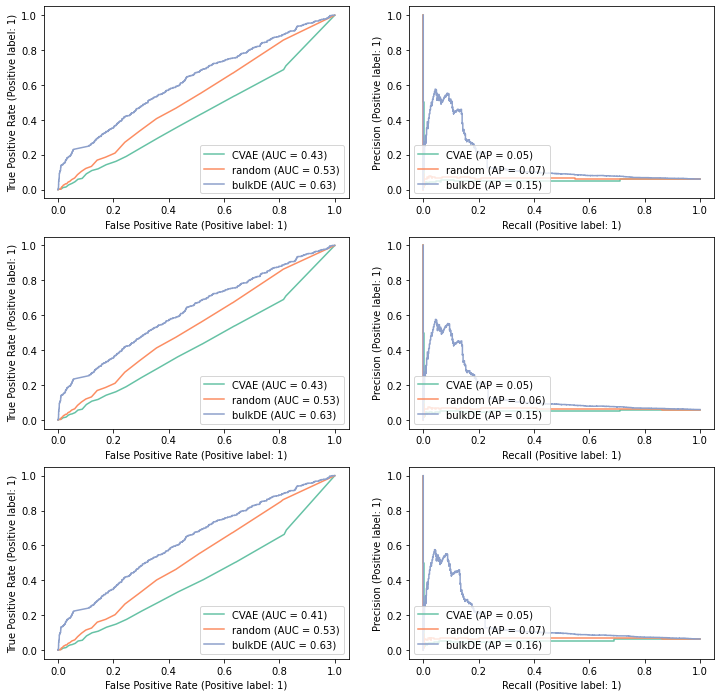

In [263]:

# get PR curve

curr_cell_type = "hepatocyte"


# get our DE genes
#all_keys = ['hepatocyte',
#            'hepatic_sinusoid',
#            'kupffer',
#            'NK','b_cell']
#all_keys = np.setdiff1d(all_keys, curr_cell_type)
#de_genes_curr = [de_genes[x] for x in all_keys]
#de_genes_curr=[element for sublist in de_genes_curr for element in sublist]
#de_genes_curr = [x.upper() for x in de_genes_curr]

# get our DE genes
de_genes_curr = de_genes[curr_cell_type]
de_genes_curr = [x.upper() for x in de_genes_curr]


# get bulk DE genes

# set the reference genes
DE_ref = Pub_DE
ct_DE_ref = Pub_DE_hepatic
extra_ref = np.union1d(de_genes_curr[:min_overlap], ct_DE_ref)



fig, axs = plt.subplots(3, 2, figsize=(12, 12))
axs, proj_log2FC_df = plot_PR_ROC(ctrl_test_meta_df, decoded_0_0, decoded_0_1, 
                                    bulk_sig_df, curr_cell_type, DE_ref, ct_DE_ref, 
                                    extra_ref, axs, union_genes_cap)
fig.show()


In [266]:
a = proj_log2FC_df.iloc[np.argsort(proj_log2FC_df[0])[::-1]]
a.iloc[:30]

0  orig  random    bulkDE  isDE  hepaticDE  X_Y
SRGAP1         53.0  53.0     2.0  0.308003     0          0    0
CLSTN3         53.0 -53.0     9.0  1.015961     1          1    1
HHIP           51.0 -51.0     0.0  0.578489     0          0    0
LAMB1          49.0 -49.0     1.0  0.804011     0          0    0
DAGLA          45.0 -45.0     1.0  0.028835     0          0    0
PDE4C          43.0 -43.0     6.0  0.639435     0          0    0
PDGFRB         43.0 -43.0     1.0  0.324008     0          0    0
IGSF10         42.0 -42.0     3.0  0.053880     0          0    0
MILL2          41.0 -41.0     4.0  0.026519     0          0    0
ANO1           41.0 -41.0     0.0  0.316352     0          0    0
SRPX2          41.0 -41.0     7.0  0.015799     0          0    0
CADM3          39.0 -39.0     3.0  0.783141     0          0    0
RBMS3          39.0 -39.0     0.0  0.059272     0          0    0
NGF            38.0 -38.0    10.0  0.824126     0          0    0
FAM174B        38.0  38.0     2.0  0.219294     0          0    0
RGS5           37.0 -37.0     3.0  0.539519     0          0    0
MLPH           36.0 -36.0     5.0  0.442045     0          0    0
GGT5           36.0 -36.0     7.0  0.085610     0          0    0
FABP4          36.0  36.0     2.0  0.902370     0          0    0
9530026P05RIK  36.0 -36.0    12.0  0.563722     0          0    0
CYYR1          36.0  36.0     4.0  0.332856     0          0    0
GDF6           35.0 -35.0     0.5  0.450398     0          0    0
ADCY5          35.0 -35.0     1.0  0.639812     0          0    0
DCN            34.0 -34.0     8.0  0.135073     0          0    0
SEMA3F         34.0  34.0     2.0  0.197651     0          0    0
HOXA5          33.0  33.0    11.0  0.314916     0          0    0
ABCG3          32.0  32.0     0.0  0.344468     0          0    0
TMEM88         32.0  32.0     5.0  0.059037     0          0    0
LTC4S          31.0  31.0     0.0  0.422394     0          0    0
DCHS1          31.0  31.0    12.0  0.237696     0          0    0

<ipython-input-262-f56099339fa2>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.isDE[np.where(np.isin(union_genes_cap, DE_ref))[0]] = 1
<ipython-input-262-f56099339fa2>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.hepaticDE[np.where(np.isin(union_genes_cap, ct_DE_ref))[0]] = 1
<ipython-input-262-f56099339fa2>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.X_Y[np.where(np.isin(unio

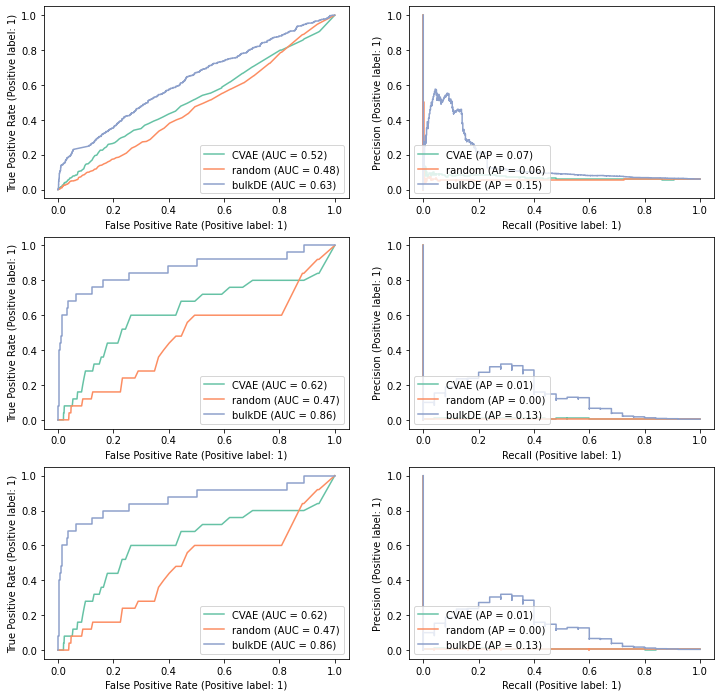

In [289]:
curr_cell_type = "hepatic_stellate"


# set the reference genes
DE_ref = Pub_DE
ct_DE_ref = Pub_DE_hsc
extra_ref = Pub_DE_hsc


fig, axs = plt.subplots(3, 2, figsize=(12, 12))
axs, proj_log2FC_df = plot_PR_ROC(ctrl_test_meta_df, decoded_0_0, decoded_0_1, 
                                    bulk_sig_df, curr_cell_type, DE_ref, ct_DE_ref, 
                                    extra_ref, axs, union_genes_cap)
fig.show()


<ipython-input-262-f56099339fa2>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.isDE[np.where(np.isin(union_genes_cap, DE_ref))[0]] = 1
<ipython-input-262-f56099339fa2>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.hepaticDE[np.where(np.isin(union_genes_cap, ct_DE_ref))[0]] = 1
<ipython-input-262-f56099339fa2>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.X_Y[np.where(np.isin(unio

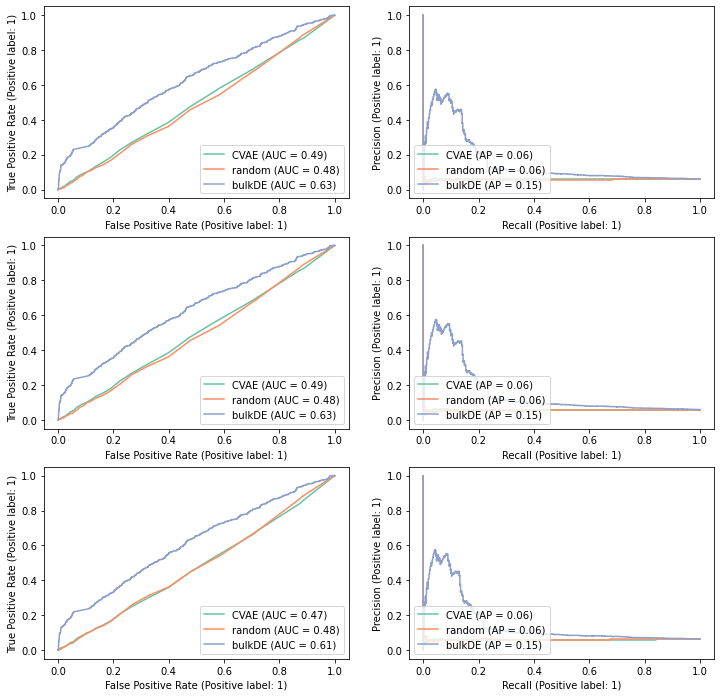

In [290]:

curr_cell_type = "hepatic_sinusoid"

# get our DE genes
de_genes_curr = de_genes[curr_cell_type]
de_genes_curr = [x.upper() for x in de_genes_curr]


# set the reference genes
DE_ref = Pub_DE
ct_DE_ref = Pub_DE_hepatic
extra_ref = np.union1d(de_genes_curr[:min_overlap], ct_DE_ref)


fig, axs = plt.subplots(3, 2, figsize=(12, 12))
axs, proj_log2FC_df = plot_PR_ROC(ctrl_test_meta_df, decoded_0_0, decoded_0_1, 
                                    bulk_sig_df, curr_cell_type, DE_ref, ct_DE_ref, 
                                    extra_ref, axs, union_genes_cap)
fig.show()


<ipython-input-262-f56099339fa2>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.isDE[np.where(np.isin(union_genes_cap, DE_ref))[0]] = 1
<ipython-input-262-f56099339fa2>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.hepaticDE[np.where(np.isin(union_genes_cap, ct_DE_ref))[0]] = 1
<ipython-input-262-f56099339fa2>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.X_Y[np.where(np.isin(unio

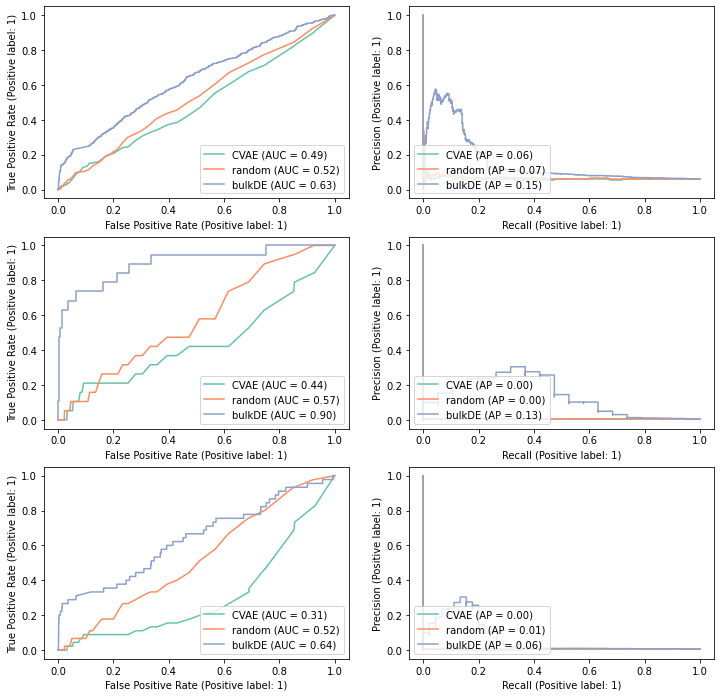

In [291]:

# get PR curve

curr_cell_type = "kupffer"

# get our DE genes
de_genes_curr = de_genes[curr_cell_type]
de_genes_curr = [x.upper() for x in de_genes_curr]

a = ["MIS18BP1", "CIT", "MYO5A"]

# set the reference genes
DE_ref = Pub_DE
ct_DE_ref = Pub_DE_kupffer
extra_ref = np.union1d(de_genes_curr[:min_overlap], ct_DE_ref)


fig, axs = plt.subplots(3, 2, figsize=(12, 12))
axs, proj_log2FC_df = plot_PR_ROC(ctrl_test_meta_df, decoded_0_0, decoded_0_1, 
                                    bulk_sig_df, curr_cell_type, DE_ref, ct_DE_ref, 
                                    extra_ref, axs, union_genes_cap)
fig.show()


<ipython-input-262-f56099339fa2>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.isDE[np.where(np.isin(union_genes_cap, DE_ref))[0]] = 1
<ipython-input-262-f56099339fa2>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.hepaticDE[np.where(np.isin(union_genes_cap, ct_DE_ref))[0]] = 1
<ipython-input-262-f56099339fa2>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.X_Y[np.where(np.isin(unio

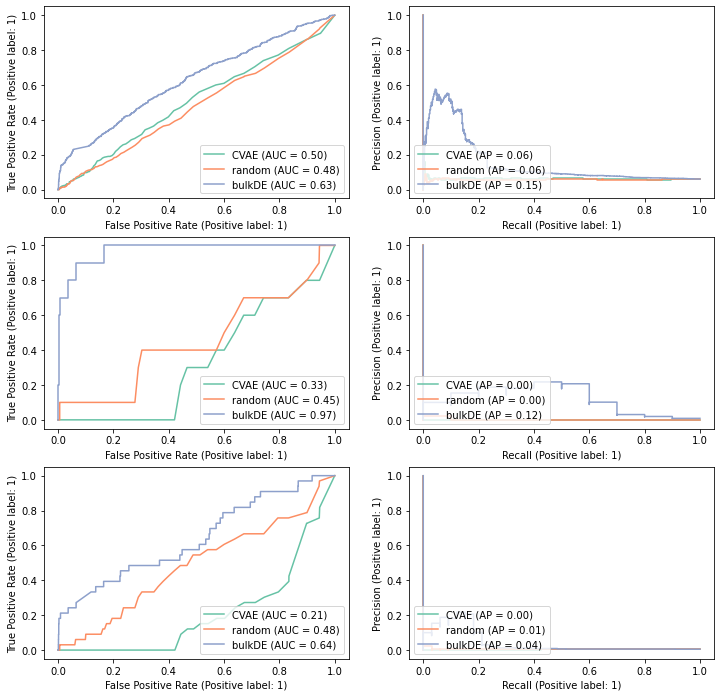

In [292]:

# get PR curve

curr_cell_type = "NK"

# get our DE genes
de_genes_curr = de_genes[curr_cell_type]
de_genes_curr = [x.upper() for x in de_genes_curr]


# set the reference genes
DE_ref = Pub_DE
ct_DE_ref = Pub_DE_immune
extra_ref = np.union1d(de_genes_curr[:min_overlap], ct_DE_ref)



fig, axs = plt.subplots(3, 2, figsize=(12, 12))
axs, proj_log2FC_df = plot_PR_ROC(ctrl_test_meta_df, decoded_0_0, decoded_0_1, 
                                    bulk_sig_df, curr_cell_type, DE_ref, ct_DE_ref, 
                                    extra_ref, axs, union_genes_cap)
fig.show()



<ipython-input-262-f56099339fa2>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.isDE[np.where(np.isin(union_genes_cap, DE_ref))[0]] = 1
<ipython-input-262-f56099339fa2>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.hepaticDE[np.where(np.isin(union_genes_cap, ct_DE_ref))[0]] = 1
<ipython-input-262-f56099339fa2>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.X_Y[np.where(np.isin(unio

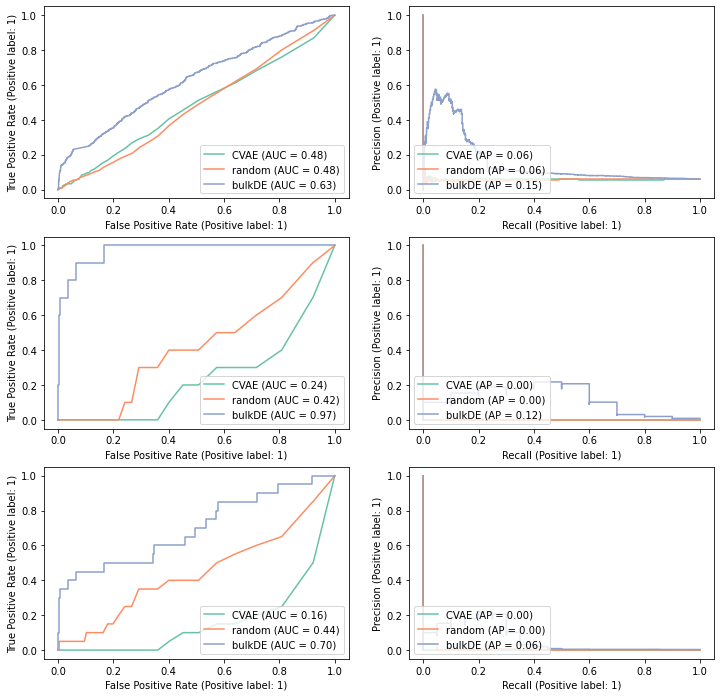

In [293]:

# get PR curve

curr_cell_type = "b_cell"

# get our DE genes
de_genes_curr = de_genes[curr_cell_type]
de_genes_curr = [x.upper() for x in de_genes_curr]


# set the reference genes
DE_ref = Pub_DE
ct_DE_ref = Pub_DE_immune
extra_ref = np.union1d(de_genes_curr[:min_overlap], ct_DE_ref)



fig, axs = plt.subplots(3, 2, figsize=(12, 12))
axs, proj_log2FC_df = plot_PR_ROC(ctrl_test_meta_df, decoded_0_0, decoded_0_1, 
                                    bulk_sig_df, curr_cell_type, DE_ref, ct_DE_ref, 
                                    extra_ref, axs, union_genes_cap)
fig.show()

